In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit
import random
import os
import gc
import math
import optuna
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from geomloss import SamplesLoss
from torch.autograd import Function
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.functional import normalize
#from torchmetrics.classification import BinaryAccuracyS
from torchmetrics.classification import BinaryF1Score,BinaryAccuracy
from sklearn.preprocessing import StandardScaler
torch.manual_seed(42)

/home/ahmad/envs/RL/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [3]:
def get_data(file_num):

    data_train=pd.read_csv(f"Dataset/Jobs/jobs_train_{file_num}.csv",index_col=False)

    data_test = pd.read_csv(f"Dataset/Jobs/jobs_test_{file_num}.csv",index_col=False)

    data_train_x = data_train.iloc[:, 0:17].to_numpy() 
    data_test_x = data_test.iloc[:, 0:17].to_numpy() 

    data_mean = np.mean(data_train_x, axis=0, keepdims=True)
    data_std = np.std(data_train_x, axis=0, keepdims=True)

    data_train_x = pd.DataFrame((data_train_x - data_mean) / data_std)
    data_test_x = pd.DataFrame((data_test_x - data_mean) / data_std)

    data_train_t = data_train.iloc[:, 17:18]
    data_train_y = data_train.iloc[:, 18:19].astype(np.float32)
    data_train_e = data_train.iloc[:, 19:20]

    data_test_t = data_test.iloc[:, 17:18]
    data_test_y = data_test.iloc[:, 18:19].astype(np.float32)
    data_test_e = data_test.iloc[:, 19:20]


    train_data=pd.concat([data_train_x,data_train_t,data_train_e],1)
    train_y=data_train_y

    test_data=pd.concat([data_test_x,data_test_t,data_test_e],1)
    test_y=data_test_y
    
    return train_data,train_y,test_data,test_y


In [4]:
#train_x,train_y,train_potential_y,test_x,test_potential_y=get_data()

In [5]:
def get_dataloader(x_data,y_data,batch_size):

    x_train_sr=x_data[x_data['t']==0]
    y_train_sr=y_data[x_data['t']==0]
    x_train_tr=x_data[x_data['t']==1]
    y_train_tr=y_data[x_data['t']==1]


    train_data_sr = Data(np.array(x_train_sr), np.array(y_train_sr))
    train_dataloader_sr = DataLoader(dataset=train_data_sr, batch_size=batch_size)

    train_data_tr = Data(np.array(x_train_tr), np.array(y_train_tr))
    train_dataloader_tr = DataLoader(dataset=train_data_tr, batch_size=batch_size)


    return train_dataloader_sr, train_dataloader_tr

In [6]:
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = torch.sum((1. - t_true) * torch.square(y_true - y0_pred))
    loss1 = torch.sum(t_true * torch.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

In [7]:
def loss_cal(X_data,y_data,net,alpha):
    b_accu = BinaryAccuracy()
    b_f1=BinaryF1Score()
    
    x_train_sr=X_data[X_data['t']==0]
    y_train_sr=y_data[X_data['t']==0]
    x_train_tr=X_data[X_data['t']==1]
    y_train_tr=y_data[X_data['t']==1]
    xs_t=x_train_sr.iloc[:,17].to_numpy()
    xt_t=x_train_tr.iloc[:,17].to_numpy()
    
    
    xs=x_train_sr.iloc[:,0:17].to_numpy()
    xt=x_train_tr.iloc[:,0:17].to_numpy()
    xs_t=torch.from_numpy(xs_t.astype(np.float32))
    xt_t=torch.from_numpy(xt_t.astype(np.float32))
    y_train_sr=y_train_sr.to_numpy()
    y_train_tr=y_train_tr.to_numpy()
    xs=torch.from_numpy(xs.astype(np.float32))
    xt=torch.from_numpy(xt.astype(np.float32))
    
    y_train_sr=torch.from_numpy(y_train_sr.astype(np.float32))
    y_train_tr=torch.from_numpy(y_train_tr.astype(np.float32))
    
    
    input_data=torch.cat((xs,xt),0)
    #true_y=torch.unsqueeze(torch.cat((y_train_sr,y_train_tr),0), dim=1)
    true_y=torch.cat((y_train_sr,y_train_tr),0)
    true_t=torch.unsqueeze(torch.cat((xs_t,xt_t),0), dim=1)
    
    
    concat_true=torch.cat((true_y,true_t),1)
    concat_pred,d_out,phi=net(input_data,alpha)
    loss=regression_loss(concat_true, concat_pred)
    
    
    
    t_actual=torch.cat((xs_t.type(torch.LongTensor),xt_t.type(torch.LongTensor)),0)
    
    domain_loss=criterion(d_out, t_actual)
    
    predicted = torch.argmax(d_out, dim=1)
    
    
    
    
    return domain_loss.item(),loss.item(),b_accu(predicted, t_actual.squeeze()),b_f1(predicted, t_actual.squeeze())

In [8]:
def objective(trial,i,x_data,y_data):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 512),
          'RL21': trial.suggest_int('RL21', 16, 512),
          'RL32': trial.suggest_int('RL32', 16, 512),
          'RG012':trial.suggest_int('RG012', 16, 512),
        'RG022':trial.suggest_int('RG022', 16, 512),
        'RG112':trial.suggest_int('RG112', 16, 512),
        'RG122':trial.suggest_int('RG122', 16, 512),
        'CL12':trial.suggest_int('CL12', 16, 512),
        'CL22':trial.suggest_int('CL22', 16, 512)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i,x_data,y_data)

    return pehe

In [9]:
# PEHE evaluation
def cal_pehe(data,y,model, alpha=0.5):
    #data,y=get_data('test',i)

    data=data.to_numpy()
    data=torch.from_numpy(data.astype(np.float32))
    
    y=y.to_numpy()
    y=torch.from_numpy(y.astype(np.float32))



    concat_pred,d_out,phi=model(data[:,0:17])
    #dont forget to rescale the outcome before estimation!
    #y0_pred = data['y_scaler'].inverse_transform(concat_pred[:, 0].reshape(-1, 1))
    #y1_pred = data['y_scaler'].inverse_transform(concat_pred[:, 1].reshape(-1, 1))
    #y0=scaler.inverse_transform(concat_pred[:,0].reshape(-1, 1))
    #y1=scaler.inverse_transform(concat_pred[:,1].reshape(-1, 1))
    cate_pred=concat_pred[:,1]-concat_pred[:,0]
    #cate_pred=y1-y0
    
    #cate_true=data[:,4]-data[:,3] #Hill's noiseless true values
    cate_true=y[:,1] - y[:,0]


    cate_err=torch.mean( torch.square( ( (cate_true) - (cate_pred) ) ) )

    return torch.sqrt(cate_err).item()



In [10]:
def cal_Rpol(test_data,test_y,model):
    data=test_data.iloc[:,0:17].to_numpy()
    data=torch.from_numpy(data.astype(np.float32))
    #(t: np.ndarray, y: np.ndarray, hat_y: np.ndarray) -> np.ndarray
    concat_pred,d_out,phi=model(data)
    hat_y=concat_pred.detach().numpy()
    t=test_data.iloc[:,17].to_numpy()
    y=test_y.to_numpy().squeeze() 
    hat_t = np.sign(hat_y[:, 1] - hat_y[:, 0])
    hat_t = 0.5 * (hat_t + 1)
    new_hat_t = np.abs(1 - hat_t)
    # Intersection
    idx1 = hat_t * t
    idx0 = new_hat_t * (1 - t)

    # risk policy computation
    RPol1 = (np.sum(idx1 * y) / (np.sum(idx1) + 1e-8)) * np.mean(hat_t)
    RPol0 = (np.sum(idx0 * y) / (np.sum(idx0) + 1e-8)) * np.mean(new_hat_t)
    
    return 1 - (RPol1 + RPol0)

In [11]:
class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(17, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,out_d2,phi

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None


In [12]:
epochs=300
#batch_size=32
criterion = nn.CrossEntropyLoss()
#x_data,y_data=get_data(0.9)

#criterion =nn.BCELoss()

In [13]:
train_loss=[]
val_loss=[]
train_accu=[]
val_accu=[]
val_f1=[]
train_f1=[]
train_tloss=[]
val_tloss=[]

d_loss=[]
pehe_error=[]
#num_files=2
def train_evaluate(param, model, trial,file_num,x_data,y_data):
    #for nf in range(1,num_files):
    X_train, X_val,y_train, y_val = train_test_split(x_data,y_data ,
                                       random_state=42, 
                                       test_size=0.27)
    
    
    
    #net=TarNet(25,.01)
    #opt_net = torch.optim.Adam(net.parameters(), lr=1e-4)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])
    
    if use_cuda:

        #model = model.cuda()
        model = model
        #criterion = criterion
  

    for ep in range(1,epochs+1 ):
        
        lamda_max=5
        e0=10
        train_dataloader_sr, train_dataloader_tr=get_dataloader(X_train,y_train,param['batch_size'])
        
        
        lambda_val=(lamda_max)*((ep-e0)/(epochs-e0))
        alpha=max(0,lambda_val)
        dis_loss=0
        total_loss=0
 
        for batch_idx, (train_source_data, train_target_data) in enumerate(zip(train_dataloader_sr, train_dataloader_tr)):
            
            xs,ys=train_source_data
            xt,yt=train_target_data
            
            xs_train=xs[:,0:17]
            xt_train=xt[:,0:17]
            #alpha=5
            
            train_x=torch.cat((xs_train,xt_train),0)
            #train_y=torch.unsqueeze(torch.cat((ys,yt),0), dim=1)
            train_y=torch.cat((ys,yt),0)
            true_t=torch.unsqueeze(torch.cat((xs[:,17],xt[:,17]),0), dim=1)
            concat_true=torch.cat((train_y,true_t),1)
            concat_pred,d_out,phi=model(train_x,alpha)
            
            
            #s_zeros_t=torch.zeros(xs_train.shape[0],1)
            #t_ones_t=torch.ones(xt_train.shape[0],1)

            #labels=torch.cat((s_zeros_t,t_ones_t),0)
           
            
            labels_discr=torch.cat((xs[:,17].type(torch.LongTensor),xt[:,17].type(torch.LongTensor)),0)
            #outputs_discr = domain_descr(phi,alpha)
            
            model.zero_grad()
            #opt_dis.zero_grad()
            

            #source_mse=criterion_reg(y0,ys)
            #target_mse=criterion_reg(y1,yt)
            domain_loss=criterion(d_out, labels_discr)
            reg_loss=regression_loss(concat_true,concat_pred)
            #combined loss
            combined_loss=domain_loss+reg_loss
            #print('Training loss: ',combined_loss.item())
            # backward propagation
            combined_loss.backward()
            dis_loss= dis_loss+domain_loss.item()
            total_loss=total_loss+combined_loss.item()
            # optimize
            optimizer.step()
            #opt_dis.step()
        #train_loss.append(loss_cal(X_train,y_train,model,alpha))
        #val_loss.append(loss_cal(X_val,y_val,model,alpha))
        with torch.no_grad():
            d_loss.append(dis_loss)
            d_loss_tr,tr_los,tr_ac,tr_f1=loss_cal(X_train,y_train,model,alpha)
            d_loss_val,vl_los,vl_ac,vl_f1=loss_cal(X_val,y_val,model,alpha)
            train_tloss.append(d_loss_tr)
            train_loss.append(tr_los)
            train_accu.append(tr_ac)
            train_f1.append(tr_f1)

            val_loss.append(vl_los)
            val_accu.append(vl_ac)
            val_f1.append(vl_f1)
            val_tloss.append(d_loss_val)

        
    #return cal_pehe(X_val,y_val,model),model
    #return total_loss,model
    #return d_loss_val+vl_los,model
    return vl_los,model
    #return cal_pehe_nn(X_val,y_val,model,alpha),model
    


In [14]:
def clear_all():
    train_loss.clear()
    train_accu.clear()
    train_f1.clear()
    val_loss.clear()
    val_accu.clear()
    val_f1.clear()
    d_loss.clear()
    train_tloss.clear()
    val_tloss.clear()
    

In [15]:
Rpol_total=[]
trails=50
#i=1
for i in range(0,100):
    train_data,train_y,test_data,test_y=get_data(i)
    func = lambda trial: objective(trial, i,train_data,train_y)
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(func, n_trials=trails)
    best_trial = study.best_trial
    best_model=TarNet(study.best_trial.params)
    clear_all()
    best_val,model=train_evaluate(study.best_trial.params, best_model, study.best_trial,i,train_data,train_y)
    Rpol=cal_Rpol(train_data,train_y,model)
    print('# of files completed so far:',i)
    Rpol_total.append(Rpol)
    del best_model
    del model
    del study
    del train_data
    del train_y
    del test_data
    del test_y
    gc.collect()

/tmp/ipykernel_115765/3754758553.py:25: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  train_data=pd.concat([data_train_x,data_train_t,data_train_e],1)
/tmp/ipykernel_115765/3754758553.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  test_data=pd.concat([data_test_x,data_test_t,data_test_e],1)
[I 2023-03-25 20:43:04,743] A new study created in memory with name: no-name-9d98db54-65e7-498f-882c-046a2c2c3adf
/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 20:43:15,791] Trial 0 finished with value: 81.58805084228516 and parameters: {'learning_

[I 2023-03-25 20:48:30,692] Trial 21 finished with value: 83.43132019042969 and parameters: {'learning_rate': 5.25633892559517e-05, 'optimizer': 'SGD', 'batch_size': 160, 'RL11': 191, 'RL21': 55, 'RL32': 169, 'RG012': 190, 'RG022': 377, 'RG112': 336, 'RG122': 485, 'CL12': 224, 'CL22': 17}. Best is trial 8 with value: 81.38658905029297.
[I 2023-03-25 20:48:40,190] Trial 22 finished with value: 85.7630615234375 and parameters: {'learning_rate': 4.2257948906378344e-05, 'optimizer': 'SGD', 'batch_size': 227, 'RL11': 185, 'RL21': 56, 'RL32': 176, 'RG012': 125, 'RG022': 395, 'RG112': 379, 'RG122': 358, 'CL12': 133, 'CL22': 81}. Best is trial 8 with value: 81.38658905029297.
[I 2023-03-25 20:48:54,183] Trial 23 finished with value: 83.51425170898438 and parameters: {'learning_rate': 8.782979941342768e-05, 'optimizer': 'SGD', 'batch_size': 152, 'RL11': 110, 'RL21': 51, 'RL32': 132, 'RG012': 68, 'RG022': 310, 'RG112': 457, 'RG122': 425, 'CL12': 280, 'CL22': 104}. Best is trial 8 with value: 81.

[I 2023-03-25 20:53:02,837] Trial 45 finished with value: 85.53620147705078 and parameters: {'learning_rate': 0.00014543435293612892, 'optimizer': 'SGD', 'batch_size': 219, 'RL11': 120, 'RL21': 366, 'RL32': 288, 'RG012': 285, 'RG022': 436, 'RG112': 205, 'RG122': 476, 'CL12': 380, 'CL22': 265}. Best is trial 33 with value: 80.27412414550781.
[I 2023-03-25 20:53:11,111] Trial 46 finished with value: 85.89523315429688 and parameters: {'learning_rate': 0.0002786125674640624, 'optimizer': 'SGD', 'batch_size': 240, 'RL11': 298, 'RL21': 495, 'RL32': 230, 'RG012': 209, 'RG022': 484, 'RG112': 133, 'RG122': 398, 'CL12': 101, 'CL22': 313}. Best is trial 33 with value: 80.27412414550781.
[I 2023-03-25 20:53:20,524] Trial 47 finished with value: 87.44458770751953 and parameters: {'learning_rate': 0.00043482307924860446, 'optimizer': 'SGD', 'batch_size': 128, 'RL11': 166, 'RL21': 285, 'RL32': 316, 'RG012': 287, 'RG022': 457, 'RG112': 81, 'RG122': 511, 'CL12': 404, 'CL22': 110}. Best is trial 33 with

# of files completed so far: 0


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 20:53:58,358] Trial 0 finished with value: 85.52476501464844 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 85.52476501464844.
[I 2023-03-25 20:54:05,539] Trial 1 finished with value: 85.55906677246094 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 85.524765014648

[I 2023-03-25 20:57:14,037] Trial 23 finished with value: 86.75128173828125 and parameters: {'learning_rate': 0.00016952364598735905, 'optimizer': 'SGD', 'batch_size': 214, 'RL11': 494, 'RL21': 325, 'RL32': 369, 'RG012': 330, 'RG022': 304, 'RG112': 124, 'RG122': 63, 'CL12': 114, 'CL22': 335}. Best is trial 16 with value: 83.3825912475586.
[I 2023-03-25 20:57:21,868] Trial 24 finished with value: 85.89799499511719 and parameters: {'learning_rate': 0.0004562719038945382, 'optimizer': 'SGD', 'batch_size': 132, 'RL11': 256, 'RL21': 388, 'RL32': 403, 'RG012': 305, 'RG022': 126, 'RG112': 54, 'RG122': 202, 'CL12': 21, 'CL22': 301}. Best is trial 16 with value: 83.3825912475586.
[I 2023-03-25 20:57:30,552] Trial 25 finished with value: 87.28642272949219 and parameters: {'learning_rate': 0.0001612180786722164, 'optimizer': 'SGD', 'batch_size': 108, 'RL11': 412, 'RL21': 237, 'RL32': 256, 'RG012': 210, 'RG022': 191, 'RG112': 133, 'RG122': 75, 'CL12': 305, 'CL22': 217}. Best is trial 16 with value

[I 2023-03-25 21:00:58,104] Trial 47 finished with value: 100.51663208007812 and parameters: {'learning_rate': 0.00028199608152043213, 'optimizer': 'Adam', 'batch_size': 193, 'RL11': 358, 'RL21': 53, 'RL32': 55, 'RG012': 113, 'RG022': 322, 'RG112': 203, 'RG122': 444, 'CL12': 299, 'CL22': 478}. Best is trial 46 with value: 82.96833801269531.
[I 2023-03-25 21:01:03,670] Trial 48 finished with value: 84.29273223876953 and parameters: {'learning_rate': 0.0003617226806896567, 'optimizer': 'SGD', 'batch_size': 165, 'RL11': 400, 'RL21': 114, 'RL32': 82, 'RG012': 172, 'RG022': 248, 'RG112': 26, 'RG122': 50, 'CL12': 282, 'CL22': 490}. Best is trial 46 with value: 82.96833801269531.
[I 2023-03-25 21:01:10,042] Trial 49 finished with value: 85.83779907226562 and parameters: {'learning_rate': 0.00013868199254828375, 'optimizer': 'SGD', 'batch_size': 91, 'RL11': 313, 'RL21': 92, 'RL32': 16, 'RG012': 184, 'RG022': 260, 'RG112': 260, 'RG122': 305, 'CL12': 47, 'CL22': 251}. Best is trial 46 with value

# of files completed so far: 1


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 21:01:25,852] Trial 0 finished with value: 83.32530212402344 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 83.32530212402344.
[I 2023-03-25 21:01:32,749] Trial 1 finished with value: 81.29019927978516 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 81.290199279785

[I 2023-03-25 21:04:55,801] Trial 23 finished with value: 83.7110595703125 and parameters: {'learning_rate': 1.7449939126635712e-05, 'optimizer': 'SGD', 'batch_size': 85, 'RL11': 291, 'RL21': 413, 'RL32': 273, 'RG012': 287, 'RG022': 59, 'RG112': 199, 'RG122': 476, 'CL12': 316, 'CL22': 218}. Best is trial 21 with value: 80.9406509399414.
[I 2023-03-25 21:05:05,276] Trial 24 finished with value: 82.8221206665039 and parameters: {'learning_rate': 3.2105572785096045e-05, 'optimizer': 'SGD', 'batch_size': 73, 'RL11': 22, 'RL21': 330, 'RL32': 327, 'RG012': 357, 'RG022': 172, 'RG112': 16, 'RG122': 400, 'CL12': 396, 'CL22': 22}. Best is trial 21 with value: 80.9406509399414.
[I 2023-03-25 21:05:16,053] Trial 25 finished with value: 85.59925842285156 and parameters: {'learning_rate': 1.7721692118088006e-05, 'optimizer': 'SGD', 'batch_size': 41, 'RL11': 374, 'RL21': 211, 'RL32': 402, 'RG012': 419, 'RG022': 63, 'RG112': 239, 'RG122': 366, 'CL12': 401, 'CL22': 307}. Best is trial 21 with value: 80

[I 2023-03-25 21:08:51,689] Trial 47 finished with value: 81.84121704101562 and parameters: {'learning_rate': 2.088554864744241e-05, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 312, 'RL21': 269, 'RL32': 500, 'RG012': 498, 'RG022': 472, 'RG112': 221, 'RG122': 446, 'CL12': 426, 'CL22': 481}. Best is trial 21 with value: 80.9406509399414.
[I 2023-03-25 21:09:05,411] Trial 48 finished with value: 82.39673614501953 and parameters: {'learning_rate': 2.1420444660527998e-05, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 327, 'RL21': 272, 'RL32': 511, 'RG012': 500, 'RG022': 468, 'RG112': 192, 'RG122': 305, 'CL12': 436, 'CL22': 479}. Best is trial 21 with value: 80.9406509399414.
[I 2023-03-25 21:09:13,911] Trial 49 finished with value: 82.99093627929688 and parameters: {'learning_rate': 1.2604591848489805e-05, 'optimizer': 'SGD', 'batch_size': 178, 'RL11': 306, 'RL21': 213, 'RL32': 16, 'RG012': 482, 'RG022': 462, 'RG112': 256, 'RG122': 451, 'CL12': 415, 'CL22': 458}. Best is trial 21 with v

# of files completed so far: 2


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 21:09:31,176] Trial 0 finished with value: 80.79920196533203 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 80.79920196533203.
[I 2023-03-25 21:09:38,152] Trial 1 finished with value: 81.06600952148438 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 80.799201965332

[I 2023-03-25 21:13:10,339] Trial 23 finished with value: 77.26722717285156 and parameters: {'learning_rate': 1.5994973568810523e-05, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 472, 'RL21': 461, 'RL32': 283, 'RG012': 505, 'RG022': 135, 'RG112': 127, 'RG122': 49, 'CL12': 429, 'CL22': 303}. Best is trial 16 with value: 76.9852066040039.
[I 2023-03-25 21:13:19,350] Trial 24 finished with value: 83.83110809326172 and parameters: {'learning_rate': 1.6034461966968242e-05, 'optimizer': 'SGD', 'batch_size': 224, 'RL11': 449, 'RL21': 459, 'RL32': 296, 'RG012': 507, 'RG022': 142, 'RG112': 131, 'RG122': 38, 'CL12': 440, 'CL22': 302}. Best is trial 16 with value: 76.9852066040039.
[I 2023-03-25 21:13:28,436] Trial 25 finished with value: 80.0359115600586 and parameters: {'learning_rate': 3.373930055433765e-05, 'optimizer': 'SGD', 'batch_size': 138, 'RL11': 320, 'RL21': 452, 'RL32': 290, 'RG012': 461, 'RG022': 129, 'RG112': 205, 'RG122': 58, 'CL12': 436, 'CL22': 372}. Best is trial 16 with valu

[I 2023-03-25 21:17:20,198] Trial 47 finished with value: 80.13328552246094 and parameters: {'learning_rate': 4.6425703289257835e-05, 'optimizer': 'SGD', 'batch_size': 153, 'RL11': 402, 'RL21': 298, 'RL32': 434, 'RG012': 466, 'RG022': 451, 'RG112': 43, 'RG122': 345, 'CL12': 341, 'CL22': 182}. Best is trial 16 with value: 76.9852066040039.
[I 2023-03-25 21:17:28,895] Trial 48 finished with value: 77.41876220703125 and parameters: {'learning_rate': 3.3344130500559325e-05, 'optimizer': 'SGD', 'batch_size': 195, 'RL11': 118, 'RL21': 356, 'RL32': 320, 'RG012': 408, 'RG022': 209, 'RG112': 123, 'RG122': 48, 'CL12': 306, 'CL22': 313}. Best is trial 16 with value: 76.9852066040039.
[I 2023-03-25 21:17:37,207] Trial 49 finished with value: 77.6194839477539 and parameters: {'learning_rate': 3.430774888060613e-05, 'optimizer': 'SGD', 'batch_size': 191, 'RL11': 26, 'RL21': 347, 'RL32': 323, 'RG012': 344, 'RG022': 164, 'RG112': 126, 'RG122': 143, 'CL12': 310, 'CL22': 326}. Best is trial 16 with valu

# of files completed so far: 3


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 21:17:56,166] Trial 0 finished with value: 71.90345764160156 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 71.90345764160156.
[I 2023-03-25 21:18:03,247] Trial 1 finished with value: 72.01863098144531 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 71.903457641601

[I 2023-03-25 21:21:37,333] Trial 23 finished with value: 71.71670532226562 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 92, 'RL11': 419, 'RL21': 189, 'RL32': 195, 'RG012': 403, 'RG022': 375, 'RG112': 448, 'RG122': 89, 'CL12': 243, 'CL22': 25}. Best is trial 22 with value: 70.84854125976562.
[I 2023-03-25 21:21:48,584] Trial 24 finished with value: 71.93790435791016 and parameters: {'learning_rate': 6.878249241165849e-05, 'optimizer': 'SGD', 'batch_size': 47, 'RL11': 307, 'RL21': 298, 'RL32': 282, 'RG012': 317, 'RG022': 457, 'RG112': 465, 'RG122': 174, 'CL12': 109, 'CL22': 59}. Best is trial 22 with value: 70.84854125976562.
[I 2023-03-25 21:21:57,988] Trial 25 finished with value: 71.47361755371094 and parameters: {'learning_rate': 1.807894651599427e-05, 'optimizer': 'SGD', 'batch_size': 131, 'RL11': 449, 'RL21': 137, 'RL32': 112, 'RG012': 310, 'RG022': 445, 'RG112': 385, 'RG122': 64, 'CL12': 324, 'CL22': 124}. Best is trial 22 with value:

[I 2023-03-25 21:25:01,937] Trial 47 finished with value: 72.87733459472656 and parameters: {'learning_rate': 2.027596841367933e-05, 'optimizer': 'Adam', 'batch_size': 216, 'RL11': 461, 'RL21': 472, 'RL32': 70, 'RG012': 480, 'RG022': 54, 'RG112': 369, 'RG122': 87, 'CL12': 69, 'CL22': 249}. Best is trial 26 with value: 69.11761474609375.
[I 2023-03-25 21:25:11,767] Trial 48 finished with value: 72.54590606689453 and parameters: {'learning_rate': 1.7295243542385833e-05, 'optimizer': 'SGD', 'batch_size': 154, 'RL11': 496, 'RL21': 392, 'RL32': 511, 'RG012': 215, 'RG022': 94, 'RG112': 295, 'RG122': 40, 'CL12': 222, 'CL22': 391}. Best is trial 26 with value: 69.11761474609375.
[I 2023-03-25 21:25:18,039] Trial 49 finished with value: 77.47461700439453 and parameters: {'learning_rate': 1.3702295489398097e-05, 'optimizer': 'SGD', 'batch_size': 207, 'RL11': 406, 'RL21': 446, 'RL32': 39, 'RG012': 390, 'RG022': 142, 'RG112': 334, 'RG122': 170, 'CL12': 190, 'CL22': 275}. Best is trial 26 with valu

# of files completed so far: 4


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 21:25:35,118] Trial 0 finished with value: 70.13275146484375 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 70.13275146484375.
[I 2023-03-25 21:25:42,258] Trial 1 finished with value: 70.56947326660156 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 70.132751464843

[I 2023-03-25 21:29:12,257] Trial 23 finished with value: 71.37398529052734 and parameters: {'learning_rate': 0.00024482692238205763, 'optimizer': 'SGD', 'batch_size': 136, 'RL11': 71, 'RL21': 508, 'RL32': 425, 'RG012': 330, 'RG022': 281, 'RG112': 104, 'RG122': 486, 'CL12': 217, 'CL22': 230}. Best is trial 20 with value: 68.02713012695312.
[I 2023-03-25 21:29:20,387] Trial 24 finished with value: 71.07576751708984 and parameters: {'learning_rate': 0.00012464784350607066, 'optimizer': 'SGD', 'batch_size': 224, 'RL11': 19, 'RL21': 450, 'RL32': 403, 'RG012': 430, 'RG022': 304, 'RG112': 104, 'RG122': 291, 'CL12': 139, 'CL22': 473}. Best is trial 20 with value: 68.02713012695312.
[I 2023-03-25 21:29:31,323] Trial 25 finished with value: 70.00438690185547 and parameters: {'learning_rate': 0.00017224824486680775, 'optimizer': 'SGD', 'batch_size': 133, 'RL11': 134, 'RL21': 414, 'RL32': 511, 'RG012': 291, 'RG022': 125, 'RG112': 216, 'RG122': 371, 'CL12': 372, 'CL22': 302}. Best is trial 20 with

[I 2023-03-25 21:32:43,709] Trial 47 finished with value: 68.9843521118164 and parameters: {'learning_rate': 6.032808744964285e-05, 'optimizer': 'Adam', 'batch_size': 192, 'RL11': 40, 'RL21': 79, 'RL32': 358, 'RG012': 113, 'RG022': 231, 'RG112': 183, 'RG122': 430, 'CL12': 193, 'CL22': 136}. Best is trial 32 with value: 66.89119720458984.
[I 2023-03-25 21:32:50,758] Trial 48 finished with value: 71.22050476074219 and parameters: {'learning_rate': 0.00010062771216909211, 'optimizer': 'SGD', 'batch_size': 218, 'RL11': 168, 'RL21': 446, 'RL32': 209, 'RG012': 51, 'RG022': 323, 'RG112': 138, 'RG122': 499, 'CL12': 332, 'CL22': 173}. Best is trial 32 with value: 66.89119720458984.
[I 2023-03-25 21:32:59,625] Trial 49 finished with value: 70.1226806640625 and parameters: {'learning_rate': 3.930017305044066e-05, 'optimizer': 'SGD', 'batch_size': 164, 'RL11': 447, 'RL21': 383, 'RL32': 282, 'RG012': 188, 'RG022': 211, 'RG112': 170, 'RG122': 262, 'CL12': 272, 'CL22': 55}. Best is trial 32 with valu

# of files completed so far: 5


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 21:33:17,659] Trial 0 finished with value: 86.52951049804688 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 86.52951049804688.
[I 2023-03-25 21:33:24,703] Trial 1 finished with value: 92.57270812988281 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 86.529510498046

[I 2023-03-25 21:36:53,601] Trial 23 finished with value: 87.43482208251953 and parameters: {'learning_rate': 0.0005075885264077756, 'optimizer': 'SGD', 'batch_size': 179, 'RL11': 325, 'RL21': 16, 'RL32': 293, 'RG012': 244, 'RG022': 17, 'RG112': 16, 'RG122': 403, 'CL12': 385, 'CL22': 329}. Best is trial 22 with value: 84.74220275878906.
[W 2023-03-25 21:36:59,906] Trial 24 failed with parameters: {'learning_rate': 0.0009743505684198103, 'optimizer': 'SGD', 'batch_size': 228, 'RL11': 251, 'RL21': 18, 'RL32': 384, 'RG012': 251, 'RG022': 22, 'RG112': 85, 'RG122': 474, 'CL12': 461, 'CL22': 305} because of the following error: The value nan is not acceptable..
[W 2023-03-25 21:36:59,907] Trial 24 failed with value nan.
[W 2023-03-25 21:37:06,116] Trial 25 failed with parameters: {'learning_rate': 0.0008528753826947508, 'optimizer': 'SGD', 'batch_size': 222, 'RL11': 275, 'RL21': 16, 'RL32': 382, 'RG012': 262, 'RG022': 23, 'RG112': 77, 'RG122': 472, 'CL12': 419, 'CL22': 310} because of the fo

[I 2023-03-25 21:39:45,854] Trial 46 finished with value: 92.18604278564453 and parameters: {'learning_rate': 0.0006975527354415735, 'optimizer': 'SGD', 'batch_size': 145, 'RL11': 447, 'RL21': 108, 'RL32': 212, 'RG012': 237, 'RG022': 51, 'RG112': 50, 'RG122': 440, 'CL12': 490, 'CL22': 349}. Best is trial 41 with value: 84.03257751464844.
[I 2023-03-25 21:39:52,517] Trial 47 finished with value: 90.44973754882812 and parameters: {'learning_rate': 0.00024597705235409017, 'optimizer': 'SGD', 'batch_size': 200, 'RL11': 241, 'RL21': 188, 'RL32': 355, 'RG012': 315, 'RG022': 17, 'RG112': 82, 'RG122': 194, 'CL12': 444, 'CL22': 453}. Best is trial 41 with value: 84.03257751464844.
[I 2023-03-25 21:39:59,817] Trial 48 finished with value: 85.86669158935547 and parameters: {'learning_rate': 0.0003326846327090892, 'optimizer': 'SGD', 'batch_size': 185, 'RL11': 495, 'RL21': 71, 'RL32': 302, 'RG012': 148, 'RG022': 81, 'RG112': 136, 'RG122': 309, 'CL12': 398, 'CL22': 467}. Best is trial 41 with value

# of files completed so far: 6


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 21:40:24,556] Trial 0 finished with value: 76.4747543334961 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.4747543334961.
[I 2023-03-25 21:40:31,411] Trial 1 finished with value: 81.58174133300781 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 76.4747543334961.

[I 2023-03-25 21:44:14,882] Trial 23 finished with value: 74.70478057861328 and parameters: {'learning_rate': 0.00020691346075515186, 'optimizer': 'SGD', 'batch_size': 183, 'RL11': 127, 'RL21': 506, 'RL32': 412, 'RG012': 232, 'RG022': 509, 'RG112': 462, 'RG122': 294, 'CL12': 200, 'CL22': 222}. Best is trial 19 with value: 74.41587829589844.
[I 2023-03-25 21:44:24,052] Trial 24 finished with value: 79.4998779296875 and parameters: {'learning_rate': 0.00019392750415328497, 'optimizer': 'SGD', 'batch_size': 225, 'RL11': 138, 'RL21': 508, 'RL32': 384, 'RG012': 104, 'RG022': 511, 'RG112': 508, 'RG122': 291, 'CL12': 213, 'CL22': 221}. Best is trial 19 with value: 74.41587829589844.
[I 2023-03-25 21:44:36,750] Trial 25 finished with value: 74.61031341552734 and parameters: {'learning_rate': 0.0003176167020761799, 'optimizer': 'SGD', 'batch_size': 178, 'RL11': 221, 'RL21': 469, 'RL32': 508, 'RG012': 261, 'RG022': 434, 'RG112': 380, 'RG122': 283, 'CL12': 149, 'CL22': 217}. Best is trial 19 with

[I 2023-03-25 21:48:09,360] Trial 47 finished with value: 116.12107849121094 and parameters: {'learning_rate': 0.0003251026036747452, 'optimizer': 'Adam', 'batch_size': 128, 'RL11': 156, 'RL21': 392, 'RL32': 511, 'RG012': 433, 'RG022': 121, 'RG112': 317, 'RG122': 266, 'CL12': 118, 'CL22': 169}. Best is trial 30 with value: 73.4944076538086.
[I 2023-03-25 21:48:18,331] Trial 48 finished with value: 79.48548889160156 and parameters: {'learning_rate': 0.0006279235475579696, 'optimizer': 'SGD', 'batch_size': 162, 'RL11': 50, 'RL21': 475, 'RL32': 484, 'RG012': 370, 'RG022': 74, 'RG112': 121, 'RG122': 470, 'CL12': 61, 'CL22': 140}. Best is trial 30 with value: 73.4944076538086.
[I 2023-03-25 21:48:29,238] Trial 49 finished with value: 75.94697570800781 and parameters: {'learning_rate': 0.0002461266300236205, 'optimizer': 'SGD', 'batch_size': 148, 'RL11': 424, 'RL21': 441, 'RL32': 455, 'RG012': 119, 'RG022': 262, 'RG112': 278, 'RG122': 348, 'CL12': 96, 'CL22': 72}. Best is trial 30 with value

# of files completed so far: 7


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 21:48:46,899] Trial 0 finished with value: 77.37724304199219 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.37724304199219.
[I 2023-03-25 21:48:54,082] Trial 1 finished with value: 76.9420166015625 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 76.9420166015625

[I 2023-03-25 21:52:16,042] Trial 23 finished with value: 74.83231353759766 and parameters: {'learning_rate': 0.00018580963605272283, 'optimizer': 'SGD', 'batch_size': 60, 'RL11': 433, 'RL21': 229, 'RL32': 448, 'RG012': 369, 'RG022': 181, 'RG112': 18, 'RG122': 193, 'CL12': 429, 'CL22': 312}. Best is trial 23 with value: 74.83231353759766.
[I 2023-03-25 21:52:25,635] Trial 24 finished with value: 75.88085174560547 and parameters: {'learning_rate': 9.983146979243465e-05, 'optimizer': 'SGD', 'batch_size': 59, 'RL11': 431, 'RL21': 236, 'RL32': 455, 'RG012': 374, 'RG022': 183, 'RG112': 16, 'RG122': 179, 'CL12': 433, 'CL22': 310}. Best is trial 23 with value: 74.83231353759766.
[I 2023-03-25 21:52:36,269] Trial 25 finished with value: 74.25680541992188 and parameters: {'learning_rate': 0.00027948394556830846, 'optimizer': 'SGD', 'batch_size': 62, 'RL11': 511, 'RL21': 189, 'RL32': 509, 'RG012': 450, 'RG022': 231, 'RG112': 132, 'RG122': 138, 'CL12': 388, 'CL22': 237}. Best is trial 25 with val

[I 2023-03-25 21:56:31,972] Trial 47 finished with value: 77.83274841308594 and parameters: {'learning_rate': 7.403796954696226e-05, 'optimizer': 'SGD', 'batch_size': 93, 'RL11': 462, 'RL21': 264, 'RL32': 416, 'RG012': 384, 'RG022': 91, 'RG112': 61, 'RG122': 130, 'CL12': 316, 'CL22': 265}. Best is trial 25 with value: 74.25680541992188.
[I 2023-03-25 21:56:45,482] Trial 48 finished with value: 76.8915786743164 and parameters: {'learning_rate': 0.0001671737359211786, 'optimizer': 'SGD', 'batch_size': 80, 'RL11': 238, 'RL21': 349, 'RL32': 487, 'RG012': 348, 'RG022': 434, 'RG112': 207, 'RG122': 305, 'CL12': 373, 'CL22': 291}. Best is trial 25 with value: 74.25680541992188.
[I 2023-03-25 21:56:52,809] Trial 49 finished with value: 76.82717895507812 and parameters: {'learning_rate': 0.00022610873961517464, 'optimizer': 'SGD', 'batch_size': 44, 'RL11': 414, 'RL21': 164, 'RL32': 125, 'RG012': 264, 'RG022': 140, 'RG112': 39, 'RG122': 224, 'CL12': 338, 'CL22': 175}. Best is trial 25 with value:

# of files completed so far: 8


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 21:57:12,874] Trial 0 finished with value: 80.04303741455078 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 80.04303741455078.
[I 2023-03-25 21:57:20,221] Trial 1 finished with value: 78.25562286376953 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 78.255622863769

[I 2023-03-25 22:00:44,990] Trial 23 finished with value: 76.0403060913086 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 145, 'RL11': 429, 'RL21': 508, 'RL32': 305, 'RG012': 429, 'RG022': 318, 'RG112': 504, 'RG122': 67, 'CL12': 187, 'CL22': 492}. Best is trial 20 with value: 74.91184997558594.
[I 2023-03-25 22:00:56,827] Trial 24 finished with value: 76.71234130859375 and parameters: {'learning_rate': 3.293029016152369e-05, 'optimizer': 'SGD', 'batch_size': 141, 'RL11': 418, 'RL21': 509, 'RL32': 403, 'RG012': 423, 'RG022': 288, 'RG112': 500, 'RG122': 74, 'CL12': 122, 'CL22': 512}. Best is trial 20 with value: 74.91184997558594.
[I 2023-03-25 22:01:08,080] Trial 25 finished with value: 75.49507141113281 and parameters: {'learning_rate': 1.6912664839330643e-05, 'optimizer': 'SGD', 'batch_size': 187, 'RL11': 417, 'RL21': 469, 'RL32': 309, 'RG012': 408, 'RG022': 326, 'RG112': 458, 'RG122': 74, 'CL12': 188, 'CL22': 493}. Best is trial 20 with val

[I 2023-03-25 22:05:31,476] Trial 47 finished with value: 81.71546936035156 and parameters: {'learning_rate': 1.2653526826071927e-05, 'optimizer': 'SGD', 'batch_size': 207, 'RL11': 501, 'RL21': 312, 'RL32': 253, 'RG012': 354, 'RG022': 492, 'RG112': 430, 'RG122': 309, 'CL12': 512, 'CL22': 294}. Best is trial 20 with value: 74.91184997558594.
[I 2023-03-25 22:05:41,936] Trial 48 finished with value: 77.40209197998047 and parameters: {'learning_rate': 1.6710956538779897e-05, 'optimizer': 'SGD', 'batch_size': 242, 'RL11': 467, 'RL21': 418, 'RL32': 301, 'RG012': 438, 'RG022': 381, 'RG112': 467, 'RG122': 119, 'CL12': 78, 'CL22': 425}. Best is trial 20 with value: 74.91184997558594.
[I 2023-03-25 22:05:51,170] Trial 49 finished with value: 74.26461791992188 and parameters: {'learning_rate': 2.332112470031629e-05, 'optimizer': 'SGD', 'batch_size': 190, 'RL11': 329, 'RL21': 383, 'RL32': 17, 'RG012': 264, 'RG022': 307, 'RG112': 404, 'RG122': 244, 'CL12': 148, 'CL22': 239}. Best is trial 49 with 

# of files completed so far: 9


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 22:06:09,348] Trial 0 finished with value: 72.68801879882812 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 72.68801879882812.
[I 2023-03-25 22:06:16,373] Trial 1 finished with value: 76.36262512207031 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 72.688018798828

[I 2023-03-25 22:09:53,064] Trial 23 finished with value: 76.95530700683594 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 138, 'RL11': 139, 'RL21': 16, 'RL32': 198, 'RG012': 194, 'RG022': 349, 'RG112': 457, 'RG122': 476, 'CL12': 129, 'CL22': 104}. Best is trial 0 with value: 72.68801879882812.
[I 2023-03-25 22:10:00,893] Trial 24 finished with value: 73.87152099609375 and parameters: {'learning_rate': 9.983146979243465e-05, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 86, 'RL21': 80, 'RL32': 272, 'RG012': 104, 'RG022': 457, 'RG112': 239, 'RG122': 375, 'CL12': 254, 'CL22': 69}. Best is trial 0 with value: 72.68801879882812.
[I 2023-03-25 22:10:09,179] Trial 25 finished with value: 72.01173400878906 and parameters: {'learning_rate': 9.93052546569481e-05, 'optimizer': 'Adam', 'batch_size': 177, 'RL11': 76, 'RL21': 81, 'RL32': 271, 'RG012': 77, 'RG022': 461, 'RG112': 232, 'RG122': 370, 'CL12': 313, 'CL22': 137}. Best is trial 25 with value: 72

[I 2023-03-25 22:14:12,178] Trial 47 finished with value: 71.98431396484375 and parameters: {'learning_rate': 5.128238979246331e-05, 'optimizer': 'Adam', 'batch_size': 165, 'RL11': 216, 'RL21': 37, 'RL32': 344, 'RG012': 505, 'RG022': 430, 'RG112': 228, 'RG122': 325, 'CL12': 280, 'CL22': 325}. Best is trial 44 with value: 70.71461486816406.
[I 2023-03-25 22:14:22,467] Trial 48 finished with value: 73.93514251708984 and parameters: {'learning_rate': 5.0379158988356504e-05, 'optimizer': 'SGD', 'batch_size': 164, 'RL11': 223, 'RL21': 36, 'RL32': 364, 'RG012': 506, 'RG022': 434, 'RG112': 222, 'RG122': 322, 'CL12': 282, 'CL22': 322}. Best is trial 44 with value: 70.71461486816406.
[I 2023-03-25 22:14:35,461] Trial 49 finished with value: 73.8173599243164 and parameters: {'learning_rate': 7.414595779317745e-05, 'optimizer': 'Adam', 'batch_size': 170, 'RL11': 268, 'RL21': 51, 'RL32': 352, 'RG012': 484, 'RG022': 419, 'RG112': 260, 'RG122': 292, 'CL12': 315, 'CL22': 283}. Best is trial 44 with v

# of files completed so far: 10


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 22:14:55,922] Trial 0 finished with value: 86.08585357666016 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 86.08585357666016.
[I 2023-03-25 22:15:03,006] Trial 1 finished with value: 85.42677307128906 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 85.426773071289

[I 2023-03-25 22:18:21,701] Trial 23 finished with value: 85.2113037109375 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'SGD', 'batch_size': 143, 'RL11': 228, 'RL21': 379, 'RL32': 241, 'RG012': 285, 'RG022': 237, 'RG112': 196, 'RG122': 468, 'CL12': 216, 'CL22': 206}. Best is trial 6 with value: 83.78585815429688.
[I 2023-03-25 22:18:29,797] Trial 24 finished with value: 83.79190063476562 and parameters: {'learning_rate': 2.9260055221830765e-05, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 165, 'RL21': 442, 'RL32': 199, 'RG012': 147, 'RG022': 172, 'RG112': 104, 'RG122': 378, 'CL12': 135, 'CL22': 20}. Best is trial 6 with value: 83.78585815429688.
[I 2023-03-25 22:18:35,249] Trial 25 finished with value: 86.02020263671875 and parameters: {'learning_rate': 3.0826636151456625e-05, 'optimizer': 'SGD', 'batch_size': 231, 'RL11': 89, 'RL21': 50, 'RL32': 107, 'RG012': 77, 'RG022': 445, 'RG112': 329, 'RG122': 300, 'CL12': 132, 'CL22': 28}. Best is trial 6 with value:

[I 2023-03-25 22:20:53,167] Trial 47 finished with value: 85.33246612548828 and parameters: {'learning_rate': 0.00010583987292570747, 'optimizer': 'SGD', 'batch_size': 212, 'RL11': 45, 'RL21': 195, 'RL32': 171, 'RG012': 114, 'RG022': 275, 'RG112': 117, 'RG122': 40, 'CL12': 512, 'CL22': 285}. Best is trial 32 with value: 82.97447967529297.
[I 2023-03-25 22:20:58,644] Trial 48 finished with value: 87.15875244140625 and parameters: {'learning_rate': 4.1126267359708746e-05, 'optimizer': 'SGD', 'batch_size': 186, 'RL11': 21, 'RL21': 20, 'RL32': 93, 'RG012': 74, 'RG022': 436, 'RG112': 80, 'RG122': 126, 'CL12': 420, 'CL22': 336}. Best is trial 32 with value: 82.97447967529297.
[I 2023-03-25 22:21:03,474] Trial 49 finished with value: 85.58366394042969 and parameters: {'learning_rate': 6.86969066828277e-05, 'optimizer': 'SGD', 'batch_size': 201, 'RL11': 82, 'RL21': 254, 'RL32': 131, 'RG012': 17, 'RG022': 394, 'RG112': 37, 'RG122': 161, 'CL12': 343, 'CL22': 405}. Best is trial 32 with value: 82

# of files completed so far: 11


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 22:21:18,483] Trial 0 finished with value: 84.21675872802734 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 84.21675872802734.
[I 2023-03-25 22:21:25,707] Trial 1 finished with value: 79.84626007080078 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 79.846260070800

[I 2023-03-25 22:25:04,896] Trial 23 finished with value: 80.70318603515625 and parameters: {'learning_rate': 2.759701149902149e-05, 'optimizer': 'SGD', 'batch_size': 107, 'RL11': 378, 'RL21': 20, 'RL32': 24, 'RG012': 369, 'RG022': 360, 'RG112': 460, 'RG122': 78, 'CL12': 61, 'CL22': 366}. Best is trial 2 with value: 78.98343658447266.
[I 2023-03-25 22:25:14,258] Trial 24 finished with value: 80.62102508544922 and parameters: {'learning_rate': 1.6418690332909266e-05, 'optimizer': 'SGD', 'batch_size': 26, 'RL11': 151, 'RL21': 144, 'RL32': 184, 'RG012': 297, 'RG022': 153, 'RG112': 392, 'RG122': 140, 'CL12': 147, 'CL22': 468}. Best is trial 2 with value: 78.98343658447266.
[I 2023-03-25 22:25:23,354] Trial 25 finished with value: 80.7513656616211 and parameters: {'learning_rate': 3.48472408698598e-05, 'optimizer': 'SGD', 'batch_size': 93, 'RL11': 230, 'RL21': 63, 'RL32': 86, 'RG012': 459, 'RG022': 317, 'RG112': 242, 'RG122': 169, 'CL12': 295, 'CL22': 302}. Best is trial 2 with value: 78.98

[I 2023-03-25 22:28:53,517] Trial 47 finished with value: 80.59953308105469 and parameters: {'learning_rate': 1.5912664146903315e-05, 'optimizer': 'SGD', 'batch_size': 42, 'RL11': 268, 'RL21': 154, 'RL32': 282, 'RG012': 179, 'RG022': 123, 'RG112': 252, 'RG122': 213, 'CL12': 73, 'CL22': 502}. Best is trial 41 with value: 78.77660369873047.
[I 2023-03-25 22:29:09,620] Trial 48 finished with value: 80.2757339477539 and parameters: {'learning_rate': 1.8890765511212132e-05, 'optimizer': 'SGD', 'batch_size': 13, 'RL11': 410, 'RL21': 250, 'RL32': 411, 'RG012': 491, 'RG022': 201, 'RG112': 352, 'RG122': 167, 'CL12': 32, 'CL22': 136}. Best is trial 41 with value: 78.77660369873047.
[I 2023-03-25 22:29:18,634] Trial 49 finished with value: 81.72810363769531 and parameters: {'learning_rate': 7.748580373847101e-05, 'optimizer': 'SGD', 'batch_size': 30, 'RL11': 26, 'RL21': 99, 'RL32': 354, 'RG012': 149, 'RG022': 419, 'RG112': 216, 'RG122': 132, 'CL12': 310, 'CL22': 245}. Best is trial 41 with value:

# of files completed so far: 12


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 22:29:34,088] Trial 0 finished with value: 72.54924774169922 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 72.54924774169922.
[I 2023-03-25 22:29:41,484] Trial 1 finished with value: 71.7198257446289 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 71.7198257446289

[I 2023-03-25 22:32:52,084] Trial 23 finished with value: 75.45914459228516 and parameters: {'learning_rate': 2.8405307647968007e-05, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 307, 'RL21': 254, 'RL32': 311, 'RG012': 396, 'RG022': 170, 'RG112': 43, 'RG122': 211, 'CL12': 229, 'CL22': 132}. Best is trial 1 with value: 71.7198257446289.
[I 2023-03-25 22:32:59,565] Trial 24 finished with value: 73.31681823730469 and parameters: {'learning_rate': 1.6147460273154513e-05, 'optimizer': 'SGD', 'batch_size': 217, 'RL11': 307, 'RL21': 385, 'RL32': 268, 'RG012': 468, 'RG022': 67, 'RG112': 313, 'RG122': 291, 'CL12': 95, 'CL22': 299}. Best is trial 1 with value: 71.7198257446289.
[I 2023-03-25 22:33:10,148] Trial 25 finished with value: 74.285888671875 and parameters: {'learning_rate': 6.594261938790394e-05, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 295, 'RL21': 197, 'RL32': 423, 'RG012': 407, 'RG022': 252, 'RG112': 162, 'RG122': 128, 'CL12': 285, 'CL22': 452}. Best is trial 1 with value: 7

[I 2023-03-25 22:36:02,899] Trial 47 finished with value: 72.24705505371094 and parameters: {'learning_rate': 2.5276427829648024e-05, 'optimizer': 'SGD', 'batch_size': 244, 'RL11': 377, 'RL21': 236, 'RL32': 235, 'RG012': 398, 'RG022': 345, 'RG112': 267, 'RG122': 275, 'CL12': 164, 'CL22': 110}. Best is trial 1 with value: 71.7198257446289.
[I 2023-03-25 22:36:10,401] Trial 48 finished with value: 71.90296936035156 and parameters: {'learning_rate': 2.537817504566265e-05, 'optimizer': 'SGD', 'batch_size': 205, 'RL11': 376, 'RL21': 241, 'RL32': 235, 'RG012': 416, 'RG022': 224, 'RG112': 275, 'RG122': 305, 'CL12': 162, 'CL22': 136}. Best is trial 1 with value: 71.7198257446289.
[I 2023-03-25 22:36:16,727] Trial 49 finished with value: 73.93184661865234 and parameters: {'learning_rate': 2.4059412523278613e-05, 'optimizer': 'SGD', 'batch_size': 203, 'RL11': 369, 'RL21': 233, 'RL32': 240, 'RG012': 70, 'RG022': 54, 'RG112': 306, 'RG122': 304, 'CL12': 158, 'CL22': 18}. Best is trial 1 with value:

# of files completed so far: 13


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 22:36:32,467] Trial 0 finished with value: 79.54051971435547 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 79.54051971435547.
[I 2023-03-25 22:36:39,721] Trial 1 finished with value: 81.87870788574219 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 79.540519714355

[I 2023-03-25 22:39:53,983] Trial 23 finished with value: 79.69762420654297 and parameters: {'learning_rate': 0.00016612114945595944, 'optimizer': 'SGD', 'batch_size': 240, 'RL11': 162, 'RL21': 348, 'RL32': 365, 'RG012': 80, 'RG022': 383, 'RG112': 182, 'RG122': 388, 'CL12': 354, 'CL22': 104}. Best is trial 18 with value: 77.55224609375.
[I 2023-03-25 22:40:02,465] Trial 24 finished with value: 85.3919677734375 and parameters: {'learning_rate': 0.0009569698528773313, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 17, 'RL21': 273, 'RL32': 283, 'RG012': 264, 'RG022': 457, 'RG112': 104, 'RG122': 482, 'CL12': 202, 'CL22': 314}. Best is trial 18 with value: 77.55224609375.
[I 2023-03-25 22:40:08,478] Trial 25 finished with value: 81.52572631835938 and parameters: {'learning_rate': 0.00046377921563518526, 'optimizer': 'SGD', 'batch_size': 214, 'RL11': 221, 'RL21': 328, 'RL32': 205, 'RG012': 197, 'RG022': 389, 'RG112': 58, 'RG122': 415, 'CL12': 157, 'CL22': 196}. Best is trial 18 with value: 7

[I 2023-03-25 22:43:26,657] Trial 47 finished with value: 90.95388793945312 and parameters: {'learning_rate': 0.00018934451251387366, 'optimizer': 'Adam', 'batch_size': 210, 'RL11': 121, 'RL21': 417, 'RL32': 290, 'RG012': 466, 'RG022': 117, 'RG112': 199, 'RG122': 447, 'CL12': 191, 'CL22': 388}. Best is trial 18 with value: 77.55224609375.
[I 2023-03-25 22:43:34,566] Trial 48 finished with value: 80.06727600097656 and parameters: {'learning_rate': 0.00031232830392331664, 'optimizer': 'SGD', 'batch_size': 167, 'RL11': 145, 'RL21': 380, 'RL32': 86, 'RG012': 25, 'RG022': 159, 'RG112': 158, 'RG122': 468, 'CL12': 298, 'CL22': 136}. Best is trial 18 with value: 77.55224609375.
[I 2023-03-25 22:43:42,579] Trial 49 finished with value: 81.68762969970703 and parameters: {'learning_rate': 0.0006240960960236676, 'optimizer': 'SGD', 'batch_size': 197, 'RL11': 329, 'RL21': 349, 'RL32': 257, 'RG012': 405, 'RG022': 89, 'RG112': 236, 'RG122': 505, 'CL12': 382, 'CL22': 262}. Best is trial 18 with value:

# of files completed so far: 14


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 22:43:57,768] Trial 0 finished with value: 76.04203796386719 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.04203796386719.
[I 2023-03-25 22:44:04,654] Trial 1 finished with value: 76.13810729980469 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 76.042037963867

[I 2023-03-25 22:48:04,662] Trial 23 finished with value: 72.82942962646484 and parameters: {'learning_rate': 1.4426439424438167e-05, 'optimizer': 'Adam', 'batch_size': 229, 'RL11': 473, 'RL21': 461, 'RL32': 450, 'RG012': 289, 'RG022': 325, 'RG112': 511, 'RG122': 486, 'CL12': 77, 'CL22': 227}. Best is trial 22 with value: 72.06678771972656.
[I 2023-03-25 22:48:16,186] Trial 24 finished with value: 73.21893310546875 and parameters: {'learning_rate': 2.2359042864088625e-05, 'optimizer': 'Adam', 'batch_size': 213, 'RL11': 508, 'RL21': 406, 'RL32': 488, 'RG012': 350, 'RG022': 277, 'RG112': 392, 'RG122': 340, 'CL12': 21, 'CL22': 314}. Best is trial 22 with value: 72.06678771972656.
[I 2023-03-25 22:48:27,390] Trial 25 finished with value: 74.66634368896484 and parameters: {'learning_rate': 1.0270353631541959e-05, 'optimizer': 'Adam', 'batch_size': 234, 'RL11': 338, 'RL21': 352, 'RL32': 508, 'RG012': 206, 'RG022': 381, 'RG112': 470, 'RG122': 404, 'CL12': 75, 'CL22': 259}. Best is trial 22 wi

[I 2023-03-25 22:52:37,982] Trial 47 finished with value: 73.51225280761719 and parameters: {'learning_rate': 1.8737680910748972e-05, 'optimizer': 'Adam', 'batch_size': 75, 'RL11': 243, 'RL21': 497, 'RL32': 496, 'RG012': 296, 'RG022': 91, 'RG112': 239, 'RG122': 511, 'CL12': 407, 'CL22': 243}. Best is trial 31 with value: 71.60383605957031.
[I 2023-03-25 22:52:49,047] Trial 48 finished with value: 77.1506576538086 and parameters: {'learning_rate': 1.000381410551299e-05, 'optimizer': 'SGD', 'batch_size': 95, 'RL11': 442, 'RL21': 509, 'RL32': 464, 'RG012': 183, 'RG022': 94, 'RG112': 202, 'RG122': 464, 'CL12': 282, 'CL22': 195}. Best is trial 31 with value: 71.60383605957031.
[I 2023-03-25 22:53:02,508] Trial 49 finished with value: 75.59502410888672 and parameters: {'learning_rate': 1.2457259274371623e-05, 'optimizer': 'Adam', 'batch_size': 121, 'RL11': 26, 'RL21': 460, 'RL32': 489, 'RG012': 253, 'RG022': 184, 'RG112': 261, 'RG122': 492, 'CL12': 219, 'CL22': 55}. Best is trial 31 with val

# of files completed so far: 15


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 22:53:23,267] Trial 0 finished with value: 78.93051147460938 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 78.93051147460938.
[I 2023-03-25 22:53:30,261] Trial 1 finished with value: 81.50188446044922 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 78.930511474609

[I 2023-03-25 22:57:02,377] Trial 23 finished with value: 79.47364044189453 and parameters: {'learning_rate': 0.000164719018298045, 'optimizer': 'SGD', 'batch_size': 154, 'RL11': 141, 'RL21': 134, 'RL32': 439, 'RG012': 369, 'RG022': 251, 'RG112': 511, 'RG122': 58, 'CL12': 429, 'CL22': 510}. Best is trial 14 with value: 77.25559997558594.
[I 2023-03-25 22:57:10,988] Trial 24 finished with value: 95.33575439453125 and parameters: {'learning_rate': 0.0009513841580307842, 'optimizer': 'SGD', 'batch_size': 186, 'RL11': 393, 'RL21': 57, 'RL32': 380, 'RG012': 507, 'RG022': 182, 'RG112': 392, 'RG122': 18, 'CL12': 484, 'CL22': 441}. Best is trial 14 with value: 77.25559997558594.
[I 2023-03-25 22:57:17,199] Trial 25 finished with value: 80.84385681152344 and parameters: {'learning_rate': 0.00043944264180089163, 'optimizer': 'SGD', 'batch_size': 213, 'RL11': 221, 'RL21': 17, 'RL32': 212, 'RG012': 364, 'RG022': 120, 'RG112': 450, 'RG122': 136, 'CL12': 384, 'CL22': 308}. Best is trial 14 with valu

[I 2023-03-25 23:01:13,851] Trial 47 finished with value: 79.70225524902344 and parameters: {'learning_rate': 0.0001875159817388872, 'optimizer': 'SGD', 'batch_size': 118, 'RL11': 352, 'RL21': 354, 'RL32': 458, 'RG012': 373, 'RG022': 235, 'RG112': 183, 'RG122': 345, 'CL12': 205, 'CL22': 110}. Best is trial 14 with value: 77.25559997558594.
[I 2023-03-25 23:01:27,529] Trial 48 finished with value: 78.53913116455078 and parameters: {'learning_rate': 0.0001228122861777098, 'optimizer': 'SGD', 'batch_size': 159, 'RL11': 433, 'RL21': 475, 'RL32': 511, 'RG012': 455, 'RG022': 168, 'RG112': 121, 'RG122': 373, 'CL12': 282, 'CL22': 426}. Best is trial 14 with value: 77.25559997558594.
[I 2023-03-25 23:01:36,145] Trial 49 finished with value: 78.87109375 and parameters: {'learning_rate': 0.00023286265953527367, 'optimizer': 'SGD', 'batch_size': 191, 'RL11': 339, 'RL21': 247, 'RL32': 382, 'RG012': 405, 'RG022': 133, 'RG112': 305, 'RG122': 239, 'CL12': 239, 'CL22': 230}. Best is trial 14 with value

# of files completed so far: 16


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 23:01:55,706] Trial 0 finished with value: 77.72677612304688 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.72677612304688.
[I 2023-03-25 23:02:02,913] Trial 1 finished with value: 79.51787567138672 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 77.726776123046

[I 2023-03-25 23:05:38,193] Trial 23 finished with value: 78.82650756835938 and parameters: {'learning_rate': 0.000164719018298045, 'optimizer': 'SGD', 'batch_size': 137, 'RL11': 387, 'RL21': 140, 'RL32': 213, 'RG012': 369, 'RG022': 97, 'RG112': 385, 'RG122': 49, 'CL12': 329, 'CL22': 446}. Best is trial 16 with value: 77.14141082763672.
[I 2023-03-25 23:05:46,021] Trial 24 finished with value: 78.82504272460938 and parameters: {'learning_rate': 0.0002786489588580582, 'optimizer': 'SGD', 'batch_size': 209, 'RL11': 307, 'RL21': 79, 'RL32': 317, 'RG012': 445, 'RG022': 26, 'RG112': 313, 'RG122': 18, 'CL12': 431, 'CL22': 377}. Best is trial 16 with value: 77.14141082763672.
[I 2023-03-25 23:05:53,782] Trial 25 finished with value: 81.51841735839844 and parameters: {'learning_rate': 0.00015731549835801538, 'optimizer': 'SGD', 'batch_size': 224, 'RL11': 150, 'RL21': 191, 'RL32': 370, 'RG012': 290, 'RG022': 113, 'RG112': 387, 'RG122': 203, 'CL12': 294, 'CL22': 300}. Best is trial 16 with value

[I 2023-03-25 23:09:14,385] Trial 47 finished with value: 79.12881469726562 and parameters: {'learning_rate': 0.00013087600391904254, 'optimizer': 'SGD', 'batch_size': 165, 'RL11': 336, 'RL21': 252, 'RL32': 257, 'RG012': 225, 'RG022': 400, 'RG112': 408, 'RG122': 184, 'CL12': 114, 'CL22': 110}. Best is trial 42 with value: 75.28302001953125.
[I 2023-03-25 23:09:23,948] Trial 48 finished with value: 79.77693176269531 and parameters: {'learning_rate': 0.00019260038455222095, 'optimizer': 'SGD', 'batch_size': 251, 'RL11': 373, 'RL21': 505, 'RL32': 387, 'RG012': 97, 'RG022': 336, 'RG112': 433, 'RG122': 105, 'CL12': 300, 'CL22': 403}. Best is trial 42 with value: 75.28302001953125.
[I 2023-03-25 23:09:32,540] Trial 49 finished with value: 79.24409484863281 and parameters: {'learning_rate': 0.0003773150925856679, 'optimizer': 'SGD', 'batch_size': 208, 'RL11': 467, 'RL21': 337, 'RL32': 344, 'RG012': 149, 'RG022': 296, 'RG112': 473, 'RG122': 70, 'CL12': 234, 'CL22': 221}. Best is trial 42 with 

# of files completed so far: 17


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 23:09:49,230] Trial 0 finished with value: 88.22428894042969 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 88.22428894042969.
[I 2023-03-25 23:09:56,309] Trial 1 finished with value: 87.56871795654297 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 87.568717956542

[I 2023-03-25 23:13:42,306] Trial 23 finished with value: 88.15699768066406 and parameters: {'learning_rate': 3.319463534944718e-05, 'optimizer': 'SGD', 'batch_size': 99, 'RL11': 329, 'RL21': 139, 'RL32': 248, 'RG012': 505, 'RG022': 351, 'RG112': 103, 'RG122': 55, 'CL12': 471, 'CL22': 222}. Best is trial 3 with value: 86.89250946044922.
[I 2023-03-25 23:13:52,793] Trial 24 finished with value: 88.3626708984375 and parameters: {'learning_rate': 1.7326734753417905e-05, 'optimizer': 'SGD', 'batch_size': 68, 'RL11': 412, 'RL21': 207, 'RL32': 420, 'RG012': 343, 'RG022': 188, 'RG112': 271, 'RG122': 123, 'CL12': 452, 'CL22': 104}. Best is trial 3 with value: 86.89250946044922.
[I 2023-03-25 23:14:10,841] Trial 25 finished with value: 87.22290802001953 and parameters: {'learning_rate': 2.8661646001186062e-05, 'optimizer': 'SGD', 'batch_size': 9, 'RL11': 235, 'RL21': 299, 'RL32': 309, 'RG012': 446, 'RG022': 271, 'RG112': 368, 'RG122': 152, 'CL12': 504, 'CL22': 365}. Best is trial 3 with value: 

[I 2023-03-25 23:18:33,746] Trial 47 finished with value: 87.854736328125 and parameters: {'learning_rate': 1.1947161772640108e-05, 'optimizer': 'Adam', 'batch_size': 216, 'RL11': 487, 'RL21': 160, 'RL32': 455, 'RG012': 303, 'RG022': 71, 'RG112': 341, 'RG122': 351, 'CL12': 164, 'CL22': 428}. Best is trial 46 with value: 86.43348693847656.
[I 2023-03-25 23:18:44,749] Trial 48 finished with value: 88.32609558105469 and parameters: {'learning_rate': 1.0003402130305123e-05, 'optimizer': 'Adam', 'batch_size': 180, 'RL11': 466, 'RL21': 132, 'RL32': 479, 'RG012': 275, 'RG022': 197, 'RG112': 228, 'RG122': 464, 'CL12': 194, 'CL22': 479}. Best is trial 46 with value: 86.43348693847656.
[I 2023-03-25 23:18:54,274] Trial 49 finished with value: 86.86038970947266 and parameters: {'learning_rate': 1.4810547775801285e-05, 'optimizer': 'Adam', 'batch_size': 142, 'RL11': 443, 'RL21': 69, 'RL32': 360, 'RG012': 227, 'RG022': 237, 'RG112': 268, 'RG122': 403, 'CL12': 208, 'CL22': 443}. Best is trial 46 wit

# of files completed so far: 18


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 23:19:13,672] Trial 0 finished with value: 77.12086486816406 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.12086486816406.
[I 2023-03-25 23:19:20,739] Trial 1 finished with value: 80.11910247802734 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 77.120864868164

[I 2023-03-25 23:22:38,368] Trial 23 finished with value: 76.6621322631836 and parameters: {'learning_rate': 0.00010008753122353268, 'optimizer': 'Adam', 'batch_size': 174, 'RL11': 164, 'RL21': 220, 'RL32': 19, 'RG012': 396, 'RG022': 367, 'RG112': 331, 'RG122': 88, 'CL12': 305, 'CL22': 311}. Best is trial 14 with value: 75.66019439697266.
[I 2023-03-25 23:22:47,365] Trial 24 finished with value: 91.18055725097656 and parameters: {'learning_rate': 0.00017922762693713977, 'optimizer': 'Adam', 'batch_size': 181, 'RL11': 164, 'RL21': 284, 'RL32': 21, 'RG012': 391, 'RG022': 418, 'RG112': 313, 'RG122': 88, 'CL12': 279, 'CL22': 314}. Best is trial 14 with value: 75.66019439697266.
[I 2023-03-25 23:22:53,340] Trial 25 finished with value: 81.01912689208984 and parameters: {'learning_rate': 0.000100130888085142, 'optimizer': 'Adam', 'batch_size': 227, 'RL11': 48, 'RL21': 229, 'RL32': 96, 'RG012': 308, 'RG022': 364, 'RG112': 228, 'RG122': 150, 'CL12': 220, 'CL22': 216}. Best is trial 14 with val

[I 2023-03-25 23:25:57,415] Trial 47 finished with value: 77.71578979492188 and parameters: {'learning_rate': 6.274385959501334e-05, 'optimizer': 'Adam', 'batch_size': 198, 'RL11': 33, 'RL21': 33, 'RL32': 207, 'RG012': 371, 'RG022': 390, 'RG112': 246, 'RG122': 141, 'CL12': 330, 'CL22': 152}. Best is trial 32 with value: 74.33081817626953.
[I 2023-03-25 23:26:05,771] Trial 48 finished with value: 77.66694641113281 and parameters: {'learning_rate': 8.199546542340104e-05, 'optimizer': 'Adam', 'batch_size': 154, 'RL11': 132, 'RL21': 59, 'RL32': 85, 'RG012': 475, 'RG022': 209, 'RG112': 292, 'RG122': 178, 'CL12': 255, 'CL22': 289}. Best is trial 32 with value: 74.33081817626953.
[I 2023-03-25 23:26:13,988] Trial 49 finished with value: 80.26751708984375 and parameters: {'learning_rate': 4.708591110434323e-05, 'optimizer': 'SGD', 'batch_size': 189, 'RL11': 182, 'RL21': 110, 'RL32': 117, 'RG012': 70, 'RG022': 445, 'RG112': 309, 'RG122': 114, 'CL12': 407, 'CL22': 221}. Best is trial 32 with val

# of files completed so far: 19


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 23:26:31,600] Trial 0 finished with value: 75.15525817871094 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 75.15525817871094.
[I 2023-03-25 23:26:38,938] Trial 1 finished with value: 73.9227294921875 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 73.9227294921875

[I 2023-03-25 23:29:55,503] Trial 23 finished with value: 74.75200653076172 and parameters: {'learning_rate': 3.83177935262456e-05, 'optimizer': 'SGD', 'batch_size': 154, 'RL11': 410, 'RL21': 430, 'RL32': 284, 'RG012': 63, 'RG022': 377, 'RG112': 351, 'RG122': 486, 'CL12': 77, 'CL22': 212}. Best is trial 19 with value: 73.22254943847656.
[I 2023-03-25 23:30:04,449] Trial 24 finished with value: 75.46629333496094 and parameters: {'learning_rate': 7.6949507689472e-05, 'optimizer': 'SGD', 'batch_size': 112, 'RL11': 307, 'RL21': 337, 'RL32': 371, 'RG012': 134, 'RG022': 428, 'RG112': 291, 'RG122': 409, 'CL12': 117, 'CL22': 98}. Best is trial 19 with value: 73.22254943847656.
[I 2023-03-25 23:30:12,907] Trial 25 finished with value: 73.87651824951172 and parameters: {'learning_rate': 3.9739201854181014e-05, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 221, 'RL21': 440, 'RL32': 205, 'RG012': 137, 'RG022': 328, 'RG112': 224, 'RG122': 277, 'CL12': 50, 'CL22': 28}. Best is trial 19 with value: 

[I 2023-03-25 23:33:45,597] Trial 47 finished with value: 73.68370056152344 and parameters: {'learning_rate': 1.9143706918404144e-05, 'optimizer': 'Adam', 'batch_size': 151, 'RL11': 46, 'RL21': 383, 'RL32': 240, 'RG012': 328, 'RG022': 325, 'RG112': 167, 'RG122': 400, 'CL12': 512, 'CL22': 93}. Best is trial 31 with value: 72.28785705566406.
[I 2023-03-25 23:33:54,232] Trial 48 finished with value: 75.07646179199219 and parameters: {'learning_rate': 7.9438059931648e-05, 'optimizer': 'SGD', 'batch_size': 206, 'RL11': 194, 'RL21': 460, 'RL32': 315, 'RG012': 260, 'RG022': 449, 'RG112': 354, 'RG122': 464, 'CL12': 120, 'CL22': 136}. Best is trial 31 with value: 72.28785705566406.
[I 2023-03-25 23:34:00,835] Trial 49 finished with value: 73.53067779541016 and parameters: {'learning_rate': 3.473520648970132e-05, 'optimizer': 'SGD', 'batch_size': 130, 'RL11': 242, 'RL21': 410, 'RL32': 24, 'RG012': 18, 'RG022': 363, 'RG112': 430, 'RG122': 51, 'CL12': 152, 'CL22': 252}. Best is trial 31 with value

# of files completed so far: 20


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 23:34:18,794] Trial 0 finished with value: 66.11957550048828 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 66.11957550048828.
[I 2023-03-25 23:34:25,791] Trial 1 finished with value: 65.35885620117188 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 65.358856201171

[I 2023-03-25 23:38:09,196] Trial 23 finished with value: 64.94783020019531 and parameters: {'learning_rate': 3.319463534944718e-05, 'optimizer': 'SGD', 'batch_size': 62, 'RL11': 352, 'RL21': 89, 'RL32': 215, 'RG012': 147, 'RG022': 365, 'RG112': 456, 'RG122': 59, 'CL12': 123, 'CL22': 309}. Best is trial 13 with value: 63.875370025634766.
[I 2023-03-25 23:38:24,660] Trial 24 finished with value: 65.74755859375 and parameters: {'learning_rate': 1.8201671257339807e-05, 'optimizer': 'SGD', 'batch_size': 12, 'RL11': 287, 'RL21': 21, 'RL32': 463, 'RG012': 261, 'RG022': 503, 'RG112': 392, 'RG122': 206, 'CL12': 296, 'CL22': 466}. Best is trial 13 with value: 63.875370025634766.
[I 2023-03-25 23:38:33,220] Trial 25 finished with value: 66.44552612304688 and parameters: {'learning_rate': 2.9839913738888945e-05, 'optimizer': 'SGD', 'batch_size': 75, 'RL11': 151, 'RL21': 150, 'RL32': 101, 'RG012': 295, 'RG022': 200, 'RG112': 482, 'RG122': 152, 'CL12': 380, 'CL22': 217}. Best is trial 13 with value

[I 2023-03-25 23:41:47,316] Trial 47 finished with value: 64.90188598632812 and parameters: {'learning_rate': 6.521995545157792e-05, 'optimizer': 'SGD', 'batch_size': 148, 'RL11': 142, 'RL21': 45, 'RL32': 55, 'RG012': 452, 'RG022': 395, 'RG112': 428, 'RG122': 413, 'CL12': 198, 'CL22': 182}. Best is trial 33 with value: 62.845436096191406.
[I 2023-03-25 23:41:56,261] Trial 48 finished with value: 67.01152038574219 and parameters: {'learning_rate': 7.69319505927922e-05, 'optimizer': 'SGD', 'batch_size': 126, 'RL11': 186, 'RL21': 492, 'RL32': 96, 'RG012': 318, 'RG022': 304, 'RG112': 277, 'RG122': 336, 'CL12': 238, 'CL22': 105}. Best is trial 33 with value: 62.845436096191406.
[I 2023-03-25 23:42:04,896] Trial 49 finished with value: 62.8873176574707 and parameters: {'learning_rate': 0.00010486404730227262, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 102, 'RL21': 129, 'RL32': 143, 'RG012': 361, 'RG022': 262, 'RG112': 244, 'RG122': 262, 'CL12': 288, 'CL22': 81}. Best is trial 33 with val

# of files completed so far: 21


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 23:42:20,735] Trial 0 finished with value: 83.50285339355469 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 83.50285339355469.
[I 2023-03-25 23:42:27,777] Trial 1 finished with value: 81.93465423583984 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 81.934654235839

[I 2023-03-25 23:45:30,318] Trial 23 finished with value: 80.92193603515625 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'SGD', 'batch_size': 130, 'RL11': 419, 'RL21': 229, 'RL32': 318, 'RG012': 421, 'RG022': 63, 'RG112': 145, 'RG122': 64, 'CL12': 203, 'CL22': 380}. Best is trial 23 with value: 80.92193603515625.
[I 2023-03-25 23:45:37,940] Trial 24 finished with value: 82.9886474609375 and parameters: {'learning_rate': 1.7189136295599648e-05, 'optimizer': 'SGD', 'batch_size': 140, 'RL11': 441, 'RL21': 155, 'RL32': 334, 'RG012': 431, 'RG022': 55, 'RG112': 135, 'RG122': 73, 'CL12': 207, 'CL22': 388}. Best is trial 23 with value: 80.92193603515625.
[I 2023-03-25 23:45:46,652] Trial 25 finished with value: 83.19855499267578 and parameters: {'learning_rate': 1.5727818080352393e-05, 'optimizer': 'SGD', 'batch_size': 120, 'RL11': 510, 'RL21': 299, 'RL32': 387, 'RG012': 310, 'RG022': 108, 'RG112': 220, 'RG122': 212, 'CL12': 104, 'CL22': 380}. Best is trial 23 with va

[I 2023-03-25 23:48:58,654] Trial 47 finished with value: 82.71515655517578 and parameters: {'learning_rate': 1.2591306043732215e-05, 'optimizer': 'SGD', 'batch_size': 27, 'RL11': 398, 'RL21': 219, 'RL32': 91, 'RG012': 328, 'RG022': 141, 'RG112': 42, 'RG122': 321, 'CL12': 512, 'CL22': 429}. Best is trial 28 with value: 80.11564636230469.
[I 2023-03-25 23:49:06,088] Trial 48 finished with value: 84.85060119628906 and parameters: {'learning_rate': 3.029396300828405e-05, 'optimizer': 'SGD', 'batch_size': 61, 'RL11': 275, 'RL21': 184, 'RL32': 183, 'RG012': 493, 'RG022': 63, 'RG112': 94, 'RG122': 107, 'CL12': 320, 'CL22': 404}. Best is trial 28 with value: 80.11564636230469.
[I 2023-03-25 23:49:13,851] Trial 49 finished with value: 82.72038269042969 and parameters: {'learning_rate': 2.4079276441850762e-05, 'optimizer': 'SGD', 'batch_size': 92, 'RL11': 376, 'RL21': 285, 'RL32': 310, 'RG012': 70, 'RG022': 103, 'RG112': 120, 'RG122': 173, 'CL12': 238, 'CL22': 343}. Best is trial 28 with value:

# of files completed so far: 22


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 23:49:29,811] Trial 0 finished with value: 82.14707946777344 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 82.14707946777344.
[I 2023-03-25 23:49:36,878] Trial 1 finished with value: 78.89897918701172 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 78.898979187011

[I 2023-03-25 23:52:42,425] Trial 23 finished with value: 80.73387145996094 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'SGD', 'batch_size': 225, 'RL11': 163, 'RL21': 446, 'RL32': 350, 'RG012': 110, 'RG022': 259, 'RG112': 125, 'RG122': 398, 'CL12': 429, 'CL22': 454}. Best is trial 20 with value: 77.04014587402344.
[I 2023-03-25 23:52:51,146] Trial 24 finished with value: 78.89701843261719 and parameters: {'learning_rate': 1.7459950718063828e-05, 'optimizer': 'SGD', 'batch_size': 139, 'RL11': 213, 'RL21': 408, 'RL32': 309, 'RG012': 268, 'RG022': 172, 'RG112': 224, 'RG122': 291, 'CL12': 323, 'CL22': 512}. Best is trial 20 with value: 77.04014587402344.
[I 2023-03-25 23:52:58,510] Trial 25 finished with value: 79.77428436279297 and parameters: {'learning_rate': 1.0168584140598202e-05, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 118, 'RL21': 440, 'RL32': 208, 'RG012': 77, 'RG022': 295, 'RG112': 63, 'RG122': 507, 'CL12': 220, 'CL22': 456}. Best is trial 20 with

[I 2023-03-25 23:55:45,113] Trial 47 finished with value: 78.66497039794922 and parameters: {'learning_rate': 2.6092756037334964e-05, 'optimizer': 'SGD', 'batch_size': 108, 'RL11': 176, 'RL21': 117, 'RL32': 227, 'RG012': 175, 'RG022': 175, 'RG112': 178, 'RG122': 329, 'CL12': 16, 'CL22': 110}. Best is trial 35 with value: 76.36943054199219.
[I 2023-03-25 23:55:52,428] Trial 48 finished with value: 85.5624771118164 and parameters: {'learning_rate': 1.6006444128517995e-05, 'optimizer': 'SGD', 'batch_size': 207, 'RL11': 265, 'RL21': 178, 'RL32': 370, 'RG012': 245, 'RG022': 214, 'RG112': 98, 'RG122': 481, 'CL12': 369, 'CL22': 434}. Best is trial 35 with value: 76.36943054199219.
[I 2023-03-25 23:56:00,654] Trial 49 finished with value: 79.53272247314453 and parameters: {'learning_rate': 5.5380585296539386e-05, 'optimizer': 'SGD', 'batch_size': 162, 'RL11': 334, 'RL21': 372, 'RL32': 176, 'RG012': 353, 'RG022': 59, 'RG112': 158, 'RG122': 434, 'CL12': 407, 'CL22': 221}. Best is trial 35 with v

# of files completed so far: 23


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-25 23:56:16,675] Trial 0 finished with value: 82.12508392333984 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 82.12508392333984.
[I 2023-03-25 23:56:23,808] Trial 1 finished with value: 82.95603942871094 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 82.125083923339

[I 2023-03-26 00:00:08,930] Trial 23 finished with value: 82.77973175048828 and parameters: {'learning_rate': 0.0005405193317813386, 'optimizer': 'SGD', 'batch_size': 49, 'RL11': 148, 'RL21': 219, 'RL32': 216, 'RG012': 261, 'RG022': 253, 'RG112': 182, 'RG122': 66, 'CL12': 220, 'CL22': 103}. Best is trial 22 with value: 80.2754898071289.
[I 2023-03-26 00:00:15,413] Trial 24 finished with value: 80.86163330078125 and parameters: {'learning_rate': 0.0002348141083869484, 'optimizer': 'SGD', 'batch_size': 103, 'RL11': 133, 'RL21': 271, 'RL32': 280, 'RG012': 206, 'RG022': 344, 'RG112': 104, 'RG122': 165, 'CL12': 130, 'CL22': 117}. Best is trial 22 with value: 80.2754898071289.
[I 2023-03-26 00:00:23,681] Trial 25 finished with value: 85.24679565429688 and parameters: {'learning_rate': 0.00041190445650468035, 'optimizer': 'SGD', 'batch_size': 142, 'RL11': 338, 'RL21': 197, 'RL32': 347, 'RG012': 289, 'RG022': 266, 'RG112': 114, 'RG122': 269, 'CL12': 285, 'CL22': 314}. Best is trial 22 with val

[I 2023-03-26 00:03:26,022] Trial 47 finished with value: 83.35456848144531 and parameters: {'learning_rate': 0.00010707366205352655, 'optimizer': 'SGD', 'batch_size': 90, 'RL11': 113, 'RL21': 79, 'RL32': 422, 'RG012': 197, 'RG022': 377, 'RG112': 96, 'RG122': 98, 'CL12': 512, 'CL22': 153}. Best is trial 22 with value: 80.2754898071289.
[I 2023-03-26 00:03:34,716] Trial 48 finished with value: 81.17181396484375 and parameters: {'learning_rate': 0.0001868390460333346, 'optimizer': 'SGD', 'batch_size': 113, 'RL11': 252, 'RL21': 178, 'RL32': 205, 'RG012': 315, 'RG022': 415, 'RG112': 53, 'RG122': 312, 'CL12': 454, 'CL22': 289}. Best is trial 22 with value: 80.2754898071289.
[I 2023-03-26 00:03:42,020] Trial 49 finished with value: 84.21044921875 and parameters: {'learning_rate': 7.957571433583192e-05, 'optimizer': 'SGD', 'batch_size': 187, 'RL11': 26, 'RL21': 214, 'RL32': 329, 'RG012': 264, 'RG022': 277, 'RG112': 164, 'RG122': 216, 'CL12': 202, 'CL22': 239}. Best is trial 22 with value: 80.

# of files completed so far: 24


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 00:03:57,773] Trial 0 finished with value: 81.52335357666016 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 81.52335357666016.
[I 2023-03-26 00:04:04,967] Trial 1 finished with value: 81.21514129638672 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 81.215141296386

[I 2023-03-26 00:07:31,088] Trial 23 finished with value: 80.64118194580078 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 178, 'RL11': 341, 'RL21': 217, 'RL32': 166, 'RG012': 163, 'RG022': 378, 'RG112': 221, 'RG122': 291, 'CL12': 438, 'CL22': 112}. Best is trial 6 with value: 79.99468231201172.
[I 2023-03-26 00:07:39,966] Trial 24 finished with value: 80.5915756225586 and parameters: {'learning_rate': 3.875090639047762e-05, 'optimizer': 'SGD', 'batch_size': 142, 'RL11': 414, 'RL21': 192, 'RL32': 283, 'RG012': 202, 'RG022': 383, 'RG112': 219, 'RG122': 276, 'CL12': 445, 'CL22': 20}. Best is trial 6 with value: 79.99468231201172.
[I 2023-03-26 00:07:48,894] Trial 25 finished with value: 82.0998306274414 and parameters: {'learning_rate': 5.339609644471903e-05, 'optimizer': 'SGD', 'batch_size': 137, 'RL11': 449, 'RL21': 156, 'RL32': 290, 'RG012': 318, 'RG022': 339, 'RG112': 313, 'RG122': 192, 'CL12': 262, 'CL22': 28}. Best is trial 6 with value: 

[I 2023-03-26 00:10:38,628] Trial 47 finished with value: 79.77955627441406 and parameters: {'learning_rate': 1.9896936171828603e-05, 'optimizer': 'SGD', 'batch_size': 198, 'RL11': 73, 'RL21': 295, 'RL32': 82, 'RG012': 433, 'RG022': 173, 'RG112': 432, 'RG122': 225, 'CL12': 341, 'CL22': 401}. Best is trial 39 with value: 78.22586822509766.
[I 2023-03-26 00:10:44,145] Trial 48 finished with value: 80.51518249511719 and parameters: {'learning_rate': 2.4879965508461505e-05, 'optimizer': 'SGD', 'batch_size': 245, 'RL11': 152, 'RL21': 477, 'RL32': 39, 'RG012': 340, 'RG022': 143, 'RG112': 372, 'RG122': 136, 'CL12': 304, 'CL22': 482}. Best is trial 39 with value: 78.22586822509766.
[I 2023-03-26 00:10:50,162] Trial 49 finished with value: 82.37787628173828 and parameters: {'learning_rate': 1.830001182301722e-05, 'optimizer': 'SGD', 'batch_size': 221, 'RL11': 209, 'RL21': 412, 'RL32': 58, 'RG012': 304, 'RG022': 219, 'RG112': 463, 'RG122': 99, 'CL12': 426, 'CL22': 444}. Best is trial 39 with val

# of files completed so far: 25


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 00:11:05,504] Trial 0 finished with value: 78.99360656738281 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 78.99360656738281.
[I 2023-03-26 00:11:12,538] Trial 1 finished with value: 72.24295043945312 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 72.242950439453

[I 2023-03-26 00:14:20,530] Trial 23 finished with value: 72.343994140625 and parameters: {'learning_rate': 1.7108146205781727e-05, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 358, 'RL21': 353, 'RL32': 257, 'RG012': 77, 'RG022': 192, 'RG112': 86, 'RG122': 391, 'CL12': 129, 'CL22': 210}. Best is trial 22 with value: 69.81204223632812.
[I 2023-03-26 00:14:26,456] Trial 24 finished with value: 72.26792907714844 and parameters: {'learning_rate': 1.6568809207405424e-05, 'optimizer': 'SGD', 'batch_size': 223, 'RL11': 251, 'RL21': 324, 'RL32': 207, 'RG012': 130, 'RG022': 172, 'RG112': 118, 'RG122': 375, 'CL12': 198, 'CL22': 221}. Best is trial 22 with value: 69.81204223632812.
[I 2023-03-26 00:14:34,038] Trial 25 finished with value: 70.79745483398438 and parameters: {'learning_rate': 1.0167439497412036e-05, 'optimizer': 'SGD', 'batch_size': 179, 'RL11': 347, 'RL21': 422, 'RL32': 95, 'RG012': 51, 'RG022': 251, 'RG112': 28, 'RG122': 313, 'CL12': 130, 'CL22': 303}. Best is trial 22 with valu

[I 2023-03-26 00:16:56,184] Trial 47 finished with value: 69.96913146972656 and parameters: {'learning_rate': 2.3768252051099708e-05, 'optimizer': 'SGD', 'batch_size': 196, 'RL11': 332, 'RL21': 331, 'RL32': 52, 'RG012': 466, 'RG022': 446, 'RG112': 70, 'RG122': 146, 'CL12': 512, 'CL22': 435}. Best is trial 44 with value: 68.31322479248047.
[I 2023-03-26 00:17:05,070] Trial 48 finished with value: 70.08366394042969 and parameters: {'learning_rate': 1.842378776451228e-05, 'optimizer': 'SGD', 'batch_size': 193, 'RL11': 165, 'RL21': 287, 'RL32': 511, 'RG012': 232, 'RG022': 364, 'RG112': 117, 'RG122': 184, 'CL12': 110, 'CL22': 402}. Best is trial 44 with value: 68.31322479248047.
[I 2023-03-26 00:17:10,455] Trial 49 finished with value: 72.03522491455078 and parameters: {'learning_rate': 4.131071526457075e-05, 'optimizer': 'SGD', 'batch_size': 220, 'RL11': 278, 'RL21': 383, 'RL32': 35, 'RG012': 110, 'RG022': 233, 'RG112': 78, 'RG122': 164, 'CL12': 407, 'CL22': 454}. Best is trial 44 with val

# of files completed so far: 26


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 00:17:24,717] Trial 0 finished with value: 74.70706939697266 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 74.70706939697266.
[I 2023-03-26 00:17:31,942] Trial 1 finished with value: 75.09911346435547 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 74.707069396972

[I 2023-03-26 00:20:57,086] Trial 23 finished with value: 73.0172348022461 and parameters: {'learning_rate': 0.00010260110249438746, 'optimizer': 'SGD', 'batch_size': 49, 'RL11': 422, 'RL21': 65, 'RL32': 273, 'RG012': 277, 'RG022': 366, 'RG112': 351, 'RG122': 57, 'CL12': 429, 'CL22': 302}. Best is trial 6 with value: 72.32659912109375.
[I 2023-03-26 00:21:04,342] Trial 24 finished with value: 72.702392578125 and parameters: {'learning_rate': 0.00015961384029324128, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 334, 'RL21': 124, 'RL32': 203, 'RG012': 224, 'RG022': 190, 'RG112': 241, 'RG122': 153, 'CL12': 391, 'CL22': 26}. Best is trial 6 with value: 72.32659912109375.
[I 2023-03-26 00:21:11,235] Trial 25 finished with value: 70.47438049316406 and parameters: {'learning_rate': 0.00016441015621688825, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 338, 'RL21': 213, 'RL32': 193, 'RG012': 128, 'RG022': 171, 'RG112': 222, 'RG122': 158, 'CL12': 377, 'CL22': 28}. Best is trial 25 with value: 

[I 2023-03-26 00:23:59,738] Trial 47 finished with value: 74.38617706298828 and parameters: {'learning_rate': 3.585698682861518e-05, 'optimizer': 'SGD', 'batch_size': 211, 'RL11': 246, 'RL21': 195, 'RL32': 144, 'RG012': 505, 'RG022': 167, 'RG112': 163, 'RG122': 175, 'CL12': 358, 'CL22': 477}. Best is trial 25 with value: 70.47438049316406.
[I 2023-03-26 00:24:07,026] Trial 48 finished with value: 74.01544189453125 and parameters: {'learning_rate': 6.38002991937336e-05, 'optimizer': 'SGD', 'batch_size': 102, 'RL11': 205, 'RL21': 124, 'RL32': 206, 'RG012': 415, 'RG022': 336, 'RG112': 60, 'RG122': 305, 'CL12': 290, 'CL22': 406}. Best is trial 25 with value: 70.47438049316406.
[I 2023-03-26 00:24:14,518] Trial 49 finished with value: 72.98507690429688 and parameters: {'learning_rate': 2.595066855411448e-05, 'optimizer': 'SGD', 'batch_size': 191, 'RL11': 170, 'RL21': 300, 'RL32': 19, 'RG012': 353, 'RG022': 307, 'RG112': 250, 'RG122': 150, 'CL12': 407, 'CL22': 376}. Best is trial 25 with val

# of files completed so far: 27


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 00:24:30,327] Trial 0 finished with value: 72.15091705322266 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 72.15091705322266.
[I 2023-03-26 00:24:37,453] Trial 1 finished with value: 77.17993927001953 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 72.150917053222

[I 2023-03-26 00:28:04,428] Trial 23 finished with value: 70.80433654785156 and parameters: {'learning_rate': 3.506179927442847e-05, 'optimizer': 'Adam', 'batch_size': 255, 'RL11': 378, 'RL21': 16, 'RL32': 383, 'RG012': 256, 'RG022': 196, 'RG112': 113, 'RG122': 326, 'CL12': 408, 'CL22': 383}. Best is trial 18 with value: 70.6961669921875.
[I 2023-03-26 00:28:11,844] Trial 24 finished with value: 75.95472717285156 and parameters: {'learning_rate': 1.9445208609613373e-05, 'optimizer': 'Adam', 'batch_size': 228, 'RL11': 416, 'RL21': 140, 'RL32': 383, 'RG012': 244, 'RG022': 210, 'RG112': 104, 'RG122': 355, 'CL12': 392, 'CL22': 367}. Best is trial 18 with value: 70.6961669921875.
[I 2023-03-26 00:28:19,137] Trial 25 finished with value: 73.0882797241211 and parameters: {'learning_rate': 3.078172948133041e-05, 'optimizer': 'Adam', 'batch_size': 214, 'RL11': 324, 'RL21': 16, 'RL32': 423, 'RG012': 280, 'RG022': 200, 'RG112': 102, 'RG122': 405, 'CL12': 397, 'CL22': 382}. Best is trial 18 with v

[I 2023-03-26 00:31:44,943] Trial 47 finished with value: 81.68273162841797 and parameters: {'learning_rate': 0.00011438860470469744, 'optimizer': 'Adam', 'batch_size': 232, 'RL11': 398, 'RL21': 82, 'RL32': 471, 'RG012': 383, 'RG022': 289, 'RG112': 134, 'RG122': 170, 'CL12': 341, 'CL22': 403}. Best is trial 43 with value: 69.64263916015625.
[I 2023-03-26 00:31:51,708] Trial 48 finished with value: 73.62339782714844 and parameters: {'learning_rate': 0.00010173123106825934, 'optimizer': 'SGD', 'batch_size': 206, 'RL11': 433, 'RL21': 119, 'RL32': 467, 'RG012': 301, 'RG022': 69, 'RG112': 80, 'RG122': 93, 'CL12': 222, 'CL22': 429}. Best is trial 43 with value: 69.64263916015625.
[I 2023-03-26 00:31:59,755] Trial 49 finished with value: 71.64015197753906 and parameters: {'learning_rate': 7.92202638409148e-05, 'optimizer': 'Adam', 'batch_size': 216, 'RL11': 475, 'RL21': 383, 'RL32': 225, 'RG012': 407, 'RG022': 125, 'RG112': 148, 'RG122': 73, 'CL12': 377, 'CL22': 494}. Best is trial 43 with va

# of files completed so far: 28


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 00:32:16,448] Trial 0 finished with value: 68.94683074951172 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 68.94683074951172.
[I 2023-03-26 00:32:23,406] Trial 1 finished with value: 75.2187271118164 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 68.9468307495117

[I 2023-03-26 00:35:46,580] Trial 23 finished with value: 73.1676025390625 and parameters: {'learning_rate': 4.321211868632374e-05, 'optimizer': 'SGD', 'batch_size': 108, 'RL11': 137, 'RL21': 55, 'RL32': 186, 'RG012': 469, 'RG022': 440, 'RG112': 457, 'RG122': 110, 'CL12': 129, 'CL22': 296}. Best is trial 0 with value: 68.94683074951172.
[I 2023-03-26 00:35:55,409] Trial 24 finished with value: 69.36023712158203 and parameters: {'learning_rate': 0.00017114939862229703, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 245, 'RL21': 250, 'RL32': 109, 'RG012': 436, 'RG022': 378, 'RG112': 389, 'RG122': 56, 'CL12': 431, 'CL22': 221}. Best is trial 0 with value: 68.94683074951172.
[I 2023-03-26 00:36:04,392] Trial 25 finished with value: 70.66385650634766 and parameters: {'learning_rate': 0.00012706810749944428, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 338, 'RL21': 358, 'RL32': 120, 'RG012': 217, 'RG022': 373, 'RG112': 388, 'RG122': 83, 'CL12': 424, 'CL22': 217}. Best is trial 0 with value

[I 2023-03-26 00:39:17,702] Trial 47 finished with value: 93.66626739501953 and parameters: {'learning_rate': 0.00012081701570510495, 'optimizer': 'Adam', 'batch_size': 197, 'RL11': 238, 'RL21': 104, 'RL32': 500, 'RG012': 487, 'RG022': 405, 'RG112': 183, 'RG122': 168, 'CL12': 167, 'CL22': 175}. Best is trial 32 with value: 68.68401336669922.
[I 2023-03-26 00:39:25,537] Trial 48 finished with value: 69.76070404052734 and parameters: {'learning_rate': 0.00024811176616309566, 'optimizer': 'SGD', 'batch_size': 164, 'RL11': 356, 'RL21': 287, 'RL32': 62, 'RG012': 461, 'RG022': 388, 'RG112': 121, 'RG122': 91, 'CL12': 320, 'CL22': 105}. Best is trial 32 with value: 68.68401336669922.
[I 2023-03-26 00:39:33,779] Trial 49 finished with value: 106.51346588134766 and parameters: {'learning_rate': 0.0003479061163557936, 'optimizer': 'Adam', 'batch_size': 147, 'RL11': 287, 'RL21': 192, 'RL32': 16, 'RG012': 488, 'RG022': 192, 'RG112': 287, 'RG122': 124, 'CL12': 240, 'CL22': 17}. Best is trial 32 with

# of files completed so far: 29


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 00:39:52,204] Trial 0 finished with value: 63.906158447265625 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 63.906158447265625.
[I 2023-03-26 00:39:59,271] Trial 1 finished with value: 67.02027893066406 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 63.9061584472

[I 2023-03-26 00:43:36,874] Trial 23 finished with value: 64.00322723388672 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'Adam', 'batch_size': 49, 'RL11': 477, 'RL21': 510, 'RL32': 318, 'RG012': 60, 'RG022': 73, 'RG112': 301, 'RG122': 402, 'CL12': 129, 'CL22': 300}. Best is trial 18 with value: 62.961605072021484.
[I 2023-03-26 00:43:46,358] Trial 24 finished with value: 62.73622131347656 and parameters: {'learning_rate': 1.6114967904950076e-05, 'optimizer': 'Adam', 'batch_size': 109, 'RL11': 358, 'RL21': 346, 'RL32': 258, 'RG012': 211, 'RG022': 100, 'RG112': 384, 'RG122': 485, 'CL12': 21, 'CL22': 368}. Best is trial 24 with value: 62.73622131347656.
[I 2023-03-26 00:43:55,241] Trial 25 finished with value: 62.85591125488281 and parameters: {'learning_rate': 1.4829807101190356e-05, 'optimizer': 'Adam', 'batch_size': 109, 'RL11': 372, 'RL21': 342, 'RL32': 101, 'RG012': 241, 'RG022': 169, 'RG112': 448, 'RG122': 427, 'CL12': 37, 'CL22': 378}. Best is trial 24 wit

[I 2023-03-26 00:47:30,574] Trial 47 finished with value: 64.51957702636719 and parameters: {'learning_rate': 4.3254398693168096e-05, 'optimizer': 'Adam', 'batch_size': 99, 'RL11': 167, 'RL21': 259, 'RL32': 264, 'RG012': 328, 'RG022': 411, 'RG112': 405, 'RG122': 437, 'CL12': 512, 'CL22': 479}. Best is trial 30 with value: 61.19964599609375.
[I 2023-03-26 00:47:38,985] Trial 48 finished with value: 65.1260986328125 and parameters: {'learning_rate': 3.2020846122592016e-05, 'optimizer': 'SGD', 'batch_size': 134, 'RL11': 287, 'RL21': 125, 'RL32': 170, 'RG012': 203, 'RG022': 387, 'RG112': 430, 'RG122': 305, 'CL12': 80, 'CL22': 449}. Best is trial 30 with value: 61.19964599609375.
[I 2023-03-26 00:47:47,674] Trial 49 finished with value: 65.85952758789062 and parameters: {'learning_rate': 1.2988425850765357e-05, 'optimizer': 'Adam', 'batch_size': 190, 'RL11': 26, 'RL21': 320, 'RL32': 356, 'RG012': 149, 'RG022': 449, 'RG112': 335, 'RG122': 481, 'CL12': 236, 'CL22': 491}. Best is trial 30 with

# of files completed so far: 30


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 00:48:06,663] Trial 0 finished with value: 77.29960632324219 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.29960632324219.
[I 2023-03-26 00:48:13,548] Trial 1 finished with value: 78.02360534667969 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 77.299606323242

[I 2023-03-26 00:51:59,116] Trial 23 finished with value: 77.21488189697266 and parameters: {'learning_rate': 0.00010260110249438746, 'optimizer': 'SGD', 'batch_size': 136, 'RL11': 133, 'RL21': 344, 'RL32': 109, 'RG012': 369, 'RG022': 280, 'RG112': 285, 'RG122': 393, 'CL12': 129, 'CL22': 123}. Best is trial 5 with value: 76.1133041381836.
[I 2023-03-26 00:52:08,662] Trial 24 finished with value: 82.70634460449219 and parameters: {'learning_rate': 3.602162494253074e-05, 'optimizer': 'SGD', 'batch_size': 26, 'RL11': 22, 'RL21': 129, 'RL32': 400, 'RG012': 304, 'RG022': 179, 'RG112': 198, 'RG122': 291, 'CL12': 105, 'CL22': 62}. Best is trial 5 with value: 76.1133041381836.
[I 2023-03-26 00:52:19,429] Trial 25 finished with value: 77.77210998535156 and parameters: {'learning_rate': 7.996903291592401e-05, 'optimizer': 'SGD', 'batch_size': 111, 'RL11': 455, 'RL21': 206, 'RL32': 210, 'RG012': 391, 'RG022': 270, 'RG112': 459, 'RG122': 415, 'CL12': 285, 'CL22': 133}. Best is trial 5 with value: 

[I 2023-03-26 00:55:28,993] Trial 47 finished with value: 77.60111999511719 and parameters: {'learning_rate': 3.7039207504125416e-05, 'optimizer': 'SGD', 'batch_size': 147, 'RL11': 86, 'RL21': 128, 'RL32': 263, 'RG012': 51, 'RG022': 351, 'RG112': 266, 'RG122': 511, 'CL12': 110, 'CL22': 84}. Best is trial 39 with value: 75.91883087158203.
[I 2023-03-26 00:55:35,076] Trial 48 finished with value: 77.89244842529297 and parameters: {'learning_rate': 1.8515550583906136e-05, 'optimizer': 'SGD', 'batch_size': 205, 'RL11': 275, 'RL21': 88, 'RL32': 56, 'RG012': 144, 'RG022': 295, 'RG112': 354, 'RG122': 389, 'CL12': 258, 'CL22': 119}. Best is trial 39 with value: 75.91883087158203.
[I 2023-03-26 00:55:43,561] Trial 49 finished with value: 76.08732604980469 and parameters: {'learning_rate': 6.952558649227301e-05, 'optimizer': 'SGD', 'batch_size': 184, 'RL11': 177, 'RL21': 242, 'RL32': 159, 'RG012': 309, 'RG022': 380, 'RG112': 328, 'RG122': 419, 'CL12': 54, 'CL22': 16}. Best is trial 39 with value

# of files completed so far: 31


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 00:56:00,405] Trial 0 finished with value: 79.51151275634766 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 79.51151275634766.
[I 2023-03-26 00:56:07,584] Trial 1 finished with value: 79.76669311523438 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 79.511512756347

[I 2023-03-26 00:59:18,319] Trial 23 finished with value: 80.76118469238281 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 143, 'RL11': 163, 'RL21': 144, 'RL32': 19, 'RG012': 390, 'RG022': 259, 'RG112': 142, 'RG122': 227, 'CL12': 304, 'CL22': 505}. Best is trial 15 with value: 79.23209381103516.
[I 2023-03-26 00:59:27,308] Trial 24 finished with value: 78.45571899414062 and parameters: {'learning_rate': 1.992248547052415e-05, 'optimizer': 'Adam', 'batch_size': 176, 'RL11': 287, 'RL21': 500, 'RL32': 208, 'RG012': 469, 'RG022': 106, 'RG112': 208, 'RG122': 20, 'CL12': 433, 'CL22': 299}. Best is trial 24 with value: 78.45571899414062.
[I 2023-03-26 00:59:39,990] Trial 25 finished with value: 79.8110580444336 and parameters: {'learning_rate': 1.6622252907236865e-05, 'optimizer': 'Adam', 'batch_size': 182, 'RL11': 229, 'RL21': 473, 'RL32': 256, 'RG012': 486, 'RG022': 311, 'RG112': 308, 'RG122': 27, 'CL12': 436, 'CL22': 237}. Best is trial 24 with v

[I 2023-03-26 01:03:48,811] Trial 47 finished with value: 80.59259033203125 and parameters: {'learning_rate': 3.004498660088749e-05, 'optimizer': 'SGD', 'batch_size': 156, 'RL11': 165, 'RL21': 252, 'RL32': 471, 'RG012': 510, 'RG022': 481, 'RG112': 34, 'RG122': 488, 'CL12': 359, 'CL22': 171}. Best is trial 32 with value: 76.73294067382812.
[I 2023-03-26 01:04:00,578] Trial 48 finished with value: 83.2769775390625 and parameters: {'learning_rate': 1.4119943348440035e-05, 'optimizer': 'Adam', 'batch_size': 130, 'RL11': 75, 'RL21': 315, 'RL32': 447, 'RG012': 450, 'RG022': 501, 'RG112': 136, 'RG122': 436, 'CL12': 263, 'CL22': 92}. Best is trial 32 with value: 76.73294067382812.
[I 2023-03-26 01:04:08,274] Trial 49 finished with value: 82.96963500976562 and parameters: {'learning_rate': 2.095008235321862e-05, 'optimizer': 'Adam', 'batch_size': 229, 'RL11': 116, 'RL21': 351, 'RL32': 290, 'RG012': 70, 'RG022': 419, 'RG112': 168, 'RG122': 457, 'CL12': 424, 'CL22': 55}. Best is trial 32 with val

# of files completed so far: 32


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 01:04:31,059] Trial 0 finished with value: 85.66595458984375 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 85.66595458984375.
[I 2023-03-26 01:04:38,606] Trial 1 finished with value: 89.2088394165039 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 85.6659545898437

[I 2023-03-26 01:08:11,237] Trial 23 finished with value: 91.84671020507812 and parameters: {'learning_rate': 9.313687982260821e-05, 'optimizer': 'Adam', 'batch_size': 230, 'RL11': 88, 'RL21': 407, 'RL32': 24, 'RG012': 297, 'RG022': 131, 'RG112': 363, 'RG122': 203, 'CL12': 429, 'CL22': 364}. Best is trial 19 with value: 84.8456039428711.
[I 2023-03-26 01:08:19,075] Trial 24 finished with value: 92.1298828125 and parameters: {'learning_rate': 3.2712953604147586e-05, 'optimizer': 'Adam', 'batch_size': 226, 'RL11': 143, 'RL21': 280, 'RL32': 182, 'RG012': 361, 'RG022': 250, 'RG112': 221, 'RG122': 144, 'CL12': 489, 'CL22': 442}. Best is trial 19 with value: 84.8456039428711.
[I 2023-03-26 01:08:27,565] Trial 25 finished with value: 86.67735290527344 and parameters: {'learning_rate': 1.7948270001024934e-05, 'optimizer': 'Adam', 'batch_size': 177, 'RL11': 54, 'RL21': 383, 'RL32': 128, 'RG012': 197, 'RG022': 136, 'RG112': 465, 'RG122': 206, 'CL12': 377, 'CL22': 465}. Best is trial 19 with valu

[I 2023-03-26 01:11:26,953] Trial 47 finished with value: 87.8990249633789 and parameters: {'learning_rate': 5.856865102843487e-05, 'optimizer': 'Adam', 'batch_size': 155, 'RL11': 111, 'RL21': 338, 'RL32': 70, 'RG012': 49, 'RG022': 99, 'RG112': 284, 'RG122': 123, 'CL12': 512, 'CL22': 512}. Best is trial 19 with value: 84.8456039428711.
[I 2023-03-26 01:11:32,573] Trial 48 finished with value: 89.47681427001953 and parameters: {'learning_rate': 3.61979720415152e-05, 'optimizer': 'Adam', 'batch_size': 111, 'RL11': 121, 'RL21': 454, 'RL32': 31, 'RG012': 110, 'RG022': 69, 'RG112': 314, 'RG122': 57, 'CL12': 300, 'CL22': 381}. Best is trial 19 with value: 84.8456039428711.
[I 2023-03-26 01:11:41,937] Trial 49 finished with value: 92.48246765136719 and parameters: {'learning_rate': 4.993240338512867e-05, 'optimizer': 'Adam', 'batch_size': 137, 'RL11': 94, 'RL21': 511, 'RL32': 149, 'RG012': 449, 'RG022': 357, 'RG112': 262, 'RG122': 103, 'CL12': 240, 'CL22': 403}. Best is trial 19 with value: 8

# of files completed so far: 33


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 01:11:59,228] Trial 0 finished with value: 71.61410522460938 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 71.61410522460938.
[I 2023-03-26 01:12:06,679] Trial 1 finished with value: 74.63409423828125 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 71.614105224609

[I 2023-03-26 01:15:36,806] Trial 23 finished with value: 77.00283813476562 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'Adam', 'batch_size': 133, 'RL11': 84, 'RL21': 304, 'RL32': 23, 'RG012': 220, 'RG022': 18, 'RG112': 221, 'RG122': 108, 'CL12': 481, 'CL22': 104}. Best is trial 0 with value: 71.61410522460938.
[I 2023-03-26 01:15:44,856] Trial 24 finished with value: 71.85662078857422 and parameters: {'learning_rate': 4.711638075705929e-05, 'optimizer': 'Adam', 'batch_size': 176, 'RL11': 140, 'RL21': 80, 'RL32': 182, 'RG012': 292, 'RG022': 355, 'RG112': 149, 'RG122': 58, 'CL12': 433, 'CL22': 69}. Best is trial 0 with value: 71.61410522460938.
[I 2023-03-26 01:15:53,141] Trial 25 finished with value: 73.46275329589844 and parameters: {'learning_rate': 3.802166950079368e-05, 'optimizer': 'Adam', 'batch_size': 145, 'RL11': 76, 'RL21': 138, 'RL32': 85, 'RG012': 340, 'RG022': 265, 'RG112': 251, 'RG122': 127, 'CL12': 367, 'CL22': 117}. Best is trial 0 with value: 

[I 2023-03-26 01:19:14,794] Trial 47 finished with value: 75.94535064697266 and parameters: {'learning_rate': 0.0001425473266168951, 'optimizer': 'Adam', 'batch_size': 148, 'RL11': 58, 'RL21': 104, 'RL32': 500, 'RG012': 381, 'RG022': 411, 'RG112': 360, 'RG122': 434, 'CL12': 193, 'CL22': 105}. Best is trial 35 with value: 70.09037017822266.
[I 2023-03-26 01:19:27,469] Trial 48 finished with value: 73.438232421875 and parameters: {'learning_rate': 5.2794377056361824e-05, 'optimizer': 'Adam', 'batch_size': 111, 'RL11': 118, 'RL21': 153, 'RL32': 295, 'RG012': 410, 'RG022': 494, 'RG112': 273, 'RG122': 464, 'CL12': 258, 'CL22': 191}. Best is trial 35 with value: 70.09037017822266.
[I 2023-03-26 01:19:37,970] Trial 49 finished with value: 72.05287170410156 and parameters: {'learning_rate': 7.099508971322716e-05, 'optimizer': 'Adam', 'batch_size': 160, 'RL11': 215, 'RL21': 40, 'RL32': 211, 'RG012': 339, 'RG022': 393, 'RG112': 309, 'RG122': 363, 'CL12': 219, 'CL22': 43}. Best is trial 35 with v

# of files completed so far: 34


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 01:19:55,477] Trial 0 finished with value: 78.59657287597656 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 78.59657287597656.
[I 2023-03-26 01:20:02,708] Trial 1 finished with value: 76.60016632080078 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 76.600166320800

[I 2023-03-26 01:23:23,228] Trial 23 finished with value: 75.06076049804688 and parameters: {'learning_rate': 6.217837028539898e-05, 'optimizer': 'SGD', 'batch_size': 132, 'RL11': 227, 'RL21': 42, 'RL32': 275, 'RG012': 321, 'RG022': 204, 'RG112': 221, 'RG122': 401, 'CL12': 129, 'CL22': 52}. Best is trial 23 with value: 75.06076049804688.
[I 2023-03-26 01:23:31,235] Trial 24 finished with value: 74.78707885742188 and parameters: {'learning_rate': 6.878249241165849e-05, 'optimizer': 'SGD', 'batch_size': 129, 'RL11': 208, 'RL21': 55, 'RL32': 288, 'RG012': 319, 'RG022': 211, 'RG112': 177, 'RG122': 368, 'CL12': 95, 'CL22': 18}. Best is trial 24 with value: 74.78707885742188.
[I 2023-03-26 01:23:39,466] Trial 25 finished with value: 75.754638671875 and parameters: {'learning_rate': 6.884977445625002e-05, 'optimizer': 'SGD', 'batch_size': 116, 'RL11': 221, 'RL21': 55, 'RL32': 385, 'RG012': 219, 'RG022': 272, 'RG112': 177, 'RG122': 405, 'CL12': 93, 'CL22': 28}. Best is trial 24 with value: 74.

[I 2023-03-26 01:26:43,746] Trial 47 finished with value: 74.35598754882812 and parameters: {'learning_rate': 0.00015562029524107665, 'optimizer': 'SGD', 'batch_size': 129, 'RL11': 283, 'RL21': 383, 'RL32': 357, 'RG012': 249, 'RG022': 215, 'RG112': 267, 'RG122': 329, 'CL12': 512, 'CL22': 179}. Best is trial 42 with value: 73.94366455078125.
[I 2023-03-26 01:26:52,210] Trial 48 finished with value: 80.41346740722656 and parameters: {'learning_rate': 0.00021414330108683483, 'optimizer': 'SGD', 'batch_size': 192, 'RL11': 207, 'RL21': 352, 'RL32': 360, 'RG012': 244, 'RG022': 329, 'RG112': 290, 'RG122': 322, 'CL12': 500, 'CL22': 186}. Best is trial 42 with value: 73.94366455078125.
[I 2023-03-26 01:27:03,121] Trial 49 finished with value: 79.53662109375 and parameters: {'learning_rate': 0.00028559492044176005, 'optimizer': 'SGD', 'batch_size': 145, 'RL11': 283, 'RL21': 511, 'RL32': 406, 'RG012': 149, 'RG022': 261, 'RG112': 159, 'RG122': 245, 'CL12': 407, 'CL22': 283}. Best is trial 42 with 

# of files completed so far: 35


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 01:27:21,604] Trial 0 finished with value: 71.5703353881836 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 71.5703353881836.
[I 2023-03-26 01:27:28,635] Trial 1 finished with value: 76.2063980102539 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 71.5703353881836.


[I 2023-03-26 01:30:57,356] Trial 23 finished with value: 77.95954132080078 and parameters: {'learning_rate': 0.0005075885264077756, 'optimizer': 'SGD', 'batch_size': 228, 'RL11': 253, 'RL21': 74, 'RL32': 362, 'RG012': 228, 'RG022': 17, 'RG112': 98, 'RG122': 393, 'CL12': 481, 'CL22': 357}. Best is trial 22 with value: 70.56073760986328.
[W 2023-03-26 01:31:05,229] Trial 24 failed with parameters: {'learning_rate': 0.0009743505684198103, 'optimizer': 'SGD', 'batch_size': 183, 'RL11': 307, 'RL21': 19, 'RL32': 410, 'RG012': 271, 'RG022': 121, 'RG112': 16, 'RG122': 386, 'CL12': 475, 'CL22': 311} because of the following error: The value nan is not acceptable..
[W 2023-03-26 01:31:05,230] Trial 24 failed with value nan.
[I 2023-03-26 01:31:13,287] Trial 25 finished with value: 73.80516052246094 and parameters: {'learning_rate': 0.0008538612910235897, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 303, 'RL21': 17, 'RL32': 401, 'RG012': 283, 'RG022': 119, 'RG112': 25, 'RG122': 378, 'CL12': 50

[I 2023-03-26 01:33:42,829] Trial 46 finished with value: 72.23362731933594 and parameters: {'learning_rate': 0.000769461181214266, 'optimizer': 'SGD', 'batch_size': 188, 'RL11': 313, 'RL21': 41, 'RL32': 62, 'RG012': 204, 'RG022': 466, 'RG112': 91, 'RG122': 441, 'CL12': 383, 'CL22': 257}. Best is trial 22 with value: 70.56073760986328.
[I 2023-03-26 01:33:52,236] Trial 47 finished with value: 72.21741485595703 and parameters: {'learning_rate': 0.0004169816415055972, 'optimizer': 'SGD', 'batch_size': 157, 'RL11': 354, 'RL21': 79, 'RL32': 353, 'RG012': 307, 'RG022': 44, 'RG112': 394, 'RG122': 351, 'CL12': 486, 'CL22': 364}. Best is trial 22 with value: 70.56073760986328.
[I 2023-03-26 01:33:59,927] Trial 48 finished with value: 72.23616027832031 and parameters: {'learning_rate': 0.0003326846327090892, 'optimizer': 'SGD', 'batch_size': 172, 'RL11': 417, 'RL21': 153, 'RL32': 134, 'RG012': 472, 'RG022': 74, 'RG112': 181, 'RG122': 399, 'CL12': 458, 'CL22': 454}. Best is trial 22 with value: 

# of files completed so far: 36


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 01:34:20,505] Trial 0 finished with value: 83.5095443725586 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 83.5095443725586.
[I 2023-03-26 01:34:27,607] Trial 1 finished with value: 83.03974914550781 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 83.03974914550781

[I 2023-03-26 01:38:39,698] Trial 23 finished with value: 81.9509506225586 and parameters: {'learning_rate': 1.6112962071577112e-05, 'optimizer': 'SGD', 'batch_size': 37, 'RL11': 347, 'RL21': 389, 'RL32': 455, 'RG012': 419, 'RG022': 403, 'RG112': 455, 'RG122': 175, 'CL12': 197, 'CL22': 297}. Best is trial 17 with value: 81.0810775756836.
[I 2023-03-26 01:38:52,235] Trial 24 finished with value: 84.12117004394531 and parameters: {'learning_rate': 2.298980767634982e-05, 'optimizer': 'SGD', 'batch_size': 103, 'RL11': 417, 'RL21': 293, 'RL32': 473, 'RG012': 465, 'RG022': 508, 'RG112': 370, 'RG122': 258, 'CL12': 391, 'CL22': 244}. Best is trial 17 with value: 81.0810775756836.
[I 2023-03-26 01:39:03,593] Trial 25 finished with value: 82.20431518554688 and parameters: {'learning_rate': 1.4986209133423648e-05, 'optimizer': 'SGD', 'batch_size': 61, 'RL11': 510, 'RL21': 440, 'RL32': 384, 'RG012': 395, 'RG022': 297, 'RG112': 451, 'RG122': 81, 'CL12': 140, 'CL22': 169}. Best is trial 17 with valu

[I 2023-03-26 01:42:55,560] Trial 47 finished with value: 81.9281997680664 and parameters: {'learning_rate': 4.6415424666853435e-05, 'optimizer': 'SGD', 'batch_size': 48, 'RL11': 16, 'RL21': 195, 'RL32': 46, 'RG012': 113, 'RG022': 86, 'RG112': 69, 'RG122': 261, 'CL12': 309, 'CL22': 424}. Best is trial 44 with value: 79.21961975097656.
[I 2023-03-26 01:43:01,353] Trial 48 finished with value: 82.31684112548828 and parameters: {'learning_rate': 3.592990346284579e-05, 'optimizer': 'SGD', 'batch_size': 251, 'RL11': 49, 'RL21': 349, 'RL32': 184, 'RG012': 68, 'RG022': 171, 'RG112': 175, 'RG122': 349, 'CL12': 423, 'CL22': 283}. Best is trial 44 with value: 79.21961975097656.
[I 2023-03-26 01:43:10,514] Trial 49 finished with value: 85.67455291748047 and parameters: {'learning_rate': 7.957571433583192e-05, 'optimizer': 'SGD', 'batch_size': 20, 'RL11': 77, 'RL21': 285, 'RL32': 19, 'RG012': 161, 'RG022': 46, 'RG112': 201, 'RG122': 294, 'CL12': 358, 'CL22': 396}. Best is trial 44 with value: 79.2

# of files completed so far: 37


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 01:43:26,404] Trial 0 finished with value: 76.31916809082031 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.31916809082031.
[I 2023-03-26 01:43:33,701] Trial 1 finished with value: 78.9085464477539 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 76.3191680908203

[I 2023-03-26 01:47:04,503] Trial 23 finished with value: 75.42495727539062 and parameters: {'learning_rate': 0.0003877179901375735, 'optimizer': 'SGD', 'batch_size': 185, 'RL11': 308, 'RL21': 136, 'RL32': 426, 'RG012': 474, 'RG022': 87, 'RG112': 375, 'RG122': 57, 'CL12': 303, 'CL22': 454}. Best is trial 22 with value: 74.69586944580078.
[I 2023-03-26 01:47:12,586] Trial 24 finished with value: 82.57002258300781 and parameters: {'learning_rate': 0.00029988778451355285, 'optimizer': 'SGD', 'batch_size': 227, 'RL11': 307, 'RL21': 205, 'RL32': 399, 'RG012': 456, 'RG022': 89, 'RG112': 370, 'RG122': 70, 'CL12': 300, 'CL22': 314}. Best is trial 22 with value: 74.69586944580078.
[I 2023-03-26 01:47:21,554] Trial 25 finished with value: 78.55866241455078 and parameters: {'learning_rate': 0.0005199949163774846, 'optimizer': 'SGD', 'batch_size': 143, 'RL11': 287, 'RL21': 124, 'RL32': 398, 'RG012': 448, 'RG022': 122, 'RG112': 404, 'RG122': 31, 'CL12': 440, 'CL22': 435}. Best is trial 22 with valu

[I 2023-03-26 01:50:31,822] Trial 47 finished with value: 133.6207275390625 and parameters: {'learning_rate': 0.0006774434422142856, 'optimizer': 'Adam', 'batch_size': 208, 'RL11': 444, 'RL21': 45, 'RL32': 481, 'RG012': 406, 'RG022': 321, 'RG112': 238, 'RG122': 286, 'CL12': 337, 'CL22': 110}. Best is trial 22 with value: 74.69586944580078.
[I 2023-03-26 01:50:39,169] Trial 48 finished with value: 82.19053649902344 and parameters: {'learning_rate': 0.00013193802433361757, 'optimizer': 'SGD', 'batch_size': 190, 'RL11': 101, 'RL21': 144, 'RL32': 249, 'RG012': 432, 'RG022': 267, 'RG112': 301, 'RG122': 387, 'CL12': 259, 'CL22': 313}. Best is trial 22 with value: 74.69586944580078.
[I 2023-03-26 01:50:44,528] Trial 49 finished with value: 82.43873596191406 and parameters: {'learning_rate': 0.00019419065962616894, 'optimizer': 'SGD', 'batch_size': 220, 'RL11': 242, 'RL21': 383, 'RL32': 104, 'RG012': 63, 'RG022': 155, 'RG112': 277, 'RG122': 47, 'CL12': 310, 'CL22': 394}. Best is trial 22 with 

# of files completed so far: 38


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 01:51:02,874] Trial 0 finished with value: 79.65038299560547 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 79.65038299560547.
[I 2023-03-26 01:51:09,896] Trial 1 finished with value: 78.13713836669922 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 78.137138366699

[I 2023-03-26 01:54:25,468] Trial 23 finished with value: 77.39566040039062 and parameters: {'learning_rate': 0.00010008753122353268, 'optimizer': 'SGD', 'batch_size': 173, 'RL11': 110, 'RL21': 348, 'RL32': 309, 'RG012': 283, 'RG022': 271, 'RG112': 124, 'RG122': 373, 'CL12': 260, 'CL22': 157}. Best is trial 13 with value: 76.4437484741211.
[I 2023-03-26 01:54:33,610] Trial 24 finished with value: 80.6789321899414 and parameters: {'learning_rate': 0.00042416517421149945, 'optimizer': 'SGD', 'batch_size': 103, 'RL11': 307, 'RL21': 182, 'RL32': 420, 'RG012': 104, 'RG022': 177, 'RG112': 206, 'RG122': 232, 'CL12': 299, 'CL22': 314}. Best is trial 13 with value: 76.4437484741211.
[I 2023-03-26 01:54:42,109] Trial 25 finished with value: 78.25647735595703 and parameters: {'learning_rate': 0.00021840429723970432, 'optimizer': 'SGD', 'batch_size': 126, 'RL11': 234, 'RL21': 275, 'RL32': 509, 'RG012': 207, 'RG022': 326, 'RG112': 54, 'RG122': 176, 'CL12': 220, 'CL22': 237}. Best is trial 13 with v

[I 2023-03-26 01:58:18,865] Trial 47 finished with value: 77.37584686279297 and parameters: {'learning_rate': 0.00014899841280711427, 'optimizer': 'SGD', 'batch_size': 188, 'RL11': 488, 'RL21': 469, 'RL32': 452, 'RG012': 511, 'RG022': 372, 'RG112': 175, 'RG122': 49, 'CL12': 512, 'CL22': 69}. Best is trial 30 with value: 75.67819213867188.
[I 2023-03-26 01:58:29,819] Trial 48 finished with value: 76.29000854492188 and parameters: {'learning_rate': 0.00010947331970393345, 'optimizer': 'SGD', 'batch_size': 153, 'RL11': 453, 'RL21': 383, 'RL32': 341, 'RG012': 422, 'RG022': 343, 'RG112': 93, 'RG122': 198, 'CL12': 390, 'CL22': 144}. Best is trial 30 with value: 75.67819213867188.
[I 2023-03-26 01:58:37,460] Trial 49 finished with value: 75.93653106689453 and parameters: {'learning_rate': 7.957571433583192e-05, 'optimizer': 'SGD', 'batch_size': 152, 'RL11': 413, 'RL21': 383, 'RL32': 21, 'RG012': 390, 'RG022': 336, 'RG112': 138, 'RG122': 198, 'CL12': 366, 'CL22': 267}. Best is trial 30 with va

# of files completed so far: 39


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 01:58:54,566] Trial 0 finished with value: 76.986572265625 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.986572265625.
[I 2023-03-26 01:59:01,889] Trial 1 finished with value: 72.56954956054688 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 72.56954956054688.


[I 2023-03-26 03:02:15,238] Trial 23 finished with value: 73.46685028076172 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 223, 'RL11': 301, 'RL21': 180, 'RL32': 213, 'RG012': 347, 'RG022': 196, 'RG112': 16, 'RG122': 185, 'CL12': 354, 'CL22': 104}. Best is trial 21 with value: 71.91080474853516.
[I 2023-03-26 03:02:24,016] Trial 24 finished with value: 73.07476806640625 and parameters: {'learning_rate': 1.0878403725680393e-05, 'optimizer': 'SGD', 'batch_size': 252, 'RL11': 388, 'RL21': 415, 'RL32': 293, 'RG012': 229, 'RG022': 246, 'RG112': 205, 'RG122': 286, 'CL12': 440, 'CL22': 17}. Best is trial 21 with value: 71.91080474853516.
[I 2023-03-26 03:02:33,585] Trial 25 finished with value: 73.91059875488281 and parameters: {'learning_rate': 1.746627774627939e-05, 'optimizer': 'SGD', 'batch_size': 173, 'RL11': 332, 'RL21': 257, 'RL32': 370, 'RG012': 310, 'RG022': 298, 'RG112': 136, 'RG122': 382, 'CL12': 327, 'CL22': 217}. Best is trial 21 with v

[I 2023-03-26 03:05:44,676] Trial 47 finished with value: 72.8206558227539 and parameters: {'learning_rate': 4.108689269995152e-05, 'optimizer': 'SGD', 'batch_size': 112, 'RL11': 73, 'RL21': 79, 'RL32': 388, 'RG012': 263, 'RG022': 85, 'RG112': 210, 'RG122': 225, 'CL12': 242, 'CL22': 193}. Best is trial 21 with value: 71.91080474853516.
[I 2023-03-26 03:05:52,630] Trial 48 finished with value: 74.54227447509766 and parameters: {'learning_rate': 3.073678918756977e-05, 'optimizer': 'SGD', 'batch_size': 191, 'RL11': 206, 'RL21': 174, 'RL32': 240, 'RG012': 136, 'RG022': 243, 'RG112': 159, 'RG122': 305, 'CL12': 468, 'CL22': 155}. Best is trial 21 with value: 71.91080474853516.
[I 2023-03-26 03:06:02,901] Trial 49 finished with value: 73.69416809082031 and parameters: {'learning_rate': 1.713203592970761e-05, 'optimizer': 'SGD', 'batch_size': 157, 'RL11': 376, 'RL21': 229, 'RL32': 413, 'RG012': 353, 'RG022': 454, 'RG112': 126, 'RG122': 127, 'CL12': 433, 'CL22': 34}. Best is trial 21 with value

# of files completed so far: 40


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 03:06:18,533] Trial 0 finished with value: 81.48578643798828 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 81.48578643798828.
[I 2023-03-26 03:06:25,622] Trial 1 finished with value: 72.9332275390625 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 72.9332275390625

[I 2023-03-26 03:09:41,384] Trial 23 finished with value: 73.87559509277344 and parameters: {'learning_rate': 1.0387809984303734e-05, 'optimizer': 'SGD', 'batch_size': 170, 'RL11': 361, 'RL21': 134, 'RL32': 21, 'RG012': 213, 'RG022': 377, 'RG112': 82, 'RG122': 68, 'CL12': 61, 'CL22': 119}. Best is trial 22 with value: 72.01779174804688.
[I 2023-03-26 03:09:47,361] Trial 24 finished with value: 71.6662826538086 and parameters: {'learning_rate': 1.6229633051115387e-05, 'optimizer': 'SGD', 'batch_size': 134, 'RL11': 421, 'RL21': 67, 'RL32': 90, 'RG012': 217, 'RG022': 509, 'RG112': 16, 'RG122': 134, 'CL12': 149, 'CL22': 221}. Best is trial 24 with value: 71.6662826538086.
[I 2023-03-26 03:09:53,090] Trial 25 finished with value: 73.26669311523438 and parameters: {'learning_rate': 1.6524028765853773e-05, 'optimizer': 'SGD', 'batch_size': 134, 'RL11': 427, 'RL21': 17, 'RL32': 136, 'RG012': 218, 'RG022': 456, 'RG112': 20, 'RG122': 47, 'CL12': 142, 'CL22': 217}. Best is trial 24 with value: 71

[I 2023-03-26 03:12:19,421] Trial 47 finished with value: 73.2444839477539 and parameters: {'learning_rate': 1.252694203284472e-05, 'optimizer': 'SGD', 'batch_size': 102, 'RL11': 359, 'RL21': 179, 'RL32': 191, 'RG012': 455, 'RG022': 435, 'RG112': 106, 'RG122': 110, 'CL12': 512, 'CL22': 239}. Best is trial 24 with value: 71.6662826538086.
[I 2023-03-26 03:12:24,783] Trial 48 finished with value: 77.4371337890625 and parameters: {'learning_rate': 1.001249027154706e-05, 'optimizer': 'SGD', 'batch_size': 214, 'RL11': 118, 'RL21': 247, 'RL32': 80, 'RG012': 181, 'RG022': 461, 'RG112': 41, 'RG122': 305, 'CL12': 47, 'CL22': 136}. Best is trial 24 with value: 71.6662826538086.
[I 2023-03-26 03:12:33,354] Trial 49 finished with value: 72.89128875732422 and parameters: {'learning_rate': 2.8850665770859134e-05, 'optimizer': 'SGD', 'batch_size': 169, 'RL11': 472, 'RL21': 293, 'RL32': 152, 'RG012': 271, 'RG022': 488, 'RG112': 168, 'RG122': 177, 'CL12': 131, 'CL22': 278}. Best is trial 24 with value:

# of files completed so far: 41


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 03:12:48,148] Trial 0 finished with value: 79.69717407226562 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 79.69717407226562.
[I 2023-03-26 03:12:55,253] Trial 1 finished with value: 80.11355590820312 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 79.697174072265

[I 2023-03-26 03:16:10,200] Trial 23 finished with value: 77.3670654296875 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 131, 'RL11': 151, 'RL21': 336, 'RL32': 115, 'RG012': 369, 'RG022': 134, 'RG112': 88, 'RG122': 296, 'CL12': 291, 'CL22': 474}. Best is trial 6 with value: 74.55632019042969.
[I 2023-03-26 03:16:20,255] Trial 24 finished with value: 77.18516540527344 and parameters: {'learning_rate': 6.878249241165849e-05, 'optimizer': 'SGD', 'batch_size': 88, 'RL11': 208, 'RL21': 500, 'RL32': 109, 'RG012': 283, 'RG022': 202, 'RG112': 314, 'RG122': 449, 'CL12': 233, 'CL22': 314}. Best is trial 6 with value: 74.55632019042969.
[I 2023-03-26 03:16:27,507] Trial 25 finished with value: 76.37275695800781 and parameters: {'learning_rate': 0.00013916848308521395, 'optimizer': 'SGD', 'batch_size': 175, 'RL11': 266, 'RL21': 299, 'RL32': 161, 'RG012': 241, 'RG022': 25, 'RG112': 225, 'RG122': 405, 'CL12': 157, 'CL22': 292}. Best is trial 6 with value:

[I 2023-03-26 03:19:04,524] Trial 47 finished with value: 77.66143035888672 and parameters: {'learning_rate': 8.440310616976211e-05, 'optimizer': 'SGD', 'batch_size': 155, 'RL11': 126, 'RL21': 140, 'RL32': 136, 'RG012': 197, 'RG022': 384, 'RG112': 25, 'RG122': 386, 'CL12': 367, 'CL22': 410}. Best is trial 42 with value: 74.20063781738281.
[I 2023-03-26 03:19:11,816] Trial 48 finished with value: 79.13616180419922 and parameters: {'learning_rate': 0.00010684074313262536, 'optimizer': 'SGD', 'batch_size': 231, 'RL11': 241, 'RL21': 28, 'RL32': 245, 'RG012': 412, 'RG022': 295, 'RG112': 271, 'RG122': 464, 'CL12': 259, 'CL22': 260}. Best is trial 42 with value: 74.20063781738281.
[I 2023-03-26 03:19:18,343] Trial 49 finished with value: 74.88861846923828 and parameters: {'learning_rate': 6.127291126845874e-05, 'optimizer': 'Adam', 'batch_size': 184, 'RL11': 203, 'RL21': 79, 'RL32': 17, 'RG012': 253, 'RG022': 327, 'RG112': 169, 'RG122': 144, 'CL12': 427, 'CL22': 42}. Best is trial 42 with val

# of files completed so far: 42


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 03:19:34,192] Trial 0 finished with value: 85.8955307006836 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 85.8955307006836.
[I 2023-03-26 03:19:41,750] Trial 1 finished with value: 87.55519104003906 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 85.8955307006836.

[I 2023-03-26 03:23:06,917] Trial 23 finished with value: 85.73605346679688 and parameters: {'learning_rate': 3.669008818532211e-05, 'optimizer': 'SGD', 'batch_size': 136, 'RL11': 221, 'RL21': 16, 'RL32': 120, 'RG012': 213, 'RG022': 366, 'RG112': 309, 'RG122': 465, 'CL12': 302, 'CL22': 104}. Best is trial 11 with value: 84.72105407714844.
[I 2023-03-26 03:23:19,140] Trial 24 finished with value: 86.46249389648438 and parameters: {'learning_rate': 7.6949507689472e-05, 'optimizer': 'SGD', 'batch_size': 163, 'RL11': 69, 'RL21': 219, 'RL32': 420, 'RG012': 404, 'RG022': 288, 'RG112': 471, 'RG122': 376, 'CL12': 371, 'CL22': 57}. Best is trial 11 with value: 84.72105407714844.
[I 2023-03-26 03:23:28,675] Trial 25 finished with value: 85.72382354736328 and parameters: {'learning_rate': 8.96713301242199e-05, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 140, 'RL21': 80, 'RL32': 211, 'RG012': 310, 'RG022': 242, 'RG112': 350, 'RG122': 511, 'CL12': 329, 'CL22': 237}. Best is trial 11 with value: 

[I 2023-03-26 03:26:34,643] Trial 47 finished with value: 86.70401000976562 and parameters: {'learning_rate': 5.831542176036349e-05, 'optimizer': 'SGD', 'batch_size': 199, 'RL11': 83, 'RL21': 157, 'RL32': 328, 'RG012': 276, 'RG022': 312, 'RG112': 358, 'RG122': 139, 'CL12': 439, 'CL22': 217}. Best is trial 11 with value: 84.72105407714844.
[I 2023-03-26 03:26:43,083] Trial 48 finished with value: 102.97476196289062 and parameters: {'learning_rate': 0.00013005669850116623, 'optimizer': 'Adam', 'batch_size': 154, 'RL11': 119, 'RL21': 119, 'RL32': 138, 'RG012': 424, 'RG022': 182, 'RG112': 430, 'RG122': 305, 'CL12': 259, 'CL22': 259}. Best is trial 11 with value: 84.72105407714844.
[I 2023-03-26 03:26:48,485] Trial 49 finished with value: 86.28254699707031 and parameters: {'learning_rate': 7.957571433583192e-05, 'optimizer': 'SGD', 'batch_size': 248, 'RL11': 33, 'RL21': 64, 'RL32': 17, 'RG012': 149, 'RG022': 288, 'RG112': 268, 'RG122': 431, 'CL12': 226, 'CL22': 70}. Best is trial 11 with va

# of files completed so far: 43


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 03:27:06,902] Trial 0 finished with value: 77.62700653076172 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.62700653076172.
[I 2023-03-26 03:27:13,870] Trial 1 finished with value: 83.21329498291016 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 77.627006530761

[I 2023-03-26 03:30:41,447] Trial 23 finished with value: 79.55348205566406 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'Adam', 'batch_size': 175, 'RL11': 53, 'RL21': 304, 'RL32': 102, 'RG012': 220, 'RG022': 17, 'RG112': 221, 'RG122': 115, 'CL12': 441, 'CL22': 19}. Best is trial 11 with value: 76.58238983154297.
[I 2023-03-26 03:30:49,257] Trial 24 finished with value: 82.91493225097656 and parameters: {'learning_rate': 1.9292429592280288e-05, 'optimizer': 'Adam', 'batch_size': 141, 'RL11': 140, 'RL21': 398, 'RL32': 201, 'RG012': 279, 'RG022': 28, 'RG112': 165, 'RG122': 204, 'CL12': 366, 'CL22': 84}. Best is trial 11 with value: 76.58238983154297.
[I 2023-03-26 03:30:56,931] Trial 25 finished with value: 86.05378723144531 and parameters: {'learning_rate': 1.6669587909532783e-05, 'optimizer': 'Adam', 'batch_size': 214, 'RL11': 57, 'RL21': 378, 'RL32': 271, 'RG012': 235, 'RG022': 124, 'RG112': 248, 'RG122': 286, 'CL12': 458, 'CL22': 115}. Best is trial 11 with v

[I 2023-03-26 03:33:49,719] Trial 47 finished with value: 85.85487365722656 and parameters: {'learning_rate': 9.598025977782021e-05, 'optimizer': 'Adam', 'batch_size': 179, 'RL11': 80, 'RL21': 49, 'RL32': 500, 'RG012': 499, 'RG022': 357, 'RG112': 233, 'RG122': 17, 'CL12': 493, 'CL22': 66}. Best is trial 11 with value: 76.58238983154297.
[I 2023-03-26 03:33:59,645] Trial 48 finished with value: 80.64923095703125 and parameters: {'learning_rate': 2.875030929574616e-05, 'optimizer': 'Adam', 'batch_size': 83, 'RL11': 151, 'RL21': 225, 'RL32': 180, 'RG012': 298, 'RG022': 312, 'RG112': 297, 'RG122': 45, 'CL12': 222, 'CL22': 438}. Best is trial 11 with value: 76.58238983154297.
[I 2023-03-26 03:34:11,043] Trial 49 finished with value: 79.51380157470703 and parameters: {'learning_rate': 6.930193582609628e-05, 'optimizer': 'Adam', 'batch_size': 190, 'RL11': 317, 'RL21': 325, 'RL32': 290, 'RG012': 241, 'RG022': 263, 'RG112': 260, 'RG122': 410, 'CL12': 407, 'CL22': 376}. Best is trial 11 with val

# of files completed so far: 44


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 03:34:29,934] Trial 0 finished with value: 72.17333221435547 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 72.17333221435547.
[I 2023-03-26 03:34:37,008] Trial 1 finished with value: 73.17928314208984 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 72.173332214355

[I 2023-03-26 03:37:58,330] Trial 23 finished with value: 71.6180648803711 and parameters: {'learning_rate': 7.044685432009517e-05, 'optimizer': 'SGD', 'batch_size': 49, 'RL11': 178, 'RL21': 51, 'RL32': 193, 'RG012': 369, 'RG022': 454, 'RG112': 363, 'RG122': 156, 'CL12': 471, 'CL22': 96}. Best is trial 23 with value: 71.6180648803711.
[I 2023-03-26 03:38:07,562] Trial 24 finished with value: 71.2327880859375 and parameters: {'learning_rate': 7.6949507689472e-05, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 93, 'RL21': 46, 'RL32': 194, 'RG012': 455, 'RG022': 457, 'RG112': 370, 'RG122': 218, 'CL12': 452, 'CL22': 20}. Best is trial 24 with value: 71.2327880859375.
[I 2023-03-26 03:38:15,900] Trial 25 finished with value: 72.6192626953125 and parameters: {'learning_rate': 8.715596660603999e-05, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 182, 'RL21': 37, 'RL32': 194, 'RG012': 397, 'RG022': 461, 'RG112': 281, 'RG122': 211, 'CL12': 340, 'CL22': 28}. Best is trial 24 with value: 71.23278

[I 2023-03-26 03:41:51,070] Trial 47 finished with value: 73.09037780761719 and parameters: {'learning_rate': 3.5037200040455314e-05, 'optimizer': 'SGD', 'batch_size': 210, 'RL11': 381, 'RL21': 89, 'RL32': 323, 'RG012': 436, 'RG022': 286, 'RG112': 267, 'RG122': 102, 'CL12': 280, 'CL22': 124}. Best is trial 43 with value: 70.76892852783203.
[I 2023-03-26 03:41:58,928] Trial 48 finished with value: 71.4141616821289 and parameters: {'learning_rate': 2.0436173747489485e-05, 'optimizer': 'SGD', 'batch_size': 183, 'RL11': 320, 'RL21': 31, 'RL32': 378, 'RG012': 328, 'RG022': 209, 'RG112': 121, 'RG122': 118, 'CL12': 369, 'CL22': 42}. Best is trial 43 with value: 70.76892852783203.
[I 2023-03-26 03:42:09,769] Trial 49 finished with value: 71.19873809814453 and parameters: {'learning_rate': 2.4603104395046828e-05, 'optimizer': 'Adam', 'batch_size': 155, 'RL11': 406, 'RL21': 74, 'RL32': 287, 'RG012': 472, 'RG022': 305, 'RG112': 415, 'RG122': 61, 'CL12': 219, 'CL22': 18}. Best is trial 43 with val

# of files completed so far: 45


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 03:42:27,731] Trial 0 finished with value: 73.75701904296875 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 73.75701904296875.
[I 2023-03-26 03:42:35,009] Trial 1 finished with value: 76.08697509765625 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 73.757019042968

[I 2023-03-26 03:46:03,877] Trial 23 finished with value: 72.83306884765625 and parameters: {'learning_rate': 6.46304524410116e-05, 'optimizer': 'Adam', 'batch_size': 143, 'RL11': 230, 'RL21': 223, 'RL32': 24, 'RG012': 270, 'RG022': 170, 'RG112': 325, 'RG122': 486, 'CL12': 370, 'CL22': 224}. Best is trial 23 with value: 72.83306884765625.
[I 2023-03-26 03:46:12,712] Trial 24 finished with value: 76.63225555419922 and parameters: {'learning_rate': 2.01143617979154e-05, 'optimizer': 'Adam', 'batch_size': 109, 'RL11': 240, 'RL21': 387, 'RL32': 26, 'RG012': 291, 'RG022': 172, 'RG112': 298, 'RG122': 501, 'CL12': 304, 'CL22': 221}. Best is trial 23 with value: 72.83306884765625.
[I 2023-03-26 03:46:21,114] Trial 25 finished with value: 73.69499206542969 and parameters: {'learning_rate': 3.6533498252719666e-05, 'optimizer': 'Adam', 'batch_size': 132, 'RL11': 224, 'RL21': 232, 'RL32': 130, 'RG012': 221, 'RG022': 130, 'RG112': 324, 'RG122': 405, 'CL12': 377, 'CL22': 117}. Best is trial 23 with 

[I 2023-03-26 03:49:38,786] Trial 47 finished with value: 73.14656066894531 and parameters: {'learning_rate': 2.7518412592856124e-05, 'optimizer': 'Adam', 'batch_size': 149, 'RL11': 271, 'RL21': 286, 'RL32': 129, 'RG012': 147, 'RG022': 224, 'RG112': 183, 'RG122': 345, 'CL12': 341, 'CL22': 292}. Best is trial 35 with value: 72.30391693115234.
[I 2023-03-26 03:49:46,363] Trial 48 finished with value: 74.59603118896484 and parameters: {'learning_rate': 3.295002663674056e-05, 'optimizer': 'SGD', 'batch_size': 135, 'RL11': 307, 'RL21': 225, 'RL32': 160, 'RG012': 181, 'RG022': 209, 'RG112': 121, 'RG122': 387, 'CL12': 386, 'CL22': 397}. Best is trial 35 with value: 72.30391693115234.
[I 2023-03-26 03:49:54,905] Trial 49 finished with value: 77.44685363769531 and parameters: {'learning_rate': 4.3926571840248e-05, 'optimizer': 'Adam', 'batch_size': 112, 'RL11': 339, 'RL21': 307, 'RL32': 39, 'RG012': 208, 'RG022': 169, 'RG112': 327, 'RG122': 419, 'CL12': 429, 'CL22': 376}. Best is trial 35 with 

# of files completed so far: 46


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 03:50:13,464] Trial 0 finished with value: 67.5691909790039 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 67.5691909790039.
[I 2023-03-26 03:50:21,048] Trial 1 finished with value: 67.863037109375 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 67.5691909790039.
[

[I 2023-03-26 03:53:41,042] Trial 23 finished with value: 67.57687377929688 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'SGD', 'batch_size': 180, 'RL11': 163, 'RL21': 17, 'RL32': 208, 'RG012': 109, 'RG022': 292, 'RG112': 194, 'RG122': 476, 'CL12': 354, 'CL22': 180}. Best is trial 21 with value: 66.1410903930664.
[I 2023-03-26 03:53:49,008] Trial 24 finished with value: 66.68734741210938 and parameters: {'learning_rate': 3.387264165429331e-05, 'optimizer': 'SGD', 'batch_size': 100, 'RL11': 302, 'RL21': 93, 'RL32': 109, 'RG012': 285, 'RG022': 388, 'RG112': 313, 'RG122': 347, 'CL12': 218, 'CL22': 19}. Best is trial 21 with value: 66.1410903930664.
[I 2023-03-26 03:53:56,682] Trial 25 finished with value: 73.87970733642578 and parameters: {'learning_rate': 1.0423721283341986e-05, 'optimizer': 'SGD', 'batch_size': 134, 'RL11': 296, 'RL21': 79, 'RL32': 100, 'RG012': 277, 'RG022': 461, 'RG112': 332, 'RG122': 356, 'CL12': 220, 'CL22': 28}. Best is trial 21 with value

[I 2023-03-26 03:57:10,021] Trial 47 finished with value: 68.25296783447266 and parameters: {'learning_rate': 4.669034200329166e-05, 'optimizer': 'SGD', 'batch_size': 167, 'RL11': 445, 'RL21': 107, 'RL32': 500, 'RG012': 244, 'RG022': 475, 'RG112': 267, 'RG122': 225, 'CL12': 236, 'CL22': 93}. Best is trial 21 with value: 66.1410903930664.
[I 2023-03-26 03:57:19,212] Trial 48 finished with value: 67.11466217041016 and parameters: {'learning_rate': 3.5880465064091955e-05, 'optimizer': 'SGD', 'batch_size': 79, 'RL11': 172, 'RL21': 31, 'RL32': 303, 'RG012': 340, 'RG022': 265, 'RG112': 80, 'RG122': 387, 'CL12': 305, 'CL22': 66}. Best is trial 21 with value: 66.1410903930664.
[I 2023-03-26 03:57:28,888] Trial 49 finished with value: 66.76700592041016 and parameters: {'learning_rate': 3.591237107748282e-05, 'optimizer': 'SGD', 'batch_size': 79, 'RL11': 176, 'RL21': 29, 'RL32': 160, 'RG012': 353, 'RG022': 267, 'RG112': 355, 'RG122': 305, 'CL12': 407, 'CL22': 62}. Best is trial 21 with value: 66

# of files completed so far: 47


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 03:57:45,920] Trial 0 finished with value: 84.86283111572266 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 84.86283111572266.
[I 2023-03-26 03:57:52,875] Trial 1 finished with value: 84.15638732910156 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 84.156387329101

[I 2023-03-26 04:01:43,873] Trial 23 finished with value: 82.14391326904297 and parameters: {'learning_rate': 8.711385504982287e-05, 'optimizer': 'SGD', 'batch_size': 64, 'RL11': 476, 'RL21': 229, 'RL32': 92, 'RG012': 418, 'RG022': 369, 'RG112': 467, 'RG122': 117, 'CL12': 293, 'CL22': 222}. Best is trial 5 with value: 80.0207290649414.
[I 2023-03-26 04:01:54,007] Trial 24 finished with value: 82.58970642089844 and parameters: {'learning_rate': 0.00017702033946847884, 'optimizer': 'SGD', 'batch_size': 38, 'RL11': 24, 'RL21': 461, 'RL32': 202, 'RG012': 506, 'RG022': 441, 'RG112': 370, 'RG122': 54, 'CL12': 366, 'CL22': 347}. Best is trial 5 with value: 80.0207290649414.
[I 2023-03-26 04:02:04,227] Trial 25 finished with value: 81.6480941772461 and parameters: {'learning_rate': 0.00012444852969675953, 'optimizer': 'SGD', 'batch_size': 105, 'RL11': 221, 'RL21': 365, 'RL32': 135, 'RG012': 445, 'RG022': 462, 'RG112': 464, 'RG122': 277, 'CL12': 456, 'CL22': 113}. Best is trial 5 with value: 80

[I 2023-03-26 04:07:07,390] Trial 47 finished with value: 81.94181823730469 and parameters: {'learning_rate': 8.401414427350048e-05, 'optimizer': 'SGD', 'batch_size': 47, 'RL11': 277, 'RL21': 392, 'RL32': 251, 'RG012': 81, 'RG022': 442, 'RG112': 444, 'RG122': 233, 'CL12': 340, 'CL22': 360}. Best is trial 5 with value: 80.0207290649414.
[I 2023-03-26 04:07:23,089] Trial 48 finished with value: 82.57429504394531 and parameters: {'learning_rate': 0.0001850315052516327, 'optimizer': 'SGD', 'batch_size': 26, 'RL11': 488, 'RL21': 479, 'RL32': 443, 'RG012': 453, 'RG022': 480, 'RG112': 393, 'RG122': 305, 'CL12': 389, 'CL22': 244}. Best is trial 5 with value: 80.0207290649414.
[I 2023-03-26 04:07:37,371] Trial 49 finished with value: 82.0895767211914 and parameters: {'learning_rate': 0.00015066250948886757, 'optimizer': 'SGD', 'batch_size': 18, 'RL11': 430, 'RL21': 330, 'RL32': 340, 'RG012': 375, 'RG022': 343, 'RG112': 237, 'RG122': 270, 'CL12': 468, 'CL22': 55}. Best is trial 5 with value: 80.

# of files completed so far: 48


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 04:07:58,394] Trial 0 finished with value: 67.38402557373047 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 67.38402557373047.
[I 2023-03-26 04:08:05,460] Trial 1 finished with value: 73.28056335449219 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 67.384025573730

[I 2023-03-26 04:11:29,612] Trial 23 finished with value: 67.85813903808594 and parameters: {'learning_rate': 4.77997492082261e-05, 'optimizer': 'Adam', 'batch_size': 149, 'RL11': 79, 'RL21': 151, 'RL32': 23, 'RG012': 427, 'RG022': 296, 'RG112': 457, 'RG122': 406, 'CL12': 102, 'CL22': 227}. Best is trial 8 with value: 66.91969299316406.
[I 2023-03-26 04:11:38,067] Trial 24 finished with value: 103.06729125976562 and parameters: {'learning_rate': 0.00020525332368716994, 'optimizer': 'Adam', 'batch_size': 116, 'RL11': 216, 'RL21': 55, 'RL32': 88, 'RG012': 272, 'RG022': 374, 'RG112': 336, 'RG122': 335, 'CL12': 427, 'CL22': 455}. Best is trial 8 with value: 66.91969299316406.
[I 2023-03-26 04:11:49,478] Trial 25 finished with value: 68.39332580566406 and parameters: {'learning_rate': 9.60521896958445e-05, 'optimizer': 'Adam', 'batch_size': 177, 'RL11': 62, 'RL21': 127, 'RL32': 265, 'RG012': 364, 'RG022': 119, 'RG112': 437, 'RG122': 483, 'CL12': 487, 'CL22': 366}. Best is trial 8 with value

[I 2023-03-26 04:15:11,089] Trial 47 finished with value: 64.16166687011719 and parameters: {'learning_rate': 3.61177400933917e-05, 'optimizer': 'Adam', 'batch_size': 193, 'RL11': 241, 'RL21': 195, 'RL32': 235, 'RG012': 464, 'RG022': 345, 'RG112': 278, 'RG122': 437, 'CL12': 422, 'CL22': 161}. Best is trial 47 with value: 64.16166687011719.
[I 2023-03-26 04:15:20,448] Trial 48 finished with value: 70.57374572753906 and parameters: {'learning_rate': 3.5895977608448506e-05, 'optimizer': 'Adam', 'batch_size': 251, 'RL11': 257, 'RL21': 275, 'RL32': 230, 'RG012': 461, 'RG022': 352, 'RG112': 223, 'RG122': 466, 'CL12': 432, 'CL22': 158}. Best is trial 47 with value: 64.16166687011719.
[I 2023-03-26 04:15:30,875] Trial 49 finished with value: 70.6264419555664 and parameters: {'learning_rate': 1.9375922331465265e-05, 'optimizer': 'SGD', 'batch_size': 193, 'RL11': 194, 'RL21': 242, 'RL32': 168, 'RG012': 497, 'RG022': 486, 'RG112': 272, 'RG122': 437, 'CL12': 370, 'CL22': 23}. Best is trial 47 with

# of files completed so far: 49


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 04:15:51,230] Trial 0 finished with value: 77.88381958007812 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.88381958007812.
[I 2023-03-26 04:15:58,653] Trial 1 finished with value: 75.65237426757812 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 75.652374267578

[I 2023-03-26 04:19:29,388] Trial 23 finished with value: 76.90660095214844 and parameters: {'learning_rate': 9.317233226676734e-05, 'optimizer': 'SGD', 'batch_size': 225, 'RL11': 55, 'RL21': 380, 'RL32': 374, 'RG012': 94, 'RG022': 447, 'RG112': 218, 'RG122': 382, 'CL12': 129, 'CL22': 203}. Best is trial 22 with value: 73.71842956542969.
[I 2023-03-26 04:19:38,389] Trial 24 finished with value: 74.63788604736328 and parameters: {'learning_rate': 3.4042455121261055e-05, 'optimizer': 'SGD', 'batch_size': 180, 'RL11': 98, 'RL21': 316, 'RL32': 429, 'RG012': 122, 'RG022': 324, 'RG112': 116, 'RG122': 400, 'CL12': 213, 'CL22': 221}. Best is trial 22 with value: 73.71842956542969.
[I 2023-03-26 04:19:48,449] Trial 25 finished with value: 74.61257934570312 and parameters: {'learning_rate': 3.766211198813285e-05, 'optimizer': 'SGD', 'batch_size': 120, 'RL11': 53, 'RL21': 440, 'RL32': 509, 'RG012': 77, 'RG022': 264, 'RG112': 128, 'RG122': 369, 'CL12': 321, 'CL22': 311}. Best is trial 22 with valu

[I 2023-03-26 04:23:20,967] Trial 47 finished with value: 74.14153289794922 and parameters: {'learning_rate': 2.307930661090326e-05, 'optimizer': 'SGD', 'batch_size': 157, 'RL11': 226, 'RL21': 112, 'RL32': 314, 'RG012': 75, 'RG022': 384, 'RG112': 394, 'RG122': 401, 'CL12': 512, 'CL22': 53}. Best is trial 32 with value: 72.80018615722656.
[I 2023-03-26 04:23:30,835] Trial 48 finished with value: 74.6766357421875 and parameters: {'learning_rate': 1.5147196171523467e-05, 'optimizer': 'SGD', 'batch_size': 186, 'RL11': 223, 'RL21': 59, 'RL32': 329, 'RG012': 82, 'RG022': 374, 'RG112': 396, 'RG122': 387, 'CL12': 500, 'CL22': 91}. Best is trial 32 with value: 72.80018615722656.
[I 2023-03-26 04:23:39,857] Trial 49 finished with value: 77.06587982177734 and parameters: {'learning_rate': 2.563819683757017e-05, 'optimizer': 'SGD', 'batch_size': 131, 'RL11': 204, 'RL21': 135, 'RL32': 381, 'RG012': 19, 'RG022': 382, 'RG112': 473, 'RG122': 319, 'CL12': 56, 'CL22': 48}. Best is trial 32 with value: 7

# of files completed so far: 50


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 04:23:56,480] Trial 0 finished with value: 90.01184844970703 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 90.01184844970703.
[I 2023-03-26 04:24:03,499] Trial 1 finished with value: 88.58898162841797 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 88.588981628417

[I 2023-03-26 04:27:32,709] Trial 23 finished with value: 86.72250366210938 and parameters: {'learning_rate': 0.0001926906676962666, 'optimizer': 'SGD', 'batch_size': 49, 'RL11': 300, 'RL21': 229, 'RL32': 339, 'RG012': 285, 'RG022': 360, 'RG112': 95, 'RG122': 476, 'CL12': 447, 'CL22': 80}. Best is trial 6 with value: 85.23441314697266.
[I 2023-03-26 04:27:40,572] Trial 24 finished with value: 90.13604736328125 and parameters: {'learning_rate': 0.0004769315854425457, 'optimizer': 'SGD', 'batch_size': 145, 'RL11': 165, 'RL21': 297, 'RL32': 109, 'RG012': 216, 'RG022': 511, 'RG112': 214, 'RG122': 291, 'CL12': 271, 'CL22': 131}. Best is trial 6 with value: 85.23441314697266.
[I 2023-03-26 04:27:48,594] Trial 25 finished with value: 86.50495910644531 and parameters: {'learning_rate': 0.00020150633775569917, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 87, 'RL21': 469, 'RL32': 403, 'RG012': 77, 'RG022': 445, 'RG112': 294, 'RG122': 405, 'CL12': 220, 'CL22': 237}. Best is trial 6 with value: 

[I 2023-03-26 04:31:39,352] Trial 47 finished with value: 86.50238800048828 and parameters: {'learning_rate': 2.7518412592856124e-05, 'optimizer': 'SGD', 'batch_size': 134, 'RL11': 256, 'RL21': 376, 'RL32': 497, 'RG012': 113, 'RG022': 135, 'RG112': 496, 'RG122': 194, 'CL12': 231, 'CL22': 176}. Best is trial 6 with value: 85.23441314697266.
[I 2023-03-26 04:31:51,522] Trial 48 finished with value: 85.7772216796875 and parameters: {'learning_rate': 4.910091654689988e-05, 'optimizer': 'SGD', 'batch_size': 157, 'RL11': 183, 'RL21': 447, 'RL32': 425, 'RG012': 223, 'RG022': 209, 'RG112': 450, 'RG122': 267, 'CL12': 367, 'CL22': 121}. Best is trial 6 with value: 85.23441314697266.
[I 2023-03-26 04:31:57,340] Trial 49 finished with value: 86.41764831542969 and parameters: {'learning_rate': 3.172678736676854e-05, 'optimizer': 'SGD', 'batch_size': 228, 'RL11': 148, 'RL21': 459, 'RL32': 16, 'RG012': 185, 'RG022': 142, 'RG112': 455, 'RG122': 247, 'CL12': 378, 'CL22': 284}. Best is trial 6 with valu

# of files completed so far: 51


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 04:32:14,963] Trial 0 finished with value: 82.26998138427734 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 82.26998138427734.
[I 2023-03-26 04:32:22,179] Trial 1 finished with value: 75.29979705810547 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 75.299797058105

[I 2023-03-26 04:36:23,275] Trial 23 finished with value: 74.51190185546875 and parameters: {'learning_rate': 1.585736850604901e-05, 'optimizer': 'SGD', 'batch_size': 101, 'RL11': 152, 'RL21': 461, 'RL32': 287, 'RG012': 231, 'RG022': 262, 'RG112': 217, 'RG122': 358, 'CL12': 129, 'CL22': 104}. Best is trial 13 with value: 73.27273559570312.
[I 2023-03-26 04:36:33,334] Trial 24 finished with value: 75.41732788085938 and parameters: {'learning_rate': 2.9414909771664365e-05, 'optimizer': 'SGD', 'batch_size': 141, 'RL11': 25, 'RL21': 503, 'RL32': 451, 'RG012': 389, 'RG022': 142, 'RG112': 104, 'RG122': 256, 'CL12': 255, 'CL22': 236}. Best is trial 13 with value: 73.27273559570312.
[I 2023-03-26 04:36:42,658] Trial 25 finished with value: 73.51539611816406 and parameters: {'learning_rate': 1.83963406873105e-05, 'optimizer': 'SGD', 'batch_size': 175, 'RL11': 221, 'RL21': 432, 'RL32': 332, 'RG012': 308, 'RG022': 278, 'RG112': 128, 'RG122': 306, 'CL12': 289, 'CL22': 471}. Best is trial 13 with v

[I 2023-03-26 04:40:11,405] Trial 47 finished with value: 73.65481567382812 and parameters: {'learning_rate': 1.3116655215322424e-05, 'optimizer': 'SGD', 'batch_size': 162, 'RL11': 404, 'RL21': 459, 'RL32': 181, 'RG012': 117, 'RG022': 302, 'RG112': 394, 'RG122': 345, 'CL12': 135, 'CL22': 301}. Best is trial 44 with value: 72.10577392578125.
[I 2023-03-26 04:40:21,191] Trial 48 finished with value: 74.88777160644531 and parameters: {'learning_rate': 1.0003973719493134e-05, 'optimizer': 'SGD', 'batch_size': 124, 'RL11': 435, 'RL21': 491, 'RL32': 211, 'RG012': 157, 'RG022': 236, 'RG112': 290, 'RG122': 107, 'CL12': 41, 'CL22': 358}. Best is trial 44 with value: 72.10577392578125.
[I 2023-03-26 04:40:30,630] Trial 49 finished with value: 79.23942565917969 and parameters: {'learning_rate': 7.957571433583192e-05, 'optimizer': 'SGD', 'batch_size': 100, 'RL11': 388, 'RL21': 476, 'RL32': 104, 'RG012': 192, 'RG022': 386, 'RG112': 259, 'RG122': 264, 'CL12': 94, 'CL22': 381}. Best is trial 44 with 

# of files completed so far: 52


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 04:40:47,883] Trial 0 finished with value: 79.89652252197266 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 79.89652252197266.
[I 2023-03-26 04:40:55,090] Trial 1 finished with value: 80.29832458496094 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 79.896522521972

[I 2023-03-26 04:44:35,693] Trial 23 finished with value: 79.34918212890625 and parameters: {'learning_rate': 0.00021689568350270695, 'optimizer': 'SGD', 'batch_size': 49, 'RL11': 426, 'RL21': 309, 'RL32': 120, 'RG012': 46, 'RG022': 354, 'RG112': 196, 'RG122': 299, 'CL12': 298, 'CL22': 472}. Best is trial 19 with value: 76.33665466308594.
[I 2023-03-26 04:44:47,912] Trial 24 finished with value: 76.29718017578125 and parameters: {'learning_rate': 0.00016222823065853984, 'optimizer': 'SGD', 'batch_size': 74, 'RL11': 303, 'RL21': 410, 'RL32': 293, 'RG012': 141, 'RG022': 401, 'RG112': 456, 'RG122': 388, 'CL12': 433, 'CL22': 87}. Best is trial 24 with value: 76.29718017578125.
[I 2023-03-26 04:45:01,194] Trial 25 finished with value: 77.33335876464844 and parameters: {'learning_rate': 8.64207970250056e-05, 'optimizer': 'SGD', 'batch_size': 93, 'RL11': 198, 'RL21': 473, 'RL32': 365, 'RG012': 140, 'RG022': 445, 'RG112': 446, 'RG122': 405, 'CL12': 469, 'CL22': 170}. Best is trial 24 with valu

[I 2023-03-26 04:49:06,525] Trial 47 finished with value: 77.46680450439453 and parameters: {'learning_rate': 0.00015078240509098942, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 445, 'RL21': 261, 'RL32': 318, 'RG012': 164, 'RG022': 375, 'RG112': 428, 'RG122': 394, 'CL12': 273, 'CL22': 237}. Best is trial 24 with value: 76.29718017578125.
[I 2023-03-26 04:49:17,647] Trial 48 finished with value: 77.17607879638672 and parameters: {'learning_rate': 9.485464619840708e-05, 'optimizer': 'SGD', 'batch_size': 82, 'RL11': 216, 'RL21': 458, 'RL32': 217, 'RG012': 192, 'RG022': 336, 'RG112': 406, 'RG122': 340, 'CL12': 388, 'CL22': 186}. Best is trial 24 with value: 76.29718017578125.
[I 2023-03-26 04:49:29,840] Trial 49 finished with value: 77.16777801513672 and parameters: {'learning_rate': 0.00011967631061346561, 'optimizer': 'SGD', 'batch_size': 67, 'RL11': 26, 'RL21': 359, 'RL32': 249, 'RG012': 405, 'RG022': 424, 'RG112': 442, 'RG122': 439, 'CL12': 310, 'CL22': 113}. Best is trial 24 with v

# of files completed so far: 53


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 04:49:51,276] Trial 0 finished with value: 74.48235321044922 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 74.48235321044922.
[I 2023-03-26 04:49:58,523] Trial 1 finished with value: 72.13282775878906 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 72.132827758789

[I 2023-03-26 04:53:18,946] Trial 23 finished with value: 73.88835144042969 and parameters: {'learning_rate': 6.652213409394309e-05, 'optimizer': 'SGD', 'batch_size': 95, 'RL11': 290, 'RL21': 430, 'RL32': 226, 'RG012': 241, 'RG022': 134, 'RG112': 159, 'RG122': 165, 'CL12': 231, 'CL22': 303}. Best is trial 15 with value: 71.58521270751953.
[I 2023-03-26 04:53:28,469] Trial 24 finished with value: 72.66090393066406 and parameters: {'learning_rate': 3.4879749345266314e-05, 'optimizer': 'SGD', 'batch_size': 134, 'RL11': 405, 'RL21': 213, 'RL32': 432, 'RG012': 379, 'RG022': 58, 'RG112': 271, 'RG122': 241, 'CL12': 290, 'CL22': 379}. Best is trial 15 with value: 71.58521270751953.
[I 2023-03-26 04:53:39,841] Trial 25 finished with value: 74.61763763427734 and parameters: {'learning_rate': 1.6184828526022017e-05, 'optimizer': 'SGD', 'batch_size': 41, 'RL11': 221, 'RL21': 295, 'RL32': 510, 'RG012': 435, 'RG022': 171, 'RG112': 211, 'RG122': 79, 'CL12': 365, 'CL22': 467}. Best is trial 15 with va

[I 2023-03-26 04:57:38,850] Trial 47 finished with value: 74.09285736083984 and parameters: {'learning_rate': 2.17499613053915e-05, 'optimizer': 'SGD', 'batch_size': 19, 'RL11': 482, 'RL21': 455, 'RL32': 276, 'RG012': 490, 'RG022': 214, 'RG112': 285, 'RG122': 53, 'CL12': 125, 'CL22': 511}. Best is trial 45 with value: 71.15902709960938.
[I 2023-03-26 04:57:49,050] Trial 48 finished with value: 71.9677734375 and parameters: {'learning_rate': 2.8888183923287328e-05, 'optimizer': 'SGD', 'batch_size': 53, 'RL11': 380, 'RL21': 503, 'RL32': 247, 'RG012': 429, 'RG022': 434, 'RG112': 351, 'RG122': 109, 'CL12': 179, 'CL22': 392}. Best is trial 45 with value: 71.15902709960938.
[I 2023-03-26 04:58:00,525] Trial 49 finished with value: 73.710205078125 and parameters: {'learning_rate': 4.036869152142446e-05, 'optimizer': 'SGD', 'batch_size': 64, 'RL11': 420, 'RL21': 383, 'RL32': 322, 'RG012': 405, 'RG022': 147, 'RG112': 393, 'RG122': 31, 'CL12': 202, 'CL22': 349}. Best is trial 45 with value: 71.1

# of files completed so far: 54


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 04:58:18,065] Trial 0 finished with value: 84.92675018310547 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 84.92675018310547.
[I 2023-03-26 04:58:25,170] Trial 1 finished with value: 85.30844116210938 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 84.926750183105

[I 2023-03-26 05:01:37,082] Trial 23 finished with value: 85.12820434570312 and parameters: {'learning_rate': 0.000164719018298045, 'optimizer': 'SGD', 'batch_size': 221, 'RL11': 383, 'RL21': 334, 'RL32': 106, 'RG012': 60, 'RG022': 238, 'RG112': 97, 'RG122': 128, 'CL12': 294, 'CL22': 255}. Best is trial 20 with value: 81.75608825683594.
[I 2023-03-26 05:01:44,379] Trial 24 finished with value: 81.7870101928711 and parameters: {'learning_rate': 7.052163291586671e-05, 'optimizer': 'SGD', 'batch_size': 183, 'RL11': 307, 'RL21': 426, 'RL32': 208, 'RG012': 139, 'RG022': 326, 'RG112': 71, 'RG122': 21, 'CL12': 217, 'CL22': 314}. Best is trial 20 with value: 81.75608825683594.
[I 2023-03-26 05:01:51,860] Trial 25 finished with value: 83.73162841796875 and parameters: {'learning_rate': 3.953503579122111e-05, 'optimizer': 'SGD', 'batch_size': 138, 'RL11': 309, 'RL21': 440, 'RL32': 217, 'RG012': 210, 'RG022': 326, 'RG112': 54, 'RG122': 27, 'CL12': 285, 'CL22': 327}. Best is trial 20 with value: 8

[I 2023-03-26 05:04:19,009] Trial 47 finished with value: 83.27571105957031 and parameters: {'learning_rate': 8.933401031427711e-05, 'optimizer': 'SGD', 'batch_size': 167, 'RL11': 272, 'RL21': 446, 'RL32': 243, 'RG012': 227, 'RG022': 280, 'RG112': 139, 'RG122': 50, 'CL12': 120, 'CL22': 219}. Best is trial 32 with value: 80.89305114746094.
[I 2023-03-26 05:04:27,721] Trial 48 finished with value: 85.567626953125 and parameters: {'learning_rate': 4.605391629325068e-05, 'optimizer': 'SGD', 'batch_size': 198, 'RL11': 329, 'RL21': 368, 'RL32': 511, 'RG012': 166, 'RG022': 154, 'RG112': 188, 'RG122': 98, 'CL12': 500, 'CL22': 388}. Best is trial 32 with value: 80.89305114746094.
[I 2023-03-26 05:04:33,153] Trial 49 finished with value: 85.72560119628906 and parameters: {'learning_rate': 7.017096836752342e-05, 'optimizer': 'SGD', 'batch_size': 187, 'RL11': 444, 'RL21': 398, 'RL32': 53, 'RG012': 264, 'RG022': 188, 'RG112': 32, 'RG122': 65, 'CL12': 81, 'CL22': 17}. Best is trial 32 with value: 80

# of files completed so far: 55


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 05:04:48,361] Trial 0 finished with value: 78.91374969482422 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 78.91374969482422.
[I 2023-03-26 05:04:55,518] Trial 1 finished with value: 82.15094757080078 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 78.913749694824

[I 2023-03-26 05:08:51,256] Trial 23 finished with value: 78.11622619628906 and parameters: {'learning_rate': 0.00029022406991446653, 'optimizer': 'SGD', 'batch_size': 49, 'RL11': 251, 'RL21': 510, 'RL32': 202, 'RG012': 369, 'RG022': 196, 'RG112': 316, 'RG122': 431, 'CL12': 216, 'CL22': 319}. Best is trial 22 with value: 75.69309997558594.
[I 2023-03-26 05:08:59,908] Trial 24 finished with value: 81.36784362792969 and parameters: {'learning_rate': 0.0005691189700988749, 'optimizer': 'SGD', 'batch_size': 97, 'RL11': 211, 'RL21': 472, 'RL32': 109, 'RG012': 456, 'RG022': 89, 'RG112': 437, 'RG122': 400, 'CL12': 130, 'CL22': 243}. Best is trial 22 with value: 75.69309997558594.
[I 2023-03-26 05:09:10,009] Trial 25 finished with value: 80.04021453857422 and parameters: {'learning_rate': 0.00035687746411513973, 'optimizer': 'SGD', 'batch_size': 169, 'RL11': 295, 'RL21': 414, 'RL32': 309, 'RG012': 359, 'RG022': 171, 'RG112': 385, 'RG122': 415, 'CL12': 117, 'CL22': 297}. Best is trial 22 with v

[I 2023-03-26 05:12:38,998] Trial 47 finished with value: 76.86955261230469 and parameters: {'learning_rate': 0.000279980603010046, 'optimizer': 'SGD', 'batch_size': 70, 'RL11': 93, 'RL21': 79, 'RL32': 22, 'RG012': 469, 'RG022': 123, 'RG112': 505, 'RG122': 225, 'CL12': 150, 'CL22': 117}. Best is trial 37 with value: 75.25932312011719.
[I 2023-03-26 05:12:45,566] Trial 48 finished with value: 77.69153594970703 and parameters: {'learning_rate': 0.000680491050162685, 'optimizer': 'SGD', 'batch_size': 57, 'RL11': 203, 'RL21': 168, 'RL32': 54, 'RG012': 340, 'RG022': 80, 'RG112': 323, 'RG122': 319, 'CL12': 20, 'CL22': 186}. Best is trial 37 with value: 75.25932312011719.
[I 2023-03-26 05:12:54,207] Trial 49 finished with value: 82.06141662597656 and parameters: {'learning_rate': 0.0004660695898944139, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 136, 'RL21': 192, 'RL32': 95, 'RG012': 423, 'RG022': 163, 'RG112': 475, 'RG122': 439, 'CL12': 104, 'CL22': 376}. Best is trial 37 with value: 75.2

# of files completed so far: 56


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 05:13:11,468] Trial 0 finished with value: 81.29087829589844 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 81.29087829589844.
[I 2023-03-26 05:13:18,607] Trial 1 finished with value: 84.51122283935547 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 81.290878295898

[I 2023-03-26 05:16:51,774] Trial 23 finished with value: 82.38626861572266 and parameters: {'learning_rate': 0.0003200902924927827, 'optimizer': 'SGD', 'batch_size': 223, 'RL11': 55, 'RL21': 303, 'RL32': 199, 'RG012': 227, 'RG022': 100, 'RG112': 88, 'RG122': 497, 'CL12': 467, 'CL22': 104}. Best is trial 16 with value: 77.37709045410156.
[I 2023-03-26 05:17:00,026] Trial 24 finished with value: 77.7692642211914 and parameters: {'learning_rate': 0.0004064730287659689, 'optimizer': 'SGD', 'batch_size': 187, 'RL11': 128, 'RL21': 361, 'RL32': 277, 'RG012': 198, 'RG022': 124, 'RG112': 104, 'RG122': 500, 'CL12': 424, 'CL22': 20}. Best is trial 16 with value: 77.37709045410156.
[I 2023-03-26 05:17:08,419] Trial 25 finished with value: 82.17169952392578 and parameters: {'learning_rate': 0.00017208220942773587, 'optimizer': 'SGD', 'batch_size': 137, 'RL11': 221, 'RL21': 354, 'RL32': 285, 'RG012': 273, 'RG022': 36, 'RG112': 133, 'RG122': 447, 'CL12': 428, 'CL22': 28}. Best is trial 16 with value

[I 2023-03-26 05:19:59,990] Trial 47 finished with value: 81.0792465209961 and parameters: {'learning_rate': 0.00046819926682306856, 'optimizer': 'SGD', 'batch_size': 146, 'RL11': 182, 'RL21': 83, 'RL32': 72, 'RG012': 335, 'RG022': 72, 'RG112': 265, 'RG122': 325, 'CL12': 388, 'CL22': 165}. Best is trial 16 with value: 77.37709045410156.
[I 2023-03-26 05:20:05,474] Trial 48 finished with value: 85.3655014038086 and parameters: {'learning_rate': 0.0008290496331652576, 'optimizer': 'SGD', 'batch_size': 212, 'RL11': 229, 'RL21': 148, 'RL32': 55, 'RG012': 301, 'RG022': 381, 'RG112': 241, 'RG122': 202, 'CL12': 20, 'CL22': 91}. Best is trial 16 with value: 77.37709045410156.
[I 2023-03-26 05:20:12,251] Trial 49 finished with value: 81.15126037597656 and parameters: {'learning_rate': 0.0002475322005239741, 'optimizer': 'SGD', 'batch_size': 162, 'RL11': 46, 'RL21': 153, 'RL32': 104, 'RG012': 166, 'RG022': 347, 'RG112': 164, 'RG122': 362, 'CL12': 80, 'CL22': 293}. Best is trial 16 with value: 77

# of files completed so far: 57


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 05:20:31,901] Trial 0 finished with value: 83.65330505371094 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 83.65330505371094.
[I 2023-03-26 05:20:38,941] Trial 1 finished with value: 86.73463439941406 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 83.653305053710

[I 2023-03-26 05:24:25,616] Trial 23 finished with value: 83.48344421386719 and parameters: {'learning_rate': 0.00011696396541952054, 'optimizer': 'SGD', 'batch_size': 39, 'RL11': 401, 'RL21': 189, 'RL32': 450, 'RG012': 211, 'RG022': 352, 'RG112': 385, 'RG122': 109, 'CL12': 456, 'CL22': 341}. Best is trial 9 with value: 79.3406982421875.
[I 2023-03-26 05:24:40,252] Trial 24 finished with value: 79.01854705810547 and parameters: {'learning_rate': 0.00021810498930067371, 'optimizer': 'SGD', 'batch_size': 68, 'RL11': 428, 'RL21': 295, 'RL32': 402, 'RG012': 306, 'RG022': 428, 'RG112': 461, 'RG122': 205, 'CL12': 391, 'CL22': 221}. Best is trial 24 with value: 79.01854705810547.
[I 2023-03-26 05:24:55,581] Trial 25 finished with value: 78.8329086303711 and parameters: {'learning_rate': 0.00024726521380249924, 'optimizer': 'SGD', 'batch_size': 70, 'RL11': 353, 'RL21': 299, 'RL32': 507, 'RG012': 310, 'RG022': 328, 'RG112': 458, 'RG122': 199, 'CL12': 449, 'CL22': 217}. Best is trial 25 with val

[I 2023-03-26 05:29:15,932] Trial 47 finished with value: 81.41191864013672 and parameters: {'learning_rate': 0.00024896811735452895, 'optimizer': 'SGD', 'batch_size': 31, 'RL11': 73, 'RL21': 25, 'RL32': 290, 'RG012': 378, 'RG022': 475, 'RG112': 416, 'RG122': 351, 'CL12': 120, 'CL22': 328}. Best is trial 44 with value: 77.72306823730469.
[I 2023-03-26 05:29:23,612] Trial 48 finished with value: 80.09427642822266 and parameters: {'learning_rate': 0.00015488046859624184, 'optimizer': 'SGD', 'batch_size': 215, 'RL11': 118, 'RL21': 359, 'RL32': 391, 'RG012': 424, 'RG022': 147, 'RG112': 80, 'RG122': 45, 'CL12': 475, 'CL22': 430}. Best is trial 44 with value: 77.72306823730469.
[I 2023-03-26 05:29:37,238] Trial 49 finished with value: 96.30435943603516 and parameters: {'learning_rate': 8.331187413105552e-05, 'optimizer': 'Adam', 'batch_size': 256, 'RL11': 489, 'RL21': 383, 'RL32': 331, 'RG012': 330, 'RG022': 327, 'RG112': 220, 'RG122': 289, 'CL12': 438, 'CL22': 19}. Best is trial 44 with val

# of files completed so far: 58


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 05:29:54,952] Trial 0 finished with value: 74.88141632080078 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 74.88141632080078.
[I 2023-03-26 05:30:02,096] Trial 1 finished with value: 77.64945983886719 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 74.881416320800

[I 2023-03-26 05:33:48,412] Trial 23 finished with value: 73.81460571289062 and parameters: {'learning_rate': 0.000164719018298045, 'optimizer': 'SGD', 'batch_size': 139, 'RL11': 243, 'RL21': 430, 'RL32': 354, 'RG012': 315, 'RG022': 114, 'RG112': 68, 'RG122': 392, 'CL12': 354, 'CL22': 215}. Best is trial 14 with value: 73.19542694091797.
[I 2023-03-26 05:33:56,414] Trial 24 finished with value: 73.15458679199219 and parameters: {'learning_rate': 0.0004086460778126218, 'optimizer': 'SGD', 'batch_size': 140, 'RL11': 222, 'RL21': 433, 'RL32': 297, 'RG012': 300, 'RG022': 121, 'RG112': 41, 'RG122': 291, 'CL12': 353, 'CL22': 227}. Best is trial 24 with value: 73.15458679199219.
[I 2023-03-26 05:34:04,446] Trial 25 finished with value: 73.849609375 and parameters: {'learning_rate': 0.00041902431500851926, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 221, 'RL21': 473, 'RL32': 290, 'RG012': 290, 'RG022': 27, 'RG112': 84, 'RG122': 277, 'CL12': 311, 'CL22': 249}. Best is trial 24 with value: 73

[I 2023-03-26 05:37:53,929] Trial 47 finished with value: 111.01956176757812 and parameters: {'learning_rate': 0.00019372173535809887, 'optimizer': 'Adam', 'batch_size': 150, 'RL11': 298, 'RL21': 125, 'RL32': 418, 'RG012': 393, 'RG022': 436, 'RG112': 141, 'RG122': 352, 'CL12': 379, 'CL22': 154}. Best is trial 31 with value: 72.4159164428711.
[I 2023-03-26 05:38:05,832] Trial 48 finished with value: 74.40459442138672 and parameters: {'learning_rate': 0.00024251142533958335, 'optimizer': 'SGD', 'batch_size': 189, 'RL11': 197, 'RL21': 423, 'RL32': 311, 'RG012': 430, 'RG022': 374, 'RG112': 228, 'RG122': 174, 'CL12': 282, 'CL22': 261}. Best is trial 31 with value: 72.4159164428711.
[I 2023-03-26 05:38:16,812] Trial 49 finished with value: 74.57542419433594 and parameters: {'learning_rate': 0.00016197872625397616, 'optimizer': 'SGD', 'batch_size': 171, 'RL11': 153, 'RL21': 512, 'RL32': 360, 'RG012': 498, 'RG022': 396, 'RG112': 86, 'RG122': 253, 'CL12': 335, 'CL22': 376}. Best is trial 31 wit

# of files completed so far: 59


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 05:38:35,413] Trial 0 finished with value: 86.75090026855469 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 86.75090026855469.
[I 2023-03-26 05:38:42,688] Trial 1 finished with value: 81.50053405761719 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 81.500534057617

[I 2023-03-26 05:42:06,584] Trial 23 finished with value: 85.57018280029297 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 117, 'RL11': 494, 'RL21': 392, 'RL32': 281, 'RG012': 441, 'RG022': 41, 'RG112': 221, 'RG122': 78, 'CL12': 309, 'CL22': 221}. Best is trial 10 with value: 79.64341735839844.
[I 2023-03-26 05:42:17,185] Trial 24 finished with value: 83.24974060058594 and parameters: {'learning_rate': 1.383076808040913e-05, 'optimizer': 'SGD', 'batch_size': 164, 'RL11': 364, 'RL21': 500, 'RL32': 388, 'RG012': 355, 'RG022': 109, 'RG112': 104, 'RG122': 145, 'CL12': 433, 'CL22': 105}. Best is trial 10 with value: 79.64341735839844.
[I 2023-03-26 05:42:28,538] Trial 25 finished with value: 81.56950378417969 and parameters: {'learning_rate': 1.0168704400288695e-05, 'optimizer': 'SGD', 'batch_size': 179, 'RL11': 512, 'RL21': 440, 'RL32': 313, 'RG012': 292, 'RG022': 200, 'RG112': 314, 'RG122': 58, 'CL12': 220, 'CL22': 299}. Best is trial 10 with va

[I 2023-03-26 05:45:28,790] Trial 47 finished with value: 82.44512176513672 and parameters: {'learning_rate': 2.7518412592856124e-05, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 291, 'RL21': 97, 'RL32': 332, 'RG012': 433, 'RG022': 17, 'RG112': 333, 'RG122': 403, 'CL12': 224, 'CL22': 369}. Best is trial 10 with value: 79.64341735839844.
[I 2023-03-26 05:45:38,299] Trial 48 finished with value: 80.9147720336914 and parameters: {'learning_rate': 1.2735195945377188e-05, 'optimizer': 'SGD', 'batch_size': 124, 'RL11': 118, 'RL21': 270, 'RL32': 511, 'RG012': 475, 'RG022': 122, 'RG112': 136, 'RG122': 29, 'CL12': 429, 'CL22': 438}. Best is trial 10 with value: 79.64341735839844.
[I 2023-03-26 05:45:48,250] Trial 49 finished with value: 82.07708740234375 and parameters: {'learning_rate': 1.2204899963058849e-05, 'optimizer': 'SGD', 'batch_size': 91, 'RL11': 26, 'RL21': 329, 'RL32': 489, 'RG012': 475, 'RG022': 217, 'RG112': 128, 'RG122': 29, 'CL12': 441, 'CL22': 445}. Best is trial 10 with valu

# of files completed so far: 60


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 05:46:07,754] Trial 0 finished with value: 79.3687973022461 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 79.3687973022461.
[I 2023-03-26 05:46:14,743] Trial 1 finished with value: 82.2925033569336 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 79.3687973022461.


[I 2023-03-26 05:49:59,413] Trial 23 finished with value: 81.61373901367188 and parameters: {'learning_rate': 0.00037553769617231164, 'optimizer': 'SGD', 'batch_size': 132, 'RL11': 431, 'RL21': 433, 'RL32': 201, 'RG012': 315, 'RG022': 196, 'RG112': 260, 'RG122': 466, 'CL12': 354, 'CL22': 305}. Best is trial 19 with value: 78.55907440185547.
[I 2023-03-26 05:50:09,926] Trial 24 finished with value: 78.9085464477539 and parameters: {'learning_rate': 0.00019831550934689324, 'optimizer': 'SGD', 'batch_size': 62, 'RL11': 251, 'RL21': 349, 'RL32': 297, 'RG012': 278, 'RG022': 357, 'RG112': 287, 'RG122': 366, 'CL12': 471, 'CL22': 363}. Best is trial 19 with value: 78.55907440185547.
[I 2023-03-26 05:50:20,103] Trial 25 finished with value: 79.43476867675781 and parameters: {'learning_rate': 0.00016005111711578856, 'optimizer': 'SGD', 'batch_size': 60, 'RL11': 243, 'RL21': 358, 'RL32': 355, 'RG012': 273, 'RG022': 122, 'RG112': 299, 'RG122': 277, 'CL12': 471, 'CL22': 374}. Best is trial 19 with 

[I 2023-03-26 05:53:53,448] Trial 47 finished with value: 88.24378967285156 and parameters: {'learning_rate': 0.0001240758445032762, 'optimizer': 'Adam', 'batch_size': 123, 'RL11': 160, 'RL21': 380, 'RL32': 103, 'RG012': 87, 'RG022': 281, 'RG112': 230, 'RG122': 225, 'CL12': 179, 'CL22': 314}. Best is trial 19 with value: 78.55907440185547.
[I 2023-03-26 05:54:01,716] Trial 48 finished with value: 80.183837890625 and parameters: {'learning_rate': 8.847662614170321e-05, 'optimizer': 'SGD', 'batch_size': 47, 'RL11': 118, 'RL21': 480, 'RL32': 310, 'RG012': 132, 'RG022': 45, 'RG112': 263, 'RG122': 180, 'CL12': 136, 'CL22': 423}. Best is trial 19 with value: 78.55907440185547.
[I 2023-03-26 05:54:11,689] Trial 49 finished with value: 79.75570678710938 and parameters: {'learning_rate': 0.000199328093981114, 'optimizer': 'SGD', 'batch_size': 18, 'RL11': 199, 'RL21': 417, 'RL32': 41, 'RG012': 298, 'RG022': 142, 'RG112': 291, 'RG122': 284, 'CL12': 219, 'CL22': 347}. Best is trial 19 with value: 

# of files completed so far: 61


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 05:54:33,457] Trial 0 finished with value: 81.43231201171875 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 81.43231201171875.
[I 2023-03-26 05:54:40,388] Trial 1 finished with value: 86.8446273803711 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 81.4323120117187

[I 2023-03-26 05:58:03,536] Trial 23 finished with value: 81.07423400878906 and parameters: {'learning_rate': 6.041646712469049e-05, 'optimizer': 'SGD', 'batch_size': 137, 'RL11': 68, 'RL21': 132, 'RL32': 217, 'RG012': 285, 'RG022': 325, 'RG112': 99, 'RG122': 457, 'CL12': 243, 'CL22': 158}. Best is trial 22 with value: 80.01235961914062.
[I 2023-03-26 05:58:11,397] Trial 24 finished with value: 81.42721557617188 and parameters: {'learning_rate': 0.00014601925839464848, 'optimizer': 'SGD', 'batch_size': 129, 'RL11': 128, 'RL21': 124, 'RL32': 216, 'RG012': 284, 'RG022': 456, 'RG112': 104, 'RG122': 445, 'CL12': 242, 'CL22': 59}. Best is trial 22 with value: 80.01235961914062.
[I 2023-03-26 05:58:18,025] Trial 25 finished with value: 81.60958099365234 and parameters: {'learning_rate': 7.321293745569063e-05, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 75, 'RL21': 213, 'RL32': 107, 'RG012': 267, 'RG022': 241, 'RG112': 27, 'RG122': 365, 'CL12': 220, 'CL22': 187}. Best is trial 22 with valu

[I 2023-03-26 06:00:55,572] Trial 47 finished with value: 81.95111083984375 and parameters: {'learning_rate': 6.784311917969852e-05, 'optimizer': 'SGD', 'batch_size': 145, 'RL11': 207, 'RL21': 255, 'RL32': 127, 'RG012': 235, 'RG022': 292, 'RG112': 193, 'RG122': 54, 'CL12': 183, 'CL22': 67}. Best is trial 22 with value: 80.01235961914062.
[I 2023-03-26 06:01:04,352] Trial 48 finished with value: 78.1683120727539 and parameters: {'learning_rate': 4.219872811919541e-05, 'optimizer': 'Adam', 'batch_size': 170, 'RL11': 130, 'RL21': 116, 'RL32': 215, 'RG012': 309, 'RG022': 154, 'RG112': 239, 'RG122': 94, 'CL12': 152, 'CL22': 149}. Best is trial 48 with value: 78.1683120727539.
[I 2023-03-26 06:01:09,306] Trial 49 finished with value: 86.97456359863281 and parameters: {'learning_rate': 3.930017305044066e-05, 'optimizer': 'Adam', 'batch_size': 203, 'RL11': 138, 'RL21': 47, 'RL32': 171, 'RG012': 149, 'RG022': 130, 'RG112': 233, 'RG122': 91, 'CL12': 54, 'CL22': 32}. Best is trial 48 with value: 

# of files completed so far: 62


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 06:01:25,951] Trial 0 finished with value: 76.3930892944336 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.3930892944336.
[I 2023-03-26 06:01:32,907] Trial 1 finished with value: 79.53009796142578 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 76.3930892944336.

[I 2023-03-26 06:04:52,902] Trial 23 finished with value: 77.4921875 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'Adam', 'batch_size': 180, 'RL11': 27, 'RL21': 407, 'RL32': 20, 'RG012': 255, 'RG022': 134, 'RG112': 328, 'RG122': 303, 'CL12': 391, 'CL22': 237}. Best is trial 19 with value: 75.2931900024414.
[I 2023-03-26 06:05:02,573] Trial 24 finished with value: 83.40081024169922 and parameters: {'learning_rate': 2.0123887058648036e-05, 'optimizer': 'Adam', 'batch_size': 127, 'RL11': 17, 'RL21': 307, 'RL32': 92, 'RG012': 279, 'RG022': 226, 'RG112': 460, 'RG122': 289, 'CL12': 372, 'CL22': 302}. Best is trial 19 with value: 75.2931900024414.
[I 2023-03-26 06:05:09,597] Trial 25 finished with value: 81.43331909179688 and parameters: {'learning_rate': 1.7948270001024934e-05, 'optimizer': 'Adam', 'batch_size': 223, 'RL11': 61, 'RL21': 389, 'RL32': 184, 'RG012': 220, 'RG022': 110, 'RG112': 307, 'RG122': 378, 'CL12': 438, 'CL22': 348}. Best is trial 19 with value: 75

[I 2023-03-26 06:07:49,520] Trial 47 finished with value: 79.26997375488281 and parameters: {'learning_rate': 4.835775881475211e-05, 'optimizer': 'Adam', 'batch_size': 148, 'RL11': 36, 'RL21': 417, 'RL32': 500, 'RG012': 241, 'RG022': 281, 'RG112': 219, 'RG122': 406, 'CL12': 346, 'CL22': 110}. Best is trial 19 with value: 75.2931900024414.
[I 2023-03-26 06:07:54,691] Trial 48 finished with value: 81.10157775878906 and parameters: {'learning_rate': 3.5579879466387085e-05, 'optimizer': 'SGD', 'batch_size': 100, 'RL11': 118, 'RL21': 303, 'RL32': 45, 'RG012': 282, 'RG022': 212, 'RG112': 121, 'RG122': 130, 'CL12': 136, 'CL22': 43}. Best is trial 19 with value: 75.2931900024414.
[I 2023-03-26 06:08:03,752] Trial 49 finished with value: 80.15729522705078 and parameters: {'learning_rate': 2.747345122904748e-05, 'optimizer': 'Adam', 'batch_size': 243, 'RL11': 415, 'RL21': 464, 'RL32': 222, 'RG012': 193, 'RG022': 147, 'RG112': 281, 'RG122': 318, 'CL12': 509, 'CL22': 397}. Best is trial 19 with va

# of files completed so far: 63


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 06:08:20,850] Trial 0 finished with value: 74.783447265625 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 74.783447265625.
[I 2023-03-26 06:08:28,033] Trial 1 finished with value: 77.95858764648438 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 74.783447265625.
[I

[I 2023-03-26 06:11:49,735] Trial 23 finished with value: 75.57012939453125 and parameters: {'learning_rate': 0.0006678731904382295, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 162, 'RL21': 135, 'RL32': 197, 'RG012': 59, 'RG022': 472, 'RG112': 309, 'RG122': 333, 'CL12': 294, 'CL22': 311}. Best is trial 18 with value: 71.6429443359375.
[I 2023-03-26 06:11:57,539] Trial 24 finished with value: 78.70382690429688 and parameters: {'learning_rate': 0.00038807796866939076, 'optimizer': 'SGD', 'batch_size': 207, 'RL11': 222, 'RL21': 260, 'RL32': 274, 'RG012': 117, 'RG022': 408, 'RG112': 439, 'RG122': 400, 'CL12': 359, 'CL22': 221}. Best is trial 18 with value: 71.6429443359375.
[I 2023-03-26 06:12:05,117] Trial 25 finished with value: 74.0784912109375 and parameters: {'learning_rate': 0.00017188326732044408, 'optimizer': 'SGD', 'batch_size': 139, 'RL11': 101, 'RL21': 65, 'RL32': 134, 'RG012': 211, 'RG022': 468, 'RG112': 256, 'RG122': 486, 'CL12': 276, 'CL22': 383}. Best is trial 18 with val

[I 2023-03-26 06:14:49,007] Trial 47 finished with value: 113.08072662353516 and parameters: {'learning_rate': 0.0008012576038149877, 'optimizer': 'Adam', 'batch_size': 42, 'RL11': 43, 'RL21': 249, 'RL32': 298, 'RG012': 320, 'RG022': 201, 'RG112': 37, 'RG122': 194, 'CL12': 512, 'CL22': 110}. Best is trial 41 with value: 70.4084243774414.
[I 2023-03-26 06:14:56,961] Trial 48 finished with value: 71.41398620605469 and parameters: {'learning_rate': 0.0007338758298761648, 'optimizer': 'SGD', 'batch_size': 90, 'RL11': 79, 'RL21': 278, 'RL32': 243, 'RG012': 272, 'RG022': 164, 'RG112': 133, 'RG122': 215, 'CL12': 460, 'CL22': 166}. Best is trial 41 with value: 70.4084243774414.
[I 2023-03-26 06:15:04,853] Trial 49 finished with value: 74.85796356201172 and parameters: {'learning_rate': 0.0006370007657602402, 'optimizer': 'SGD', 'batch_size': 113, 'RL11': 73, 'RL21': 282, 'RL32': 331, 'RG012': 240, 'RG022': 142, 'RG112': 139, 'RG122': 219, 'CL12': 470, 'CL22': 25}. Best is trial 41 with value: 

# of files completed so far: 64


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 06:15:19,812] Trial 0 finished with value: 88.26362609863281 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 88.26362609863281.
[I 2023-03-26 06:15:26,672] Trial 1 finished with value: 87.26801300048828 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 87.268013000488

[I 2023-03-26 06:18:48,382] Trial 23 finished with value: 87.5185546875 and parameters: {'learning_rate': 3.319463534944718e-05, 'optimizer': 'SGD', 'batch_size': 183, 'RL11': 314, 'RL21': 147, 'RL32': 197, 'RG012': 194, 'RG022': 381, 'RG112': 221, 'RG122': 464, 'CL12': 429, 'CL22': 22}. Best is trial 11 with value: 86.13304138183594.
[I 2023-03-26 06:18:55,212] Trial 24 finished with value: 94.82032775878906 and parameters: {'learning_rate': 1.655628452954402e-05, 'optimizer': 'SGD', 'batch_size': 229, 'RL11': 111, 'RL21': 68, 'RL32': 268, 'RG012': 142, 'RG022': 307, 'RG112': 364, 'RG122': 375, 'CL12': 147, 'CL22': 214}. Best is trial 11 with value: 86.13304138183594.
[I 2023-03-26 06:19:03,031] Trial 25 finished with value: 87.26609802246094 and parameters: {'learning_rate': 6.595397663068993e-05, 'optimizer': 'SGD', 'batch_size': 109, 'RL11': 203, 'RL21': 129, 'RL32': 137, 'RG012': 292, 'RG022': 401, 'RG112': 295, 'RG122': 395, 'CL12': 63, 'CL22': 65}. Best is trial 11 with value: 8

[I 2023-03-26 06:21:51,112] Trial 47 finished with value: 86.75731658935547 and parameters: {'learning_rate': 4.3704023020535585e-05, 'optimizer': 'SGD', 'batch_size': 128, 'RL11': 326, 'RL21': 195, 'RL32': 45, 'RG012': 485, 'RG022': 186, 'RG112': 243, 'RG122': 22, 'CL12': 52, 'CL22': 276}. Best is trial 42 with value: 86.08625793457031.
[I 2023-03-26 06:21:57,307] Trial 48 finished with value: 95.1353759765625 and parameters: {'learning_rate': 1.0036503669297447e-05, 'optimizer': 'SGD', 'batch_size': 195, 'RL11': 238, 'RL21': 80, 'RL32': 242, 'RG012': 244, 'RG022': 122, 'RG112': 507, 'RG122': 181, 'CL12': 86, 'CL22': 234}. Best is trial 42 with value: 86.08625793457031.
[I 2023-03-26 06:22:05,108] Trial 49 finished with value: 89.550537109375 and parameters: {'learning_rate': 0.0001359320878650551, 'optimizer': 'SGD', 'batch_size': 178, 'RL11': 376, 'RL21': 251, 'RL32': 198, 'RG012': 441, 'RG022': 356, 'RG112': 352, 'RG122': 322, 'CL12': 248, 'CL22': 199}. Best is trial 42 with value:

# of files completed so far: 65


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 06:22:19,886] Trial 0 finished with value: 68.71125793457031 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 68.71125793457031.
[I 2023-03-26 06:22:27,091] Trial 1 finished with value: 67.62232971191406 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 67.622329711914

[I 2023-03-26 06:26:03,836] Trial 23 finished with value: 67.83650207519531 and parameters: {'learning_rate': 3.5808374926323135e-05, 'optimizer': 'SGD', 'batch_size': 121, 'RL11': 279, 'RL21': 229, 'RL32': 317, 'RG012': 206, 'RG022': 96, 'RG112': 221, 'RG122': 297, 'CL12': 385, 'CL22': 396}. Best is trial 3 with value: 66.564208984375.
[I 2023-03-26 06:26:15,403] Trial 24 finished with value: 67.9756851196289 and parameters: {'learning_rate': 9.778784732971921e-05, 'optimizer': 'SGD', 'batch_size': 103, 'RL11': 418, 'RL21': 138, 'RL32': 367, 'RG012': 283, 'RG022': 295, 'RG112': 300, 'RG122': 109, 'CL12': 284, 'CL22': 510}. Best is trial 3 with value: 66.564208984375.
[I 2023-03-26 06:26:22,349] Trial 25 finished with value: 68.34588623046875 and parameters: {'learning_rate': 6.369661588819833e-05, 'optimizer': 'SGD', 'batch_size': 179, 'RL11': 213, 'RL21': 18, 'RL32': 477, 'RG012': 140, 'RG022': 171, 'RG112': 133, 'RG122': 185, 'CL12': 220, 'CL22': 468}. Best is trial 3 with value: 66

[I 2023-03-26 06:30:02,004] Trial 47 finished with value: 66.62724304199219 and parameters: {'learning_rate': 2.246784152640058e-05, 'optimizer': 'Adam', 'batch_size': 210, 'RL11': 436, 'RL21': 408, 'RL32': 123, 'RG012': 412, 'RG022': 400, 'RG112': 394, 'RG122': 38, 'CL12': 24, 'CL22': 250}. Best is trial 46 with value: 65.8067626953125.
[I 2023-03-26 06:30:10,414] Trial 48 finished with value: 69.2619400024414 and parameters: {'learning_rate': 2.4153311979684058e-05, 'optimizer': 'Adam', 'batch_size': 218, 'RL11': 437, 'RL21': 439, 'RL32': 121, 'RG012': 393, 'RG022': 480, 'RG112': 406, 'RG122': 128, 'CL12': 20, 'CL22': 198}. Best is trial 46 with value: 65.8067626953125.
[I 2023-03-26 06:30:17,696] Trial 49 finished with value: 67.9834976196289 and parameters: {'learning_rate': 1.4221577370479946e-05, 'optimizer': 'Adam', 'batch_size': 256, 'RL11': 26, 'RL21': 458, 'RL32': 94, 'RG012': 440, 'RG022': 435, 'RG112': 442, 'RG122': 37, 'CL12': 80, 'CL22': 256}. Best is trial 46 with value:

# of files completed so far: 66


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 06:30:36,783] Trial 0 finished with value: 80.68587493896484 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 80.68587493896484.
[I 2023-03-26 06:30:43,778] Trial 1 finished with value: 76.8405990600586 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 76.8405990600586

[I 2023-03-26 06:33:56,418] Trial 23 finished with value: 76.28602600097656 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'SGD', 'batch_size': 168, 'RL11': 140, 'RL21': 301, 'RL32': 425, 'RG012': 225, 'RG022': 302, 'RG112': 113, 'RG122': 278, 'CL12': 329, 'CL22': 299}. Best is trial 14 with value: 75.65404510498047.
[I 2023-03-26 06:34:05,289] Trial 24 finished with value: 75.53218078613281 and parameters: {'learning_rate': 1.7189136295599648e-05, 'optimizer': 'SGD', 'batch_size': 175, 'RL11': 170, 'RL21': 390, 'RL32': 420, 'RG012': 215, 'RG022': 272, 'RG112': 17, 'RG122': 291, 'CL12': 394, 'CL22': 298}. Best is trial 24 with value: 75.53218078613281.
[I 2023-03-26 06:34:14,397] Trial 25 finished with value: 75.9416732788086 and parameters: {'learning_rate': 1.811856679356387e-05, 'optimizer': 'SGD', 'batch_size': 185, 'RL11': 84, 'RL21': 440, 'RL32': 407, 'RG012': 215, 'RG022': 278, 'RG112': 26, 'RG122': 280, 'CL12': 436, 'CL22': 297}. Best is trial 24 with va

[I 2023-03-26 06:37:46,403] Trial 47 finished with value: 76.13172149658203 and parameters: {'learning_rate': 2.4639294404925415e-05, 'optimizer': 'SGD', 'batch_size': 139, 'RL11': 208, 'RL21': 79, 'RL32': 414, 'RG012': 260, 'RG022': 353, 'RG112': 308, 'RG122': 393, 'CL12': 349, 'CL22': 314}. Best is trial 35 with value: 75.3370590209961.
[I 2023-03-26 06:37:57,099] Trial 48 finished with value: 76.48880767822266 and parameters: {'learning_rate': 4.357331489255189e-05, 'optimizer': 'SGD', 'batch_size': 173, 'RL11': 167, 'RL21': 417, 'RL32': 511, 'RG012': 196, 'RG022': 209, 'RG112': 338, 'RG122': 162, 'CL12': 416, 'CL22': 391}. Best is trial 35 with value: 75.3370590209961.
[I 2023-03-26 06:38:03,067] Trial 49 finished with value: 76.93812561035156 and parameters: {'learning_rate': 6.996797376908806e-05, 'optimizer': 'SGD', 'batch_size': 203, 'RL11': 269, 'RL21': 199, 'RL32': 16, 'RG012': 161, 'RG022': 142, 'RG112': 444, 'RG122': 457, 'CL12': 329, 'CL22': 283}. Best is trial 35 with val

# of files completed so far: 67


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 06:38:23,407] Trial 0 finished with value: 75.56604766845703 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 75.56604766845703.
[I 2023-03-26 06:38:30,659] Trial 1 finished with value: 76.72161102294922 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 75.566047668457

[I 2023-03-26 06:41:50,921] Trial 23 finished with value: 75.78292846679688 and parameters: {'learning_rate': 0.000184438398607785, 'optimizer': 'SGD', 'batch_size': 131, 'RL11': 143, 'RL21': 237, 'RL32': 382, 'RG012': 228, 'RG022': 196, 'RG112': 79, 'RG122': 232, 'CL12': 129, 'CL22': 315}. Best is trial 15 with value: 74.15690612792969.
[I 2023-03-26 06:41:59,394] Trial 24 finished with value: 80.941162109375 and parameters: {'learning_rate': 0.0009621715151656187, 'optimizer': 'SGD', 'batch_size': 104, 'RL11': 306, 'RL21': 339, 'RL32': 207, 'RG012': 348, 'RG022': 338, 'RG112': 193, 'RG122': 291, 'CL12': 73, 'CL22': 232}. Best is trial 15 with value: 74.15690612792969.
[I 2023-03-26 06:42:07,122] Trial 25 finished with value: 77.76002502441406 and parameters: {'learning_rate': 0.0004516645747427736, 'optimizer': 'SGD', 'batch_size': 146, 'RL11': 215, 'RL21': 193, 'RL32': 497, 'RG012': 273, 'RG022': 288, 'RG112': 30, 'RG122': 71, 'CL12': 217, 'CL22': 352}. Best is trial 15 with value: 

[I 2023-03-26 06:45:12,758] Trial 47 finished with value: 75.29389190673828 and parameters: {'learning_rate': 5.8903300908530665e-05, 'optimizer': 'Adam', 'batch_size': 196, 'RL11': 73, 'RL21': 79, 'RL32': 41, 'RG012': 188, 'RG022': 345, 'RG112': 496, 'RG122': 261, 'CL12': 323, 'CL22': 339}. Best is trial 38 with value: 73.43262481689453.
[I 2023-03-26 06:45:22,600] Trial 48 finished with value: 77.9028091430664 and parameters: {'learning_rate': 9.419585174803503e-05, 'optimizer': 'Adam', 'batch_size': 174, 'RL11': 168, 'RL21': 121, 'RL32': 295, 'RG012': 156, 'RG022': 440, 'RG112': 510, 'RG122': 195, 'CL12': 348, 'CL22': 378}. Best is trial 38 with value: 73.43262481689453.
[I 2023-03-26 06:45:28,879] Trial 49 finished with value: 76.6995849609375 and parameters: {'learning_rate': 0.0001389530540321567, 'optimizer': 'Adam', 'batch_size': 206, 'RL11': 112, 'RL21': 159, 'RL32': 61, 'RG012': 161, 'RG022': 495, 'RG112': 481, 'RG122': 241, 'CL12': 234, 'CL22': 302}. Best is trial 38 with va

# of files completed so far: 68


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 06:45:45,190] Trial 0 finished with value: 73.833251953125 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 73.833251953125.
[I 2023-03-26 06:45:52,423] Trial 1 finished with value: 75.34618377685547 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 73.833251953125.
[I

[I 2023-03-26 06:49:21,538] Trial 23 finished with value: 74.22940826416016 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'Adam', 'batch_size': 223, 'RL11': 453, 'RL21': 81, 'RL32': 240, 'RG012': 369, 'RG022': 429, 'RG112': 308, 'RG122': 139, 'CL12': 451, 'CL22': 26}. Best is trial 15 with value: 71.80089569091797.
[I 2023-03-26 06:49:30,606] Trial 24 finished with value: 73.72659301757812 and parameters: {'learning_rate': 4.2671486140237385e-05, 'optimizer': 'Adam', 'batch_size': 178, 'RL11': 504, 'RL21': 157, 'RL32': 272, 'RG012': 271, 'RG022': 284, 'RG112': 213, 'RG122': 152, 'CL12': 391, 'CL22': 115}. Best is trial 15 with value: 71.80089569091797.
[I 2023-03-26 06:49:41,789] Trial 25 finished with value: 72.90303039550781 and parameters: {'learning_rate': 1.7812440362329794e-05, 'optimizer': 'Adam', 'batch_size': 139, 'RL11': 388, 'RL21': 71, 'RL32': 319, 'RG012': 295, 'RG022': 354, 'RG112': 331, 'RG122': 228, 'CL12': 463, 'CL22': 101}. Best is trial 15 wit

[I 2023-03-26 06:54:07,504] Trial 47 finished with value: 75.85906982421875 and parameters: {'learning_rate': 2.114271801847741e-05, 'optimizer': 'SGD', 'batch_size': 70, 'RL11': 271, 'RL21': 121, 'RL32': 472, 'RG012': 466, 'RG022': 418, 'RG112': 97, 'RG122': 474, 'CL12': 164, 'CL22': 67}. Best is trial 33 with value: 70.67943572998047.
[I 2023-03-26 06:54:17,508] Trial 48 finished with value: 75.09931945800781 and parameters: {'learning_rate': 1.533965684088112e-05, 'optimizer': 'Adam', 'batch_size': 117, 'RL11': 196, 'RL21': 277, 'RL32': 450, 'RG012': 181, 'RG022': 491, 'RG112': 201, 'RG122': 435, 'CL12': 136, 'CL22': 247}. Best is trial 33 with value: 70.67943572998047.
[I 2023-03-26 06:54:26,815] Trial 49 finished with value: 73.12395477294922 and parameters: {'learning_rate': 1.8160149746268427e-05, 'optimizer': 'Adam', 'batch_size': 61, 'RL11': 163, 'RL21': 193, 'RL32': 422, 'RG012': 149, 'RG022': 382, 'RG112': 51, 'RG122': 305, 'CL12': 257, 'CL22': 16}. Best is trial 33 with val

# of files completed so far: 69


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 06:54:47,618] Trial 0 finished with value: 73.7884521484375 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 73.7884521484375.
[I 2023-03-26 06:54:54,852] Trial 1 finished with value: 78.8988037109375 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 73.7884521484375.


[I 2023-03-26 06:58:00,506] Trial 23 finished with value: 76.42893981933594 and parameters: {'learning_rate': 0.000649810189971887, 'optimizer': 'SGD', 'batch_size': 236, 'RL11': 142, 'RL21': 72, 'RL32': 268, 'RG012': 133, 'RG022': 18, 'RG112': 373, 'RG122': 99, 'CL12': 370, 'CL22': 305}. Best is trial 20 with value: 72.78567504882812.
[I 2023-03-26 06:58:07,807] Trial 24 finished with value: 81.45938873291016 and parameters: {'learning_rate': 0.000986503924681644, 'optimizer': 'SGD', 'batch_size': 141, 'RL11': 81, 'RL21': 136, 'RL32': 202, 'RG012': 230, 'RG022': 251, 'RG112': 145, 'RG122': 228, 'CL12': 297, 'CL22': 221}. Best is trial 20 with value: 72.78567504882812.
[I 2023-03-26 06:58:18,849] Trial 25 finished with value: 73.02604675292969 and parameters: {'learning_rate': 0.0003548618531113503, 'optimizer': 'SGD', 'batch_size': 188, 'RL11': 144, 'RL21': 16, 'RL32': 493, 'RG012': 290, 'RG022': 335, 'RG112': 444, 'RG122': 380, 'CL12': 415, 'CL22': 380}. Best is trial 20 with value: 

[I 2023-03-26 07:01:35,227] Trial 47 finished with value: 72.69023132324219 and parameters: {'learning_rate': 6.334630772678282e-05, 'optimizer': 'Adam', 'batch_size': 195, 'RL11': 375, 'RL21': 107, 'RL32': 95, 'RG012': 116, 'RG022': 382, 'RG112': 267, 'RG122': 120, 'CL12': 389, 'CL22': 351}. Best is trial 47 with value: 72.69023132324219.
[I 2023-03-26 07:01:43,684] Trial 48 finished with value: 74.7195816040039 and parameters: {'learning_rate': 6.173613593590573e-05, 'optimizer': 'Adam', 'batch_size': 154, 'RL11': 405, 'RL21': 102, 'RL32': 85, 'RG012': 114, 'RG022': 387, 'RG112': 279, 'RG122': 74, 'CL12': 385, 'CL22': 347}. Best is trial 47 with value: 72.69023132324219.
[I 2023-03-26 07:01:49,478] Trial 49 finished with value: 76.12046813964844 and parameters: {'learning_rate': 4.161706571621697e-05, 'optimizer': 'Adam', 'batch_size': 199, 'RL11': 376, 'RL21': 254, 'RL32': 48, 'RG012': 149, 'RG022': 367, 'RG112': 132, 'RG122': 132, 'CL12': 234, 'CL22': 275}. Best is trial 47 with va

# of files completed so far: 70


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 07:02:07,348] Trial 0 finished with value: 85.37242126464844 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 85.37242126464844.
[I 2023-03-26 07:02:14,354] Trial 1 finished with value: 83.32261657714844 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 83.322616577148

[I 2023-03-26 07:05:47,488] Trial 23 finished with value: 80.0077133178711 and parameters: {'learning_rate': 1.62079890054104e-05, 'optimizer': 'Adam', 'batch_size': 95, 'RL11': 55, 'RL21': 274, 'RL32': 400, 'RG012': 237, 'RG022': 60, 'RG112': 351, 'RG122': 233, 'CL12': 73, 'CL22': 475}. Best is trial 12 with value: 78.5071029663086.
[I 2023-03-26 07:05:55,787] Trial 24 finished with value: 82.0130615234375 and parameters: {'learning_rate': 2.318315686951816e-05, 'optimizer': 'Adam', 'batch_size': 136, 'RL11': 217, 'RL21': 244, 'RL32': 330, 'RG012': 299, 'RG022': 106, 'RG112': 219, 'RG122': 148, 'CL12': 213, 'CL22': 228}. Best is trial 12 with value: 78.5071029663086.
[I 2023-03-26 07:06:06,131] Trial 25 finished with value: 81.52021789550781 and parameters: {'learning_rate': 1.3176810051965376e-05, 'optimizer': 'Adam', 'batch_size': 182, 'RL11': 150, 'RL21': 176, 'RL32': 290, 'RG012': 394, 'RG022': 178, 'RG112': 252, 'RG122': 386, 'CL12': 294, 'CL22': 348}. Best is trial 12 with value

[I 2023-03-26 07:09:36,805] Trial 47 finished with value: 80.11489868164062 and parameters: {'learning_rate': 1.6029190442304926e-05, 'optimizer': 'SGD', 'batch_size': 187, 'RL11': 243, 'RL21': 352, 'RL32': 359, 'RG012': 329, 'RG022': 452, 'RG112': 291, 'RG122': 304, 'CL12': 512, 'CL22': 325}. Best is trial 43 with value: 78.09777069091797.
[I 2023-03-26 07:09:44,944] Trial 48 finished with value: 81.3804702758789 and parameters: {'learning_rate': 2.0879606761337542e-05, 'optimizer': 'Adam', 'batch_size': 143, 'RL11': 238, 'RL21': 19, 'RL32': 96, 'RG012': 272, 'RG022': 393, 'RG112': 229, 'RG122': 482, 'CL12': 32, 'CL22': 142}. Best is trial 43 with value: 78.09777069091797.
[I 2023-03-26 07:09:53,308] Trial 49 finished with value: 81.34124755859375 and parameters: {'learning_rate': 2.4172741455404816e-05, 'optimizer': 'Adam', 'batch_size': 213, 'RL11': 104, 'RL21': 184, 'RL32': 450, 'RG012': 347, 'RG022': 346, 'RG112': 372, 'RG122': 79, 'CL12': 181, 'CL22': 112}. Best is trial 43 with 

# of files completed so far: 71


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 07:10:12,742] Trial 0 finished with value: 77.20591735839844 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.20591735839844.
[I 2023-03-26 07:10:20,131] Trial 1 finished with value: 74.1090316772461 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 74.1090316772461

[I 2023-03-26 07:13:36,697] Trial 23 finished with value: 73.9219970703125 and parameters: {'learning_rate': 0.00010008753122353268, 'optimizer': 'SGD', 'batch_size': 223, 'RL11': 80, 'RL21': 453, 'RL32': 468, 'RG012': 138, 'RG022': 371, 'RG112': 101, 'RG122': 244, 'CL12': 216, 'CL22': 83}. Best is trial 17 with value: 72.62379455566406.
[I 2023-03-26 07:13:47,318] Trial 24 finished with value: 75.46054077148438 and parameters: {'learning_rate': 0.00018758277472618882, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 236, 'RL21': 462, 'RL32': 427, 'RG012': 279, 'RG022': 457, 'RG112': 69, 'RG122': 308, 'CL12': 328, 'CL22': 102}. Best is trial 17 with value: 72.62379455566406.
[I 2023-03-26 07:13:55,726] Trial 25 finished with value: 72.67753601074219 and parameters: {'learning_rate': 4.936738199780494e-05, 'optimizer': 'SGD', 'batch_size': 254, 'RL11': 144, 'RL21': 423, 'RL32': 510, 'RG012': 109, 'RG022': 400, 'RG112': 212, 'RG122': 468, 'CL12': 220, 'CL22': 28}. Best is trial 17 with val

[I 2023-03-26 07:16:46,222] Trial 47 finished with value: 73.978271484375 and parameters: {'learning_rate': 3.170709768561315e-05, 'optimizer': 'SGD', 'batch_size': 202, 'RL11': 201, 'RL21': 123, 'RL32': 102, 'RG012': 328, 'RG022': 346, 'RG112': 437, 'RG122': 512, 'CL12': 244, 'CL22': 184}. Best is trial 27 with value: 72.23416137695312.
[I 2023-03-26 07:16:53,480] Trial 48 finished with value: 72.40455627441406 and parameters: {'learning_rate': 5.949344922551922e-05, 'optimizer': 'SGD', 'batch_size': 241, 'RL11': 243, 'RL21': 253, 'RL32': 75, 'RG012': 265, 'RG022': 230, 'RG112': 397, 'RG122': 442, 'CL12': 190, 'CL22': 111}. Best is trial 27 with value: 72.23416137695312.
[I 2023-03-26 07:17:00,890] Trial 49 finished with value: 72.98332214355469 and parameters: {'learning_rate': 9.477190795968739e-05, 'optimizer': 'SGD', 'batch_size': 232, 'RL11': 290, 'RL21': 245, 'RL32': 50, 'RG012': 304, 'RG022': 236, 'RG112': 442, 'RG122': 436, 'CL12': 176, 'CL22': 111}. Best is trial 27 with valu

# of files completed so far: 72


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 07:17:17,348] Trial 0 finished with value: 77.55000305175781 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.55000305175781.
[I 2023-03-26 07:17:24,367] Trial 1 finished with value: 77.85259246826172 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 77.550003051757

[I 2023-03-26 07:21:13,004] Trial 23 finished with value: 75.89865112304688 and parameters: {'learning_rate': 0.00012889724799474895, 'optimizer': 'SGD', 'batch_size': 113, 'RL11': 469, 'RL21': 326, 'RL32': 331, 'RG012': 149, 'RG022': 379, 'RG112': 221, 'RG122': 81, 'CL12': 85, 'CL22': 375}. Best is trial 16 with value: 73.67279052734375.
[I 2023-03-26 07:21:22,685] Trial 24 finished with value: 74.88868713378906 and parameters: {'learning_rate': 6.368600766067561e-05, 'optimizer': 'SGD', 'batch_size': 65, 'RL11': 401, 'RL21': 272, 'RL32': 403, 'RG012': 277, 'RG022': 338, 'RG112': 104, 'RG122': 194, 'CL12': 213, 'CL22': 315}. Best is trial 16 with value: 73.67279052734375.
[I 2023-03-26 07:21:34,411] Trial 25 finished with value: 76.130126953125 and parameters: {'learning_rate': 3.780198480859741e-05, 'optimizer': 'SGD', 'batch_size': 37, 'RL11': 462, 'RL21': 17, 'RL32': 437, 'RG012': 356, 'RG022': 445, 'RG112': 452, 'RG122': 109, 'CL12': 286, 'CL22': 437}. Best is trial 16 with value:

[I 2023-03-26 07:25:18,916] Trial 47 finished with value: 77.9776840209961 and parameters: {'learning_rate': 2.583064146800645e-05, 'optimizer': 'Adam', 'batch_size': 79, 'RL11': 496, 'RL21': 375, 'RL32': 55, 'RG012': 175, 'RG022': 243, 'RG112': 496, 'RG122': 90, 'CL12': 407, 'CL22': 401}. Best is trial 16 with value: 73.67279052734375.
[I 2023-03-26 07:25:30,708] Trial 48 finished with value: 76.75313568115234 and parameters: {'learning_rate': 1.5166105519663803e-05, 'optimizer': 'SGD', 'batch_size': 32, 'RL11': 361, 'RL21': 255, 'RL32': 486, 'RG012': 442, 'RG022': 215, 'RG112': 170, 'RG122': 278, 'CL12': 163, 'CL22': 355}. Best is trial 16 with value: 73.67279052734375.
[I 2023-03-26 07:25:38,381] Trial 49 finished with value: 76.26185607910156 and parameters: {'learning_rate': 1.4131883841831094e-05, 'optimizer': 'Adam', 'batch_size': 56, 'RL11': 26, 'RL21': 99, 'RL32': 22, 'RG012': 241, 'RG022': 271, 'RG112': 389, 'RG122': 180, 'CL12': 76, 'CL22': 322}. Best is trial 16 with value:

# of files completed so far: 73


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 07:25:57,771] Trial 0 finished with value: 80.52460479736328 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 80.52460479736328.
[I 2023-03-26 07:26:05,264] Trial 1 finished with value: 80.01116943359375 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 80.011169433593

[I 2023-03-26 07:29:28,398] Trial 23 finished with value: 81.6816635131836 and parameters: {'learning_rate': 6.217837028539898e-05, 'optimizer': 'SGD', 'batch_size': 220, 'RL11': 87, 'RL21': 19, 'RL32': 190, 'RG012': 80, 'RG022': 440, 'RG112': 259, 'RG122': 403, 'CL12': 268, 'CL22': 206}. Best is trial 15 with value: 78.66407775878906.
[I 2023-03-26 07:29:39,007] Trial 24 finished with value: 79.88355255126953 and parameters: {'learning_rate': 9.591855010506523e-05, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 156, 'RL21': 404, 'RL32': 357, 'RG012': 269, 'RG022': 383, 'RG112': 314, 'RG122': 377, 'CL12': 226, 'CL22': 20}. Best is trial 15 with value: 78.66407775878906.
[I 2023-03-26 07:29:47,172] Trial 25 finished with value: 81.75155639648438 and parameters: {'learning_rate': 3.594115786766361e-05, 'optimizer': 'SGD', 'batch_size': 114, 'RL11': 58, 'RL21': 149, 'RL32': 256, 'RG012': 141, 'RG022': 311, 'RG112': 339, 'RG122': 277, 'CL12': 161, 'CL22': 124}. Best is trial 15 with value:

[I 2023-03-26 07:33:14,288] Trial 47 finished with value: 80.28404998779297 and parameters: {'learning_rate': 3.333535390506748e-05, 'optimizer': 'SGD', 'batch_size': 229, 'RL11': 108, 'RL21': 500, 'RL32': 420, 'RG012': 48, 'RG022': 430, 'RG112': 183, 'RG122': 314, 'CL12': 434, 'CL22': 39}. Best is trial 40 with value: 78.1917724609375.
[I 2023-03-26 07:33:24,741] Trial 48 finished with value: 79.23026275634766 and parameters: {'learning_rate': 2.2334755568259925e-05, 'optimizer': 'SGD', 'batch_size': 193, 'RL11': 84, 'RL21': 465, 'RL32': 380, 'RG012': 114, 'RG022': 411, 'RG112': 145, 'RG122': 372, 'CL12': 484, 'CL22': 71}. Best is trial 40 with value: 78.1917724609375.
[I 2023-03-26 07:33:31,494] Trial 49 finished with value: 83.33580017089844 and parameters: {'learning_rate': 1.566447772730088e-05, 'optimizer': 'SGD', 'batch_size': 250, 'RL11': 67, 'RL21': 434, 'RL32': 395, 'RG012': 70, 'RG022': 46, 'RG112': 42, 'RG122': 272, 'CL12': 427, 'CL22': 178}. Best is trial 40 with value: 78

# of files completed so far: 74


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 07:33:51,793] Trial 0 finished with value: 69.60073852539062 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 69.60073852539062.
[I 2023-03-26 07:33:58,900] Trial 1 finished with value: 72.29421997070312 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 69.600738525390

[I 2023-03-26 07:37:28,006] Trial 23 finished with value: 68.4888916015625 and parameters: {'learning_rate': 0.00010008753122353268, 'optimizer': 'SGD', 'batch_size': 181, 'RL11': 221, 'RL21': 151, 'RL32': 219, 'RG012': 505, 'RG022': 170, 'RG112': 238, 'RG122': 152, 'CL12': 370, 'CL22': 508}. Best is trial 23 with value: 68.4888916015625.
[I 2023-03-26 07:37:36,066] Trial 24 finished with value: 68.59428405761719 and parameters: {'learning_rate': 0.00018064923310755692, 'optimizer': 'SGD', 'batch_size': 184, 'RL11': 287, 'RL21': 230, 'RL32': 207, 'RG012': 507, 'RG022': 153, 'RG112': 104, 'RG122': 131, 'CL12': 452, 'CL22': 512}. Best is trial 23 with value: 68.4888916015625.
[I 2023-03-26 07:37:44,067] Trial 25 finished with value: 67.7859878540039 and parameters: {'learning_rate': 0.0001080928540849316, 'optimizer': 'SGD', 'batch_size': 189, 'RL11': 282, 'RL21': 233, 'RL32': 201, 'RG012': 493, 'RG022': 162, 'RG112': 72, 'RG122': 138, 'CL12': 436, 'CL22': 504}. Best is trial 25 with val

[I 2023-03-26 07:40:21,450] Trial 47 finished with value: 71.70073699951172 and parameters: {'learning_rate': 2.8444483996795222e-05, 'optimizer': 'SGD', 'batch_size': 156, 'RL11': 490, 'RL21': 327, 'RL32': 89, 'RG012': 51, 'RG022': 92, 'RG112': 81, 'RG122': 153, 'CL12': 401, 'CL22': 249}. Best is trial 40 with value: 67.46054077148438.
[I 2023-03-26 07:40:31,211] Trial 48 finished with value: 67.70899200439453 and parameters: {'learning_rate': 8.528001726839659e-05, 'optimizer': 'SGD', 'batch_size': 193, 'RL11': 429, 'RL21': 254, 'RL32': 236, 'RG012': 374, 'RG022': 211, 'RG112': 136, 'RG122': 387, 'CL12': 500, 'CL22': 419}. Best is trial 40 with value: 67.46054077148438.
[I 2023-03-26 07:40:41,337] Trial 49 finished with value: 68.59660339355469 and parameters: {'learning_rate': 4.665236030355459e-05, 'optimizer': 'SGD', 'batch_size': 193, 'RL11': 424, 'RL21': 369, 'RL32': 245, 'RG012': 353, 'RG022': 217, 'RG112': 114, 'RG122': 399, 'CL12': 510, 'CL22': 425}. Best is trial 40 with val

# of files completed so far: 75


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 07:40:57,146] Trial 0 finished with value: 76.24356079101562 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.24356079101562.
[I 2023-03-26 07:41:04,164] Trial 1 finished with value: 79.16848754882812 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 76.243560791015

[I 2023-03-26 07:44:29,483] Trial 23 finished with value: 77.82669067382812 and parameters: {'learning_rate': 6.652435763267153e-05, 'optimizer': 'Adam', 'batch_size': 143, 'RL11': 230, 'RL21': 223, 'RL32': 131, 'RG012': 270, 'RG022': 170, 'RG112': 221, 'RG122': 389, 'CL12': 415, 'CL22': 82}. Best is trial 18 with value: 76.15099334716797.
[I 2023-03-26 07:44:40,967] Trial 24 finished with value: 86.08519744873047 and parameters: {'learning_rate': 9.983146979243465e-05, 'optimizer': 'Adam', 'batch_size': 176, 'RL11': 157, 'RL21': 383, 'RL32': 295, 'RG012': 292, 'RG022': 260, 'RG112': 317, 'RG122': 175, 'CL12': 291, 'CL22': 221}. Best is trial 18 with value: 76.15099334716797.
[I 2023-03-26 07:44:50,554] Trial 25 finished with value: 81.64046478271484 and parameters: {'learning_rate': 3.802166950079368e-05, 'optimizer': 'Adam', 'batch_size': 120, 'RL11': 102, 'RL21': 79, 'RL32': 85, 'RG012': 361, 'RG022': 197, 'RG112': 458, 'RG122': 501, 'CL12': 367, 'CL22': 119}. Best is trial 18 with 

[I 2023-03-26 07:47:45,660] Trial 47 finished with value: 77.33912658691406 and parameters: {'learning_rate': 3.330494960996023e-05, 'optimizer': 'Adam', 'batch_size': 155, 'RL11': 17, 'RL21': 49, 'RL32': 153, 'RG012': 422, 'RG022': 287, 'RG112': 289, 'RG122': 261, 'CL12': 338, 'CL22': 467}. Best is trial 31 with value: 75.4114761352539.
[I 2023-03-26 07:47:53,283] Trial 48 finished with value: 82.21073913574219 and parameters: {'learning_rate': 5.094125042715307e-05, 'optimizer': 'Adam', 'batch_size': 243, 'RL11': 118, 'RL21': 475, 'RL32': 229, 'RG012': 283, 'RG022': 94, 'RG112': 365, 'RG122': 153, 'CL12': 404, 'CL22': 53}. Best is trial 31 with value: 75.4114761352539.
[I 2023-03-26 07:47:59,977] Trial 49 finished with value: 77.67237091064453 and parameters: {'learning_rate': 2.6449672409385106e-05, 'optimizer': 'Adam', 'batch_size': 164, 'RL11': 46, 'RL21': 108, 'RL32': 94, 'RG012': 161, 'RG022': 399, 'RG112': 187, 'RG122': 51, 'CL12': 436, 'CL22': 249}. Best is trial 31 with value

# of files completed so far: 76


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 07:48:15,753] Trial 0 finished with value: 73.62447357177734 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 73.62447357177734.
[I 2023-03-26 07:48:22,899] Trial 1 finished with value: 75.56550598144531 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 73.624473571777

[I 2023-03-26 07:52:24,332] Trial 23 finished with value: 72.50153350830078 and parameters: {'learning_rate': 0.00021252619469020666, 'optimizer': 'SGD', 'batch_size': 61, 'RL11': 345, 'RL21': 462, 'RL32': 450, 'RG012': 225, 'RG022': 429, 'RG112': 308, 'RG122': 396, 'CL12': 329, 'CL22': 57}. Best is trial 17 with value: 72.2481689453125.
[I 2023-03-26 07:52:35,593] Trial 24 finished with value: 72.5665283203125 and parameters: {'learning_rate': 0.00022944660243248173, 'optimizer': 'SGD', 'batch_size': 59, 'RL11': 343, 'RL21': 330, 'RL32': 401, 'RG012': 211, 'RG022': 509, 'RG112': 301, 'RG122': 471, 'CL12': 327, 'CL22': 189}. Best is trial 17 with value: 72.2481689453125.
[I 2023-03-26 07:52:47,424] Trial 25 finished with value: 73.88571166992188 and parameters: {'learning_rate': 0.0003461219406705179, 'optimizer': 'SGD', 'batch_size': 29, 'RL11': 422, 'RL21': 479, 'RL32': 290, 'RG012': 63, 'RG022': 445, 'RG112': 254, 'RG122': 406, 'CL12': 461, 'CL22': 63}. Best is trial 17 with value: 

[I 2023-03-26 07:57:44,106] Trial 47 finished with value: 73.56602478027344 and parameters: {'learning_rate': 0.00015099222053855415, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 391, 'RL21': 270, 'RL32': 259, 'RG012': 428, 'RG022': 167, 'RG112': 351, 'RG122': 237, 'CL12': 467, 'CL22': 39}. Best is trial 43 with value: 72.1883773803711.
[I 2023-03-26 07:57:56,384] Trial 48 finished with value: 73.41050720214844 and parameters: {'learning_rate': 0.00011178085208292274, 'optimizer': 'SGD', 'batch_size': 23, 'RL11': 118, 'RL21': 298, 'RL32': 321, 'RG012': 505, 'RG022': 209, 'RG112': 251, 'RG122': 300, 'CL12': 435, 'CL22': 149}. Best is trial 43 with value: 72.1883773803711.
[I 2023-03-26 07:58:09,617] Trial 49 finished with value: 72.56512451171875 and parameters: {'learning_rate': 0.00018959113130480527, 'optimizer': 'SGD', 'batch_size': 18, 'RL11': 26, 'RL21': 512, 'RL32': 308, 'RG012': 405, 'RG022': 268, 'RG112': 332, 'RG122': 291, 'CL12': 382, 'CL22': 255}. Best is trial 43 with val

# of files completed so far: 77


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 07:58:32,915] Trial 0 finished with value: 80.84967803955078 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 80.84967803955078.
[I 2023-03-26 07:58:39,930] Trial 1 finished with value: 83.09947204589844 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 80.849678039550

[I 2023-03-26 08:02:41,827] Trial 23 finished with value: 80.04130554199219 and parameters: {'learning_rate': 0.00020397864043212506, 'optimizer': 'SGD', 'batch_size': 171, 'RL11': 427, 'RL21': 230, 'RL32': 375, 'RG012': 318, 'RG022': 474, 'RG112': 221, 'RG122': 117, 'CL12': 338, 'CL22': 114}. Best is trial 22 with value: 77.13225555419922.
[I 2023-03-26 08:02:52,814] Trial 24 finished with value: 82.30766296386719 and parameters: {'learning_rate': 0.00040541406988116465, 'optimizer': 'SGD', 'batch_size': 178, 'RL11': 251, 'RL21': 316, 'RL32': 426, 'RG012': 413, 'RG022': 361, 'RG112': 90, 'RG122': 130, 'CL12': 459, 'CL22': 221}. Best is trial 22 with value: 77.13225555419922.
[I 2023-03-26 08:03:01,545] Trial 25 finished with value: 79.64799499511719 and parameters: {'learning_rate': 0.00022500089369860532, 'optimizer': 'SGD', 'batch_size': 235, 'RL11': 356, 'RL21': 261, 'RL32': 450, 'RG012': 290, 'RG022': 462, 'RG112': 306, 'RG122': 47, 'CL12': 276, 'CL22': 179}. Best is trial 22 with

[I 2023-03-26 08:06:29,313] Trial 47 finished with value: 78.01776885986328 and parameters: {'learning_rate': 7.679157416303236e-05, 'optimizer': 'SGD', 'batch_size': 156, 'RL11': 485, 'RL21': 337, 'RL32': 234, 'RG012': 487, 'RG022': 241, 'RG112': 83, 'RG122': 286, 'CL12': 512, 'CL22': 288}. Best is trial 22 with value: 77.13225555419922.
[I 2023-03-26 08:06:38,173] Trial 48 finished with value: 81.59806823730469 and parameters: {'learning_rate': 4.3139137024201916e-05, 'optimizer': 'SGD', 'batch_size': 224, 'RL11': 118, 'RL21': 332, 'RL32': 346, 'RG012': 485, 'RG022': 249, 'RG112': 80, 'RG122': 298, 'CL12': 435, 'CL22': 280}. Best is trial 22 with value: 77.13225555419922.
[I 2023-03-26 08:06:46,876] Trial 49 finished with value: 78.83281707763672 and parameters: {'learning_rate': 7.957571433583192e-05, 'optimizer': 'SGD', 'batch_size': 194, 'RL11': 511, 'RL21': 383, 'RL32': 184, 'RG012': 506, 'RG022': 180, 'RG112': 132, 'RG122': 285, 'CL12': 511, 'CL22': 246}. Best is trial 22 with v

# of files completed so far: 78


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 08:07:07,074] Trial 0 finished with value: 80.3549575805664 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 80.3549575805664.
[I 2023-03-26 08:07:14,155] Trial 1 finished with value: 80.10235595703125 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 80.10235595703125

[I 2023-03-26 08:10:53,981] Trial 23 finished with value: 78.88833618164062 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'SGD', 'batch_size': 219, 'RL11': 329, 'RL21': 20, 'RL32': 318, 'RG012': 505, 'RG022': 325, 'RG112': 365, 'RG122': 156, 'CL12': 456, 'CL22': 104}. Best is trial 17 with value: 76.65213775634766.
[I 2023-03-26 08:11:03,998] Trial 24 finished with value: 79.47624206542969 and parameters: {'learning_rate': 3.5836172329193084e-05, 'optimizer': 'SGD', 'batch_size': 129, 'RL11': 184, 'RL21': 200, 'RL32': 408, 'RG012': 461, 'RG022': 453, 'RG112': 185, 'RG122': 60, 'CL12': 391, 'CL22': 314}. Best is trial 17 with value: 76.65213775634766.
[I 2023-03-26 08:11:12,184] Trial 25 finished with value: 76.72380828857422 and parameters: {'learning_rate': 0.00012706810749944428, 'optimizer': 'SGD', 'batch_size': 87, 'RL11': 150, 'RL21': 138, 'RL32': 101, 'RG012': 347, 'RG022': 409, 'RG112': 112, 'RG122': 229, 'CL12': 285, 'CL22': 287}. Best is trial 17 with 

[I 2023-03-26 08:14:22,682] Trial 47 finished with value: 80.70452117919922 and parameters: {'learning_rate': 0.00017694090148341547, 'optimizer': 'SGD', 'batch_size': 38, 'RL11': 119, 'RL21': 79, 'RL32': 45, 'RG012': 328, 'RG022': 257, 'RG112': 340, 'RG122': 261, 'CL12': 141, 'CL22': 151}. Best is trial 44 with value: 76.36691284179688.
[I 2023-03-26 08:14:36,099] Trial 48 finished with value: 79.96823120117188 and parameters: {'learning_rate': 0.00021225396841126305, 'optimizer': 'SGD', 'batch_size': 10, 'RL11': 160, 'RL21': 59, 'RL32': 69, 'RG012': 340, 'RG022': 198, 'RG112': 393, 'RG122': 192, 'CL12': 75, 'CL22': 136}. Best is trial 44 with value: 76.36691284179688.
[I 2023-03-26 08:14:44,430] Trial 49 finished with value: 78.25135040283203 and parameters: {'learning_rate': 0.00014201115168813533, 'optimizer': 'SGD', 'batch_size': 30, 'RL11': 147, 'RL21': 129, 'RL32': 133, 'RG012': 305, 'RG022': 290, 'RG112': 271, 'RG122': 276, 'CL12': 38, 'CL22': 20}. Best is trial 44 with value: 

# of files completed so far: 79


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 08:15:01,870] Trial 0 finished with value: 74.17486572265625 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 74.17486572265625.
[I 2023-03-26 08:15:08,983] Trial 1 finished with value: 72.1527328491211 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 72.1527328491211

[I 2023-03-26 08:19:16,363] Trial 23 finished with value: 114.20304870605469 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'Adam', 'batch_size': 34, 'RL11': 464, 'RL21': 239, 'RL32': 137, 'RG012': 54, 'RG022': 325, 'RG112': 458, 'RG122': 468, 'CL12': 398, 'CL22': 224}. Best is trial 17 with value: 67.77476501464844.
[I 2023-03-26 08:19:23,906] Trial 24 finished with value: 72.84352111816406 and parameters: {'learning_rate': 1.8440183089914696e-05, 'optimizer': 'Adam', 'batch_size': 148, 'RL11': 355, 'RL21': 290, 'RL32': 22, 'RG012': 147, 'RG022': 120, 'RG112': 317, 'RG122': 420, 'CL12': 143, 'CL22': 335}. Best is trial 17 with value: 67.77476501464844.
[I 2023-03-26 08:19:33,061] Trial 25 finished with value: 76.79437255859375 and parameters: {'learning_rate': 2.4483889364018875e-05, 'optimizer': 'Adam', 'batch_size': 66, 'RL11': 274, 'RL21': 207, 'RL32': 74, 'RG012': 16, 'RG022': 34, 'RG112': 460, 'RG122': 355, 'CL12': 456, 'CL22': 365}. Best is trial 17 with v

[I 2023-03-26 08:23:07,986] Trial 47 finished with value: 73.52452850341797 and parameters: {'learning_rate': 4.197042616454974e-05, 'optimizer': 'Adam', 'batch_size': 55, 'RL11': 253, 'RL21': 79, 'RL32': 132, 'RG012': 36, 'RG022': 356, 'RG112': 395, 'RG122': 432, 'CL12': 363, 'CL22': 126}. Best is trial 17 with value: 67.77476501464844.
[I 2023-03-26 08:23:17,044] Trial 48 finished with value: 72.37489318847656 and parameters: {'learning_rate': 0.0001140265214572458, 'optimizer': 'SGD', 'batch_size': 79, 'RL11': 493, 'RL21': 110, 'RL32': 96, 'RG012': 82, 'RG022': 415, 'RG112': 335, 'RG122': 339, 'CL12': 425, 'CL22': 343}. Best is trial 17 with value: 67.77476501464844.
[I 2023-03-26 08:23:25,812] Trial 49 finished with value: 71.97755432128906 and parameters: {'learning_rate': 7.957571433583192e-05, 'optimizer': 'Adam', 'batch_size': 256, 'RL11': 26, 'RL21': 173, 'RL32': 162, 'RG012': 330, 'RG022': 477, 'RG112': 468, 'RG122': 393, 'CL12': 474, 'CL22': 227}. Best is trial 17 with value

# of files completed so far: 80


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 08:23:45,656] Trial 0 finished with value: 77.08397674560547 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.08397674560547.
[I 2023-03-26 08:23:52,838] Trial 1 finished with value: 79.90847778320312 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 77.083976745605

[I 2023-03-26 08:27:12,028] Trial 23 finished with value: 77.33281707763672 and parameters: {'learning_rate': 0.00017053072736919562, 'optimizer': 'SGD', 'batch_size': 55, 'RL11': 413, 'RL21': 508, 'RL32': 29, 'RG012': 320, 'RG022': 429, 'RG112': 363, 'RG122': 214, 'CL12': 304, 'CL22': 357}. Best is trial 20 with value: 75.78055572509766.
[I 2023-03-26 08:27:26,015] Trial 24 finished with value: 77.36756134033203 and parameters: {'learning_rate': 0.00017114939862229703, 'optimizer': 'SGD', 'batch_size': 46, 'RL11': 419, 'RL21': 509, 'RL32': 420, 'RG012': 447, 'RG022': 449, 'RG112': 370, 'RG122': 198, 'CL12': 295, 'CL22': 374}. Best is trial 20 with value: 75.78055572509766.
[I 2023-03-26 08:27:35,893] Trial 25 finished with value: 83.87348937988281 and parameters: {'learning_rate': 0.000480135587060177, 'optimizer': 'SGD', 'batch_size': 55, 'RL11': 449, 'RL21': 489, 'RL32': 120, 'RG012': 310, 'RG022': 399, 'RG112': 375, 'RG122': 294, 'CL12': 340, 'CL22': 452}. Best is trial 20 with val

[I 2023-03-26 08:32:26,317] Trial 47 finished with value: 74.8008804321289 and parameters: {'learning_rate': 0.00020351229775911054, 'optimizer': 'SGD', 'batch_size': 153, 'RL11': 488, 'RL21': 468, 'RL32': 445, 'RG012': 433, 'RG022': 225, 'RG112': 267, 'RG122': 225, 'CL12': 512, 'CL22': 341}. Best is trial 47 with value: 74.8008804321289.
[I 2023-03-26 08:32:38,880] Trial 48 finished with value: 74.83375549316406 and parameters: {'learning_rate': 0.00019669658244031782, 'optimizer': 'SGD', 'batch_size': 155, 'RL11': 465, 'RL21': 425, 'RL32': 462, 'RG012': 352, 'RG022': 233, 'RG112': 265, 'RG122': 174, 'CL12': 500, 'CL22': 335}. Best is trial 47 with value: 74.8008804321289.
[I 2023-03-26 08:32:51,218] Trial 49 finished with value: 75.51077270507812 and parameters: {'learning_rate': 0.00018691567381268377, 'optimizer': 'SGD', 'batch_size': 160, 'RL11': 376, 'RL21': 410, 'RL32': 472, 'RG012': 353, 'RG022': 247, 'RG112': 178, 'RG122': 175, 'CL12': 511, 'CL22': 335}. Best is trial 47 with 

# of files completed so far: 81


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 08:33:14,034] Trial 0 finished with value: 73.88362121582031 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 73.88362121582031.
[I 2023-03-26 08:33:20,857] Trial 1 finished with value: 71.28335571289062 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 71.283355712890

[I 2023-03-26 08:36:40,111] Trial 23 finished with value: 75.74784851074219 and parameters: {'learning_rate': 1.0442888160615741e-05, 'optimizer': 'SGD', 'batch_size': 72, 'RL11': 494, 'RL21': 382, 'RL32': 294, 'RG012': 505, 'RG022': 106, 'RG112': 305, 'RG122': 208, 'CL12': 120, 'CL22': 210}. Best is trial 16 with value: 70.18370056152344.
[I 2023-03-26 08:36:47,887] Trial 24 finished with value: 71.60446166992188 and parameters: {'learning_rate': 1.7018554167062616e-05, 'optimizer': 'SGD', 'batch_size': 106, 'RL11': 370, 'RL21': 236, 'RL32': 399, 'RG012': 391, 'RG022': 172, 'RG112': 219, 'RG122': 126, 'CL12': 21, 'CL22': 131}. Best is trial 16 with value: 70.18370056152344.
[I 2023-03-26 08:36:56,323] Trial 25 finished with value: 72.6137924194336 and parameters: {'learning_rate': 1.9218687519466283e-05, 'optimizer': 'SGD', 'batch_size': 36, 'RL11': 419, 'RL21': 161, 'RL32': 449, 'RG012': 223, 'RG022': 326, 'RG112': 133, 'RG122': 248, 'CL12': 92, 'CL22': 303}. Best is trial 16 with va

[I 2023-03-26 08:40:58,643] Trial 47 finished with value: 71.97422790527344 and parameters: {'learning_rate': 1.7034488301871885e-05, 'optimizer': 'SGD', 'batch_size': 22, 'RL11': 443, 'RL21': 457, 'RL32': 475, 'RG012': 113, 'RG022': 233, 'RG112': 183, 'RG122': 395, 'CL12': 403, 'CL22': 340}. Best is trial 32 with value: 70.16044616699219.
[I 2023-03-26 08:41:05,993] Trial 48 finished with value: 74.9669189453125 and parameters: {'learning_rate': 1.2735195945377188e-05, 'optimizer': 'SGD', 'batch_size': 49, 'RL11': 105, 'RL21': 268, 'RL32': 261, 'RG012': 153, 'RG022': 434, 'RG112': 254, 'RG122': 115, 'CL12': 33, 'CL22': 278}. Best is trial 32 with value: 70.16044616699219.
[I 2023-03-26 08:41:11,810] Trial 49 finished with value: 72.50897979736328 and parameters: {'learning_rate': 3.666188137535177e-05, 'optimizer': 'SGD', 'batch_size': 67, 'RL11': 26, 'RL21': 132, 'RL32': 349, 'RG012': 70, 'RG022': 40, 'RG112': 201, 'RG122': 208, 'CL12': 97, 'CL22': 160}. Best is trial 32 with value: 

# of files completed so far: 82


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 08:41:31,294] Trial 0 finished with value: 78.89764404296875 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 78.89764404296875.
[I 2023-03-26 08:41:38,419] Trial 1 finished with value: 77.36842346191406 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 77.368423461914

[I 2023-03-26 08:44:53,076] Trial 23 finished with value: 75.98250579833984 and parameters: {'learning_rate': 0.00042862114409199307, 'optimizer': 'SGD', 'batch_size': 224, 'RL11': 308, 'RL21': 340, 'RL32': 498, 'RG012': 221, 'RG022': 20, 'RG112': 90, 'RG122': 239, 'CL12': 97, 'CL22': 510}. Best is trial 21 with value: 75.0472412109375.
[I 2023-03-26 08:45:01,836] Trial 24 finished with value: 81.07832336425781 and parameters: {'learning_rate': 0.0009625382922127724, 'optimizer': 'SGD', 'batch_size': 184, 'RL11': 221, 'RL21': 263, 'RL32': 437, 'RG012': 295, 'RG022': 172, 'RG112': 188, 'RG122': 114, 'CL12': 190, 'CL22': 468}. Best is trial 21 with value: 75.0472412109375.
[I 2023-03-26 08:45:09,219] Trial 25 finished with value: 75.8665771484375 and parameters: {'learning_rate': 0.0003236166976893109, 'optimizer': 'SGD', 'batch_size': 235, 'RL11': 310, 'RL21': 240, 'RL32': 385, 'RG012': 378, 'RG022': 214, 'RG112': 99, 'RG122': 300, 'CL12': 134, 'CL22': 350}. Best is trial 21 with value:

[I 2023-03-26 08:47:43,695] Trial 47 finished with value: 78.3176498413086 and parameters: {'learning_rate': 0.0002457499647121017, 'optimizer': 'SGD', 'batch_size': 200, 'RL11': 67, 'RL21': 79, 'RL32': 510, 'RG012': 68, 'RG022': 123, 'RG112': 164, 'RG122': 251, 'CL12': 512, 'CL22': 472}. Best is trial 31 with value: 74.96928405761719.
[I 2023-03-26 08:47:50,630] Trial 48 finished with value: 77.6784896850586 and parameters: {'learning_rate': 0.0004782341984460761, 'optimizer': 'SGD', 'batch_size': 154, 'RL11': 260, 'RL21': 378, 'RL32': 215, 'RG012': 220, 'RG022': 159, 'RG112': 136, 'RG122': 166, 'CL12': 165, 'CL22': 402}. Best is trial 31 with value: 74.96928405761719.
[I 2023-03-26 08:48:00,028] Trial 49 finished with value: 76.36317443847656 and parameters: {'learning_rate': 0.0007435713262460671, 'optimizer': 'SGD', 'batch_size': 91, 'RL11': 199, 'RL21': 412, 'RL32': 475, 'RG012': 241, 'RG022': 89, 'RG112': 198, 'RG122': 217, 'CL12': 227, 'CL22': 232}. Best is trial 31 with value: 

# of files completed so far: 83


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 08:48:15,428] Trial 0 finished with value: 76.44686889648438 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.44686889648438.
[I 2023-03-26 08:48:22,409] Trial 1 finished with value: 76.59502410888672 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 76.446868896484

[I 2023-03-26 08:51:37,379] Trial 23 finished with value: 78.72239685058594 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'SGD', 'batch_size': 174, 'RL11': 178, 'RL21': 254, 'RL32': 216, 'RG012': 413, 'RG022': 18, 'RG112': 86, 'RG122': 91, 'CL12': 129, 'CL22': 341}. Best is trial 6 with value: 76.08065032958984.
[I 2023-03-26 08:51:46,178] Trial 24 finished with value: 75.45757293701172 and parameters: {'learning_rate': 5.740301573614571e-05, 'optimizer': 'SGD', 'batch_size': 89, 'RL11': 94, 'RL21': 55, 'RL32': 98, 'RG012': 463, 'RG022': 281, 'RG112': 257, 'RG122': 389, 'CL12': 204, 'CL22': 478}. Best is trial 24 with value: 75.45757293701172.
[I 2023-03-26 08:51:54,307] Trial 25 finished with value: 77.15925598144531 and parameters: {'learning_rate': 5.856071781754473e-05, 'optimizer': 'SGD', 'batch_size': 145, 'RL11': 91, 'RL21': 51, 'RL32': 85, 'RG012': 443, 'RG022': 286, 'RG112': 251, 'RG122': 384, 'CL12': 205, 'CL22': 462}. Best is trial 24 with value: 75.

[I 2023-03-26 08:55:02,856] Trial 47 finished with value: 78.05248260498047 and parameters: {'learning_rate': 6.637931178450674e-05, 'optimizer': 'SGD', 'batch_size': 105, 'RL11': 429, 'RL21': 111, 'RL32': 203, 'RG012': 208, 'RG022': 459, 'RG112': 280, 'RG122': 311, 'CL12': 22, 'CL22': 93}. Best is trial 24 with value: 75.45757293701172.
[I 2023-03-26 08:55:13,740] Trial 48 finished with value: 76.51107788085938 and parameters: {'learning_rate': 5.094125042715307e-05, 'optimizer': 'SGD', 'batch_size': 91, 'RL11': 489, 'RL21': 153, 'RL32': 227, 'RG012': 255, 'RG022': 434, 'RG112': 307, 'RG122': 430, 'CL12': 454, 'CL22': 136}. Best is trial 24 with value: 75.45757293701172.
[I 2023-03-26 08:55:23,508] Trial 49 finished with value: 84.01226043701172 and parameters: {'learning_rate': 8.499975947251076e-05, 'optimizer': 'Adam', 'batch_size': 163, 'RL11': 438, 'RL21': 67, 'RL32': 290, 'RG012': 149, 'RG022': 399, 'RG112': 447, 'RG122': 262, 'CL12': 50, 'CL22': 55}. Best is trial 24 with value

# of files completed so far: 84


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 08:55:41,359] Trial 0 finished with value: 86.267822265625 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 86.267822265625.
[I 2023-03-26 08:55:48,435] Trial 1 finished with value: 86.40862274169922 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 86.267822265625.
[I

[I 2023-03-26 08:59:25,914] Trial 23 finished with value: 86.17539978027344 and parameters: {'learning_rate': 0.000164719018298045, 'optimizer': 'SGD', 'batch_size': 136, 'RL11': 251, 'RL21': 430, 'RL32': 411, 'RG012': 147, 'RG022': 508, 'RG112': 125, 'RG122': 361, 'CL12': 37, 'CL22': 98}. Best is trial 6 with value: 85.35966491699219.
[I 2023-03-26 08:59:36,402] Trial 24 finished with value: 87.91633605957031 and parameters: {'learning_rate': 7.6949507689472e-05, 'optimizer': 'SGD', 'batch_size': 103, 'RL11': 307, 'RL21': 462, 'RL32': 486, 'RG012': 110, 'RG022': 379, 'RG112': 218, 'RG122': 439, 'CL12': 124, 'CL22': 314}. Best is trial 6 with value: 85.35966491699219.
[I 2023-03-26 08:59:46,555] Trial 25 finished with value: 88.2475357055664 and parameters: {'learning_rate': 0.0001908675035879616, 'optimizer': 'SGD', 'batch_size': 144, 'RL11': 207, 'RL21': 359, 'RL32': 447, 'RG012': 51, 'RG022': 445, 'RG112': 323, 'RG122': 289, 'CL12': 195, 'CL22': 96}. Best is trial 6 with value: 85.3

[I 2023-03-26 09:03:21,572] Trial 47 finished with value: 86.0987548828125 and parameters: {'learning_rate': 5.7288912337344775e-05, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 277, 'RL21': 56, 'RL32': 398, 'RG012': 125, 'RG022': 362, 'RG112': 330, 'RG122': 261, 'CL12': 135, 'CL22': 474}. Best is trial 35 with value: 85.33860778808594.
[I 2023-03-26 09:03:30,033] Trial 48 finished with value: 87.90194702148438 and parameters: {'learning_rate': 8.944369649405025e-05, 'optimizer': 'SGD', 'batch_size': 191, 'RL11': 204, 'RL21': 116, 'RL32': 372, 'RG012': 210, 'RG022': 400, 'RG112': 365, 'RG122': 333, 'CL12': 454, 'CL22': 182}. Best is trial 35 with value: 85.33860778808594.
[I 2023-03-26 09:03:36,077] Trial 49 finished with value: 90.371826171875 and parameters: {'learning_rate': 4.3744629122286066e-05, 'optimizer': 'Adam', 'batch_size': 204, 'RL11': 131, 'RL21': 229, 'RL32': 16, 'RG012': 255, 'RG022': 421, 'RG112': 400, 'RG122': 245, 'CL12': 220, 'CL22': 55}. Best is trial 35 with val

# of files completed so far: 85


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 09:03:55,779] Trial 0 finished with value: 76.44013214111328 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.44013214111328.
[I 2023-03-26 09:04:02,937] Trial 1 finished with value: 80.93408203125 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 76.44013214111328.

[I 2023-03-26 09:07:37,233] Trial 23 finished with value: 76.23448944091797 and parameters: {'learning_rate': 0.000164719018298045, 'optimizer': 'SGD', 'batch_size': 154, 'RL11': 141, 'RL21': 134, 'RL32': 439, 'RG012': 369, 'RG022': 251, 'RG112': 511, 'RG122': 58, 'CL12': 429, 'CL22': 510}. Best is trial 14 with value: 75.88656616210938.
[I 2023-03-26 09:07:47,518] Trial 24 finished with value: 76.87860107421875 and parameters: {'learning_rate': 0.00017443098644563947, 'optimizer': 'SGD', 'batch_size': 184, 'RL11': 146, 'RL21': 157, 'RL32': 431, 'RG012': 368, 'RG022': 182, 'RG112': 506, 'RG122': 74, 'CL12': 414, 'CL22': 512}. Best is trial 14 with value: 75.88656616210938.
[I 2023-03-26 09:07:56,344] Trial 25 finished with value: 89.33917236328125 and parameters: {'learning_rate': 0.0004366774287421111, 'optimizer': 'SGD', 'batch_size': 216, 'RL11': 221, 'RL21': 16, 'RL32': 509, 'RG012': 369, 'RG022': 108, 'RG112': 471, 'RG122': 141, 'CL12': 302, 'CL22': 475}. Best is trial 14 with val

[I 2023-03-26 09:11:04,478] Trial 47 finished with value: 95.05857849121094 and parameters: {'learning_rate': 0.0005189536968610526, 'optimizer': 'SGD', 'batch_size': 212, 'RL11': 199, 'RL21': 104, 'RL32': 232, 'RG012': 433, 'RG022': 38, 'RG112': 444, 'RG122': 66, 'CL12': 512, 'CL22': 110}. Best is trial 32 with value: 74.53437805175781.
[I 2023-03-26 09:11:12,159] Trial 48 finished with value: 84.15145874023438 and parameters: {'learning_rate': 0.0002672062412001716, 'optimizer': 'SGD', 'batch_size': 194, 'RL11': 39, 'RL21': 34, 'RL32': 362, 'RG012': 204, 'RG022': 336, 'RG112': 335, 'RG122': 506, 'CL12': 222, 'CL22': 240}. Best is trial 32 with value: 74.53437805175781.
[I 2023-03-26 09:11:21,217] Trial 49 finished with value: 149.43350219726562 and parameters: {'learning_rate': 0.0006117391074923974, 'optimizer': 'Adam', 'batch_size': 146, 'RL11': 98, 'RL21': 383, 'RL32': 337, 'RG012': 70, 'RG022': 136, 'RG112': 483, 'RG122': 43, 'CL12': 310, 'CL22': 398}. Best is trial 32 with value

# of files completed so far: 86


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 09:11:37,967] Trial 0 finished with value: 68.84966278076172 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 68.84966278076172.
[I 2023-03-26 09:11:44,993] Trial 1 finished with value: 71.19185638427734 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 68.849662780761

[I 2023-03-26 09:14:51,498] Trial 23 finished with value: 71.3793716430664 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 134, 'RL11': 402, 'RL21': 128, 'RL32': 23, 'RG012': 320, 'RG022': 310, 'RG112': 89, 'RG122': 201, 'CL12': 37, 'CL22': 357}. Best is trial 0 with value: 68.84966278076172.
[I 2023-03-26 09:14:57,038] Trial 24 finished with value: 69.03185272216797 and parameters: {'learning_rate': 7.034647929180229e-05, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 221, 'RL21': 64, 'RL32': 81, 'RG012': 288, 'RG022': 267, 'RG112': 66, 'RG122': 40, 'CL12': 103, 'CL22': 314}. Best is trial 0 with value: 68.84966278076172.
[I 2023-03-26 09:15:03,260] Trial 25 finished with value: 69.64766693115234 and parameters: {'learning_rate': 3.802166950079368e-05, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 146, 'RL21': 74, 'RL32': 85, 'RG012': 378, 'RG022': 252, 'RG112': 133, 'RG122': 29, 'CL12': 220, 'CL22': 452}. Best is trial 0 with value: 68.8496

[I 2023-03-26 09:18:56,012] Trial 47 finished with value: 68.482666015625 and parameters: {'learning_rate': 1.598753084591908e-05, 'optimizer': 'Adam', 'batch_size': 199, 'RL11': 502, 'RL21': 86, 'RL32': 355, 'RG012': 30, 'RG022': 430, 'RG112': 431, 'RG122': 418, 'CL12': 371, 'CL22': 377}. Best is trial 43 with value: 67.24502563476562.
[I 2023-03-26 09:19:04,499] Trial 48 finished with value: 71.04297637939453 and parameters: {'learning_rate': 2.0373926544069116e-05, 'optimizer': 'Adam', 'batch_size': 251, 'RL11': 450, 'RL21': 18, 'RL32': 312, 'RG012': 49, 'RG022': 449, 'RG112': 406, 'RG122': 483, 'CL12': 321, 'CL22': 420}. Best is trial 43 with value: 67.24502563476562.
[I 2023-03-26 09:19:17,011] Trial 49 finished with value: 69.73052215576172 and parameters: {'learning_rate': 1.4029004268223362e-05, 'optimizer': 'Adam', 'batch_size': 237, 'RL11': 486, 'RL21': 383, 'RL32': 477, 'RG012': 96, 'RG022': 361, 'RG112': 512, 'RG122': 405, 'CL12': 288, 'CL22': 379}. Best is trial 43 with va

# of files completed so far: 87


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 09:19:39,188] Trial 0 finished with value: 76.29381561279297 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.29381561279297.
[I 2023-03-26 09:19:46,346] Trial 1 finished with value: 74.46450805664062 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 74.464508056640

[I 2023-03-26 09:22:58,057] Trial 23 finished with value: 75.23966979980469 and parameters: {'learning_rate': 9.042139815219113e-05, 'optimizer': 'SGD', 'batch_size': 136, 'RL11': 235, 'RL21': 508, 'RL32': 140, 'RG012': 224, 'RG022': 20, 'RG112': 55, 'RG122': 188, 'CL12': 421, 'CL22': 319}. Best is trial 21 with value: 73.0804672241211.
[I 2023-03-26 09:23:06,140] Trial 24 finished with value: 75.36112213134766 and parameters: {'learning_rate': 0.0003181752397994331, 'optimizer': 'SGD', 'batch_size': 183, 'RL11': 356, 'RL21': 425, 'RL32': 202, 'RG012': 295, 'RG022': 172, 'RG112': 107, 'RG122': 138, 'CL12': 341, 'CL22': 314}. Best is trial 21 with value: 73.0804672241211.
[I 2023-03-26 09:23:14,307] Trial 25 finished with value: 72.89832305908203 and parameters: {'learning_rate': 0.00015986044733084728, 'optimizer': 'SGD', 'batch_size': 226, 'RL11': 301, 'RL21': 370, 'RL32': 271, 'RG012': 269, 'RG022': 215, 'RG112': 217, 'RG122': 279, 'CL12': 436, 'CL22': 370}. Best is trial 25 with val

[I 2023-03-26 09:26:07,156] Trial 47 finished with value: 77.07281494140625 and parameters: {'learning_rate': 0.00028731781955290627, 'optimizer': 'SGD', 'batch_size': 213, 'RL11': 78, 'RL21': 396, 'RL32': 360, 'RG012': 54, 'RG022': 196, 'RG112': 394, 'RG122': 274, 'CL12': 467, 'CL22': 512}. Best is trial 34 with value: 72.19197082519531.
[I 2023-03-26 09:26:14,565] Trial 48 finished with value: 77.3443374633789 and parameters: {'learning_rate': 0.0004168279980253543, 'optimizer': 'SGD', 'batch_size': 234, 'RL11': 118, 'RL21': 458, 'RL32': 296, 'RG012': 55, 'RG022': 336, 'RG112': 323, 'RG122': 198, 'CL12': 435, 'CL22': 472}. Best is trial 34 with value: 72.19197082519531.
[I 2023-03-26 09:26:21,129] Trial 49 finished with value: 74.08554077148438 and parameters: {'learning_rate': 0.00024126800746248, 'optimizer': 'SGD', 'batch_size': 247, 'RL11': 32, 'RL21': 383, 'RL32': 257, 'RG012': 77, 'RG022': 286, 'RG112': 151, 'RG122': 236, 'CL12': 509, 'CL22': 479}. Best is trial 34 with value: 

# of files completed so far: 88


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 09:26:38,653] Trial 0 finished with value: 80.55923461914062 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 80.55923461914062.
[I 2023-03-26 09:26:45,699] Trial 1 finished with value: 85.49573516845703 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 80.559234619140

[I 2023-03-26 09:30:13,271] Trial 23 finished with value: 83.21898651123047 and parameters: {'learning_rate': 0.00018719105878138784, 'optimizer': 'SGD', 'batch_size': 120, 'RL11': 55, 'RL21': 497, 'RL32': 393, 'RG012': 229, 'RG022': 17, 'RG112': 95, 'RG122': 299, 'CL12': 383, 'CL22': 303}. Best is trial 14 with value: 78.76567077636719.
[I 2023-03-26 09:30:23,799] Trial 24 finished with value: 80.16205596923828 and parameters: {'learning_rate': 9.983146979243465e-05, 'optimizer': 'SGD', 'batch_size': 184, 'RL11': 145, 'RL21': 362, 'RL32': 431, 'RG012': 296, 'RG022': 121, 'RG112': 217, 'RG122': 384, 'CL12': 299, 'CL22': 221}. Best is trial 14 with value: 78.76567077636719.
[I 2023-03-26 09:30:31,789] Trial 25 finished with value: 84.84745025634766 and parameters: {'learning_rate': 0.0003750670587482133, 'optimizer': 'SGD', 'batch_size': 217, 'RL11': 65, 'RL21': 271, 'RL32': 317, 'RG012': 359, 'RG022': 60, 'RG112': 244, 'RG122': 277, 'CL12': 452, 'CL22': 387}. Best is trial 14 with valu

[I 2023-03-26 09:33:32,064] Trial 47 finished with value: 80.08654022216797 and parameters: {'learning_rate': 0.00020351229775911054, 'optimizer': 'SGD', 'batch_size': 183, 'RL11': 439, 'RL21': 49, 'RL32': 218, 'RG012': 158, 'RG022': 74, 'RG112': 145, 'RG122': 152, 'CL12': 284, 'CL22': 110}. Best is trial 27 with value: 78.21926879882812.
[I 2023-03-26 09:33:39,076] Trial 48 finished with value: 85.50785827636719 and parameters: {'learning_rate': 0.00024251142533958335, 'optimizer': 'SGD', 'batch_size': 205, 'RL11': 480, 'RL21': 121, 'RL32': 247, 'RG012': 360, 'RG022': 236, 'RG112': 53, 'RG122': 357, 'CL12': 361, 'CL22': 237}. Best is trial 27 with value: 78.21926879882812.
[I 2023-03-26 09:33:46,790] Trial 49 finished with value: 78.93644714355469 and parameters: {'learning_rate': 0.00014136715765032646, 'optimizer': 'SGD', 'batch_size': 149, 'RL11': 401, 'RL21': 334, 'RL32': 25, 'RG012': 241, 'RG022': 161, 'RG112': 97, 'RG122': 327, 'CL12': 310, 'CL22': 444}. Best is trial 27 with va

# of files completed so far: 89


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 09:34:02,582] Trial 0 finished with value: 79.04499816894531 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 79.04499816894531.
[I 2023-03-26 09:34:09,633] Trial 1 finished with value: 83.16901397705078 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 79.044998168945

[I 2023-03-26 09:37:38,181] Trial 23 finished with value: 76.35953521728516 and parameters: {'learning_rate': 0.00021987161804350153, 'optimizer': 'SGD', 'batch_size': 180, 'RL11': 144, 'RL21': 326, 'RL32': 208, 'RG012': 147, 'RG022': 437, 'RG112': 252, 'RG122': 396, 'CL12': 329, 'CL22': 97}. Best is trial 23 with value: 76.35953521728516.
[I 2023-03-26 09:37:48,184] Trial 24 finished with value: 77.3214111328125 and parameters: {'learning_rate': 0.00015961384029324128, 'optimizer': 'SGD', 'batch_size': 178, 'RL11': 148, 'RL21': 428, 'RL32': 196, 'RG012': 147, 'RG022': 457, 'RG112': 271, 'RG122': 400, 'CL12': 367, 'CL22': 102}. Best is trial 23 with value: 76.35953521728516.
[I 2023-03-26 09:37:58,511] Trial 25 finished with value: 77.83513641357422 and parameters: {'learning_rate': 0.00016005111711578856, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 139, 'RL21': 440, 'RL32': 218, 'RG012': 122, 'RG022': 461, 'RG112': 257, 'RG122': 369, 'CL12': 340, 'CL22': 317}. Best is trial 23 with

[I 2023-03-26 09:40:35,565] Trial 47 finished with value: 82.59555053710938 and parameters: {'learning_rate': 7.524042543681424e-05, 'optimizer': 'Adam', 'batch_size': 134, 'RL11': 193, 'RL21': 389, 'RL32': 93, 'RG012': 81, 'RG022': 125, 'RG112': 37, 'RG122': 345, 'CL12': 382, 'CL22': 36}. Best is trial 43 with value: 75.99918365478516.
[I 2023-03-26 09:40:46,059] Trial 48 finished with value: 76.55281066894531 and parameters: {'learning_rate': 0.0002043839439713052, 'optimizer': 'SGD', 'batch_size': 167, 'RL11': 229, 'RL21': 458, 'RL32': 511, 'RG012': 198, 'RG022': 151, 'RG112': 110, 'RG122': 427, 'CL12': 206, 'CL22': 243}. Best is trial 43 with value: 75.99918365478516.
[I 2023-03-26 09:40:53,393] Trial 49 finished with value: 81.37847137451172 and parameters: {'learning_rate': 0.00018641870083023653, 'optimizer': 'SGD', 'batch_size': 199, 'RL11': 226, 'RL21': 322, 'RL32': 306, 'RG012': 200, 'RG022': 159, 'RG112': 209, 'RG122': 416, 'CL12': 219, 'CL22': 264}. Best is trial 43 with va

# of files completed so far: 90


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 09:41:09,542] Trial 0 finished with value: 72.74998474121094 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 72.74998474121094.
[I 2023-03-26 09:41:16,819] Trial 1 finished with value: 75.57608032226562 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 72.749984741210

[I 2023-03-26 09:44:53,076] Trial 23 finished with value: 71.57777404785156 and parameters: {'learning_rate': 0.00012394573209510687, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 345, 'RL21': 82, 'RL32': 188, 'RG012': 122, 'RG022': 429, 'RG112': 457, 'RG122': 278, 'CL12': 456, 'CL22': 54}. Best is trial 22 with value: 71.24427795410156.
[I 2023-03-26 09:45:05,013] Trial 24 finished with value: 71.45686340332031 and parameters: {'learning_rate': 0.00011922827325794694, 'optimizer': 'SGD', 'batch_size': 187, 'RL11': 360, 'RL21': 500, 'RL32': 301, 'RG012': 63, 'RG022': 449, 'RG112': 449, 'RG122': 291, 'CL12': 452, 'CL22': 18}. Best is trial 22 with value: 71.24427795410156.
[I 2023-03-26 09:45:16,134] Trial 25 finished with value: 74.17749786376953 and parameters: {'learning_rate': 8.339750567278448e-05, 'optimizer': 'SGD', 'batch_size': 218, 'RL11': 509, 'RL21': 487, 'RL32': 373, 'RG012': 58, 'RG022': 458, 'RG112': 463, 'RG122': 217, 'CL12': 453, 'CL22': 117}. Best is trial 22 with val

[I 2023-03-26 09:49:06,583] Trial 47 finished with value: 77.9155044555664 and parameters: {'learning_rate': 0.0009903907648466557, 'optimizer': 'SGD', 'batch_size': 176, 'RL11': 222, 'RL21': 214, 'RL32': 139, 'RG012': 48, 'RG022': 366, 'RG112': 394, 'RG122': 66, 'CL12': 357, 'CL22': 132}. Best is trial 42 with value: 70.23445129394531.
[I 2023-03-26 09:49:13,247] Trial 48 finished with value: 72.34031677246094 and parameters: {'learning_rate': 0.00021198917396103838, 'optimizer': 'SGD', 'batch_size': 215, 'RL11': 283, 'RL21': 156, 'RL32': 186, 'RG012': 173, 'RG022': 197, 'RG112': 428, 'RG122': 233, 'CL12': 300, 'CL22': 246}. Best is trial 42 with value: 70.23445129394531.
[I 2023-03-26 09:49:19,206] Trial 49 finished with value: 72.16671752929688 and parameters: {'learning_rate': 0.0001626422147260326, 'optimizer': 'SGD', 'batch_size': 206, 'RL11': 256, 'RL21': 191, 'RL32': 70, 'RG012': 194, 'RG022': 393, 'RG112': 406, 'RG122': 121, 'CL12': 395, 'CL22': 163}. Best is trial 42 with val

# of files completed so far: 91


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 09:49:35,881] Trial 0 finished with value: 76.39256286621094 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 76.39256286621094.
[I 2023-03-26 09:49:43,043] Trial 1 finished with value: 76.82217407226562 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 76.392562866210

[I 2023-03-26 09:53:33,765] Trial 23 finished with value: 78.12065124511719 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'Adam', 'batch_size': 184, 'RL11': 44, 'RL21': 362, 'RL32': 365, 'RG012': 212, 'RG022': 470, 'RG112': 512, 'RG122': 49, 'CL12': 392, 'CL22': 467}. Best is trial 18 with value: 75.7996826171875.
[I 2023-03-26 09:53:47,744] Trial 24 finished with value: 79.08130645751953 and parameters: {'learning_rate': 7.6949507689472e-05, 'optimizer': 'Adam', 'batch_size': 140, 'RL11': 157, 'RL21': 399, 'RL32': 420, 'RG012': 448, 'RG022': 509, 'RG112': 344, 'RG122': 69, 'CL12': 391, 'CL22': 221}. Best is trial 18 with value: 75.7996826171875.
[I 2023-03-26 09:53:55,983] Trial 25 finished with value: 80.90581512451172 and parameters: {'learning_rate': 1.6205301489153072e-05, 'optimizer': 'Adam', 'batch_size': 219, 'RL11': 221, 'RL21': 294, 'RL32': 200, 'RG012': 362, 'RG022': 171, 'RG112': 390, 'RG122': 152, 'CL12': 472, 'CL22': 434}. Best is trial 18 with val

[I 2023-03-26 09:57:32,808] Trial 47 finished with value: 76.98291778564453 and parameters: {'learning_rate': 3.149806927859069e-05, 'optimizer': 'SGD', 'batch_size': 200, 'RL11': 16, 'RL21': 352, 'RL32': 164, 'RG012': 433, 'RG022': 374, 'RG112': 286, 'RG122': 206, 'CL12': 512, 'CL22': 509}. Best is trial 43 with value: 75.28211212158203.
[I 2023-03-26 09:57:40,399] Trial 48 finished with value: 79.07872772216797 and parameters: {'learning_rate': 0.00010052294493487739, 'optimizer': 'Adam', 'batch_size': 164, 'RL11': 177, 'RL21': 264, 'RL32': 53, 'RG012': 82, 'RG022': 489, 'RG112': 436, 'RG122': 168, 'CL12': 258, 'CL22': 188}. Best is trial 43 with value: 75.28211212158203.
[I 2023-03-26 09:57:53,045] Trial 49 finished with value: 78.15699768066406 and parameters: {'learning_rate': 4.8647600096045735e-05, 'optimizer': 'Adam', 'batch_size': 64, 'RL11': 196, 'RL21': 487, 'RL32': 74, 'RG012': 302, 'RG022': 319, 'RG112': 475, 'RG122': 410, 'CL12': 370, 'CL22': 335}. Best is trial 43 with v

# of files completed so far: 92


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 09:58:11,179] Trial 0 finished with value: 73.00298309326172 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 73.00298309326172.
[I 2023-03-26 09:58:18,282] Trial 1 finished with value: 73.82501983642578 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 73.002983093261

[I 2023-03-26 10:02:25,899] Trial 23 finished with value: 71.28565979003906 and parameters: {'learning_rate': 1.5481015502703704e-05, 'optimizer': 'Adam', 'batch_size': 187, 'RL11': 448, 'RL21': 381, 'RL32': 372, 'RG012': 74, 'RG022': 325, 'RG112': 452, 'RG122': 403, 'CL12': 370, 'CL22': 223}. Best is trial 9 with value: 70.54094696044922.
[I 2023-03-26 10:02:36,333] Trial 24 finished with value: 73.18975067138672 and parameters: {'learning_rate': 1.3723447608079383e-05, 'optimizer': 'Adam', 'batch_size': 205, 'RL11': 307, 'RL21': 470, 'RL32': 305, 'RG012': 59, 'RG022': 173, 'RG112': 462, 'RG122': 485, 'CL12': 402, 'CL22': 221}. Best is trial 9 with value: 70.54094696044922.
[I 2023-03-26 10:02:49,803] Trial 25 finished with value: 75.16557312011719 and parameters: {'learning_rate': 1.0163603260325261e-05, 'optimizer': 'Adam', 'batch_size': 242, 'RL11': 393, 'RL21': 363, 'RL32': 385, 'RG012': 51, 'RG022': 269, 'RG112': 503, 'RG122': 329, 'CL12': 220, 'CL22': 305}. Best is trial 9 with 

[I 2023-03-26 10:07:14,689] Trial 47 finished with value: 72.5391845703125 and parameters: {'learning_rate': 1.9210883540896134e-05, 'optimizer': 'Adam', 'batch_size': 229, 'RL11': 426, 'RL21': 456, 'RL32': 325, 'RG012': 358, 'RG022': 293, 'RG112': 376, 'RG122': 345, 'CL12': 16, 'CL22': 395}. Best is trial 31 with value: 70.49160766601562.
[I 2023-03-26 10:07:22,635] Trial 48 finished with value: 76.39340209960938 and parameters: {'learning_rate': 1.000471500117086e-05, 'optimizer': 'SGD', 'batch_size': 163, 'RL11': 118, 'RL21': 327, 'RL32': 132, 'RG012': 301, 'RG022': 147, 'RG112': 442, 'RG122': 313, 'CL12': 258, 'CL22': 313}. Best is trial 31 with value: 70.49160766601562.
[I 2023-03-26 10:07:35,081] Trial 49 finished with value: 73.73141479492188 and parameters: {'learning_rate': 3.0442121601654775e-05, 'optimizer': 'Adam', 'batch_size': 194, 'RL11': 26, 'RL21': 383, 'RL32': 256, 'RG012': 241, 'RG022': 258, 'RG112': 298, 'RG122': 426, 'CL12': 479, 'CL22': 285}. Best is trial 31 with

# of files completed so far: 93


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 10:08:01,500] Trial 0 finished with value: 78.27774047851562 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 78.27774047851562.
[I 2023-03-26 10:08:08,719] Trial 1 finished with value: 77.47779083251953 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 77.477790832519

[I 2023-03-26 10:11:43,991] Trial 23 finished with value: 80.00601959228516 and parameters: {'learning_rate': 2.0293875203255338e-05, 'optimizer': 'SGD', 'batch_size': 98, 'RL11': 303, 'RL21': 161, 'RL32': 421, 'RG012': 271, 'RG022': 17, 'RG112': 83, 'RG122': 156, 'CL12': 293, 'CL22': 237}. Best is trial 22 with value: 76.58486938476562.
[I 2023-03-26 10:11:52,997] Trial 24 finished with value: 78.0860824584961 and parameters: {'learning_rate': 6.318325041122197e-05, 'optimizer': 'SGD', 'batch_size': 147, 'RL11': 237, 'RL21': 284, 'RL32': 323, 'RG012': 366, 'RG022': 51, 'RG112': 135, 'RG122': 305, 'CL12': 433, 'CL22': 380}. Best is trial 22 with value: 76.58486938476562.
[I 2023-03-26 10:12:03,089] Trial 25 finished with value: 76.52259063720703 and parameters: {'learning_rate': 4.65037479277245e-05, 'optimizer': 'SGD', 'batch_size': 62, 'RL11': 338, 'RL21': 84, 'RL32': 507, 'RG012': 452, 'RG022': 108, 'RG112': 198, 'RG122': 492, 'CL12': 220, 'CL22': 456}. Best is trial 25 with value: 

[I 2023-03-26 10:15:25,697] Trial 47 finished with value: 77.09687042236328 and parameters: {'learning_rate': 2.2264513946727243e-05, 'optimizer': 'SGD', 'batch_size': 125, 'RL11': 270, 'RL21': 19, 'RL32': 470, 'RG012': 390, 'RG022': 288, 'RG112': 42, 'RG122': 239, 'CL12': 512, 'CL22': 274}. Best is trial 25 with value: 76.52259063720703.
[I 2023-03-26 10:15:33,174] Trial 48 finished with value: 77.48451232910156 and parameters: {'learning_rate': 4.516226573921429e-05, 'optimizer': 'SGD', 'batch_size': 140, 'RL11': 338, 'RL21': 72, 'RL32': 244, 'RG012': 301, 'RG022': 63, 'RG112': 229, 'RG122': 330, 'CL12': 109, 'CL22': 410}. Best is trial 25 with value: 76.52259063720703.
[I 2023-03-26 10:15:42,054] Trial 49 finished with value: 77.89705657958984 and parameters: {'learning_rate': 1.8752821340786652e-05, 'optimizer': 'SGD', 'batch_size': 156, 'RL11': 468, 'RL21': 136, 'RL32': 319, 'RG012': 495, 'RG022': 31, 'RG112': 182, 'RG122': 201, 'CL12': 271, 'CL22': 363}. Best is trial 25 with val

# of files completed so far: 94


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 10:16:00,879] Trial 0 finished with value: 77.54291534423828 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 77.54291534423828.
[I 2023-03-26 10:16:08,149] Trial 1 finished with value: 76.86457061767578 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 76.864570617675

[I 2023-03-26 10:19:40,038] Trial 23 finished with value: 77.75157165527344 and parameters: {'learning_rate': 1.0267014331729578e-05, 'optimizer': 'SGD', 'batch_size': 230, 'RL11': 405, 'RL21': 488, 'RL32': 308, 'RG012': 505, 'RG022': 452, 'RG112': 203, 'RG122': 156, 'CL12': 370, 'CL22': 465}. Best is trial 12 with value: 74.0186767578125.
[I 2023-03-26 10:19:52,181] Trial 24 finished with value: 73.57891845703125 and parameters: {'learning_rate': 1.4400909495003101e-05, 'optimizer': 'SGD', 'batch_size': 183, 'RL11': 348, 'RL21': 437, 'RL32': 420, 'RG012': 422, 'RG022': 450, 'RG112': 104, 'RG122': 70, 'CL12': 401, 'CL22': 351}. Best is trial 24 with value: 73.57891845703125.
[I 2023-03-26 10:20:01,114] Trial 25 finished with value: 76.6319351196289 and parameters: {'learning_rate': 1.6255724539792796e-05, 'optimizer': 'SGD', 'batch_size': 218, 'RL11': 364, 'RL21': 377, 'RL32': 408, 'RG012': 365, 'RG022': 326, 'RG112': 69, 'RG122': 69, 'CL12': 436, 'CL22': 361}. Best is trial 24 with va

[I 2023-03-26 10:23:36,132] Trial 47 finished with value: 76.58539581298828 and parameters: {'learning_rate': 1.243222955750391e-05, 'optimizer': 'SGD', 'batch_size': 173, 'RL11': 394, 'RL21': 419, 'RL32': 500, 'RG012': 473, 'RG022': 488, 'RG112': 201, 'RG122': 170, 'CL12': 16, 'CL22': 259}. Best is trial 24 with value: 73.57891845703125.
[I 2023-03-26 10:23:45,921] Trial 48 finished with value: 77.49823760986328 and parameters: {'learning_rate': 1.0002573366947421e-05, 'optimizer': 'SGD', 'batch_size': 127, 'RL11': 238, 'RL21': 362, 'RL32': 195, 'RG012': 340, 'RG022': 434, 'RG112': 227, 'RG122': 305, 'CL12': 454, 'CL22': 420}. Best is trial 24 with value: 73.57891845703125.
[I 2023-03-26 10:23:52,461] Trial 49 finished with value: 72.50214385986328 and parameters: {'learning_rate': 2.430322699513583e-05, 'optimizer': 'SGD', 'batch_size': 153, 'RL11': 167, 'RL21': 247, 'RL32': 18, 'RG012': 70, 'RG022': 455, 'RG112': 257, 'RG122': 116, 'CL12': 364, 'CL22': 476}. Best is trial 49 with va

# of files completed so far: 95


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 10:24:07,548] Trial 0 finished with value: 84.6834945678711 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 84.6834945678711.
[I 2023-03-26 10:24:14,828] Trial 1 finished with value: 85.18243408203125 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 84.6834945678711.

[I 2023-03-26 10:28:00,843] Trial 23 finished with value: 87.39464569091797 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'Adam', 'batch_size': 216, 'RL11': 322, 'RL21': 190, 'RL32': 401, 'RG012': 369, 'RG022': 105, 'RG112': 333, 'RG122': 313, 'CL12': 320, 'CL22': 463}. Best is trial 22 with value: 82.90333557128906.
[I 2023-03-26 10:28:12,357] Trial 24 finished with value: 84.71797943115234 and parameters: {'learning_rate': 3.513789219082431e-05, 'optimizer': 'Adam', 'batch_size': 150, 'RL11': 438, 'RL21': 252, 'RL32': 358, 'RG012': 415, 'RG022': 287, 'RG112': 249, 'RG122': 156, 'CL12': 391, 'CL22': 376}. Best is trial 22 with value: 82.90333557128906.
[I 2023-03-26 10:28:25,995] Trial 25 finished with value: 84.3863525390625 and parameters: {'learning_rate': 1.4829807101190356e-05, 'optimizer': 'Adam', 'batch_size': 174, 'RL11': 376, 'RL21': 358, 'RL32': 505, 'RG012': 219, 'RG022': 187, 'RG112': 133, 'RG122': 66, 'CL12': 436, 'CL22': 452}. Best is trial 22 wi

[I 2023-03-26 10:32:35,056] Trial 47 finished with value: 84.8570327758789 and parameters: {'learning_rate': 1.2658682738466719e-05, 'optimizer': 'SGD', 'batch_size': 158, 'RL11': 138, 'RL21': 409, 'RL32': 290, 'RG012': 388, 'RG022': 205, 'RG112': 317, 'RG122': 408, 'CL12': 409, 'CL22': 202}. Best is trial 36 with value: 82.6224365234375.
[I 2023-03-26 10:32:45,971] Trial 48 finished with value: 84.85014343261719 and parameters: {'learning_rate': 1.7808908814794585e-05, 'optimizer': 'SGD', 'batch_size': 118, 'RL11': 411, 'RL21': 447, 'RL32': 187, 'RG012': 433, 'RG022': 410, 'RG112': 351, 'RG122': 287, 'CL12': 444, 'CL22': 313}. Best is trial 36 with value: 82.6224365234375.
[I 2023-03-26 10:32:54,185] Trial 49 finished with value: 83.0022964477539 and parameters: {'learning_rate': 2.447314859900879e-05, 'optimizer': 'SGD', 'batch_size': 191, 'RL11': 26, 'RL21': 317, 'RL32': 134, 'RG012': 264, 'RG022': 345, 'RG112': 226, 'RG122': 451, 'CL12': 376, 'CL22': 112}. Best is trial 36 with val

# of files completed so far: 96


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 10:33:14,745] Trial 0 finished with value: 74.20177459716797 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 74.20177459716797.
[I 2023-03-26 10:33:21,905] Trial 1 finished with value: 79.76651000976562 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 74.201774597167

[I 2023-03-26 10:37:03,291] Trial 23 finished with value: 72.071044921875 and parameters: {'learning_rate': 0.00019617379776294214, 'optimizer': 'SGD', 'batch_size': 182, 'RL11': 253, 'RL21': 20, 'RL32': 273, 'RG012': 369, 'RG022': 18, 'RG112': 300, 'RG122': 476, 'CL12': 429, 'CL22': 329}. Best is trial 23 with value: 72.071044921875.
[I 2023-03-26 10:37:11,109] Trial 24 finished with value: 75.17160034179688 and parameters: {'learning_rate': 0.00017686467456435248, 'optimizer': 'SGD', 'batch_size': 217, 'RL11': 225, 'RL21': 142, 'RL32': 109, 'RG012': 371, 'RG022': 310, 'RG112': 281, 'RG122': 386, 'CL12': 474, 'CL22': 368}. Best is trial 23 with value: 72.071044921875.
[I 2023-03-26 10:37:24,611] Trial 25 finished with value: 73.4199447631836 and parameters: {'learning_rate': 0.00021606130684911884, 'optimizer': 'SGD', 'batch_size': 177, 'RL11': 271, 'RL21': 363, 'RL32': 385, 'RG012': 450, 'RG022': 446, 'RG112': 386, 'RG122': 457, 'CL12': 434, 'CL22': 452}. Best is trial 23 with value:

[I 2023-03-26 10:40:57,613] Trial 47 finished with value: 77.05620574951172 and parameters: {'learning_rate': 0.00014867243437461562, 'optimizer': 'SGD', 'batch_size': 199, 'RL11': 130, 'RL21': 240, 'RL32': 197, 'RG012': 244, 'RG022': 345, 'RG112': 319, 'RG122': 475, 'CL12': 228, 'CL22': 250}. Best is trial 39 with value: 71.33708190917969.
[I 2023-03-26 10:41:08,837] Trial 48 finished with value: 72.6500473022461 and parameters: {'learning_rate': 0.0002046596782376245, 'optimizer': 'SGD', 'batch_size': 168, 'RL11': 426, 'RL21': 346, 'RL32': 311, 'RG012': 188, 'RG022': 392, 'RG112': 291, 'RG122': 272, 'CL12': 454, 'CL22': 286}. Best is trial 39 with value: 71.33708190917969.
[I 2023-03-26 10:41:18,832] Trial 49 finished with value: 72.30210876464844 and parameters: {'learning_rate': 0.0002976724630724425, 'optimizer': 'SGD', 'batch_size': 180, 'RL11': 242, 'RL21': 180, 'RL32': 252, 'RG012': 353, 'RG022': 325, 'RG112': 168, 'RG122': 440, 'CL12': 419, 'CL22': 412}. Best is trial 39 with 

# of files completed so far: 97


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 10:41:38,574] Trial 0 finished with value: 86.118896484375 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 86.118896484375.
[I 2023-03-26 10:41:45,567] Trial 1 finished with value: 91.82705688476562 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 86.118896484375.
[I

[I 2023-03-26 10:45:25,246] Trial 23 finished with value: 91.77465057373047 and parameters: {'learning_rate': 3.420053611497116e-05, 'optimizer': 'SGD', 'batch_size': 133, 'RL11': 119, 'RL21': 125, 'RL32': 112, 'RG012': 270, 'RG022': 348, 'RG112': 457, 'RG122': 398, 'CL12': 175, 'CL22': 21}. Best is trial 0 with value: 86.118896484375.
[I 2023-03-26 10:45:36,469] Trial 24 finished with value: 87.72586059570312 and parameters: {'learning_rate': 6.515483353327114e-05, 'optimizer': 'SGD', 'batch_size': 179, 'RL11': 71, 'RL21': 80, 'RL32': 264, 'RG012': 319, 'RG022': 456, 'RG112': 392, 'RG122': 386, 'CL12': 130, 'CL22': 139}. Best is trial 0 with value: 86.118896484375.
[I 2023-03-26 10:45:46,870] Trial 25 finished with value: 95.23868560791016 and parameters: {'learning_rate': 9.899489063285616e-05, 'optimizer': 'Adam', 'batch_size': 145, 'RL11': 221, 'RL21': 17, 'RL32': 272, 'RG012': 432, 'RG022': 396, 'RG112': 232, 'RG122': 491, 'CL12': 210, 'CL22': 217}. Best is trial 0 with value: 86.

[I 2023-03-26 10:49:06,164] Trial 47 finished with value: 93.0238265991211 and parameters: {'learning_rate': 0.00018158994319850577, 'optimizer': 'SGD', 'batch_size': 190, 'RL11': 473, 'RL21': 161, 'RL32': 462, 'RG012': 113, 'RG022': 204, 'RG112': 433, 'RG122': 35, 'CL12': 47, 'CL22': 93}. Best is trial 45 with value: 85.54182434082031.
[I 2023-03-26 10:49:15,351] Trial 48 finished with value: 92.15798950195312 and parameters: {'learning_rate': 8.120901746002521e-05, 'optimizer': 'SGD', 'batch_size': 104, 'RL11': 450, 'RL21': 132, 'RL32': 408, 'RG012': 249, 'RG022': 306, 'RG112': 480, 'RG122': 46, 'CL12': 170, 'CL22': 438}. Best is trial 45 with value: 85.54182434082031.
[I 2023-03-26 10:49:22,853] Trial 49 finished with value: 92.50288391113281 and parameters: {'learning_rate': 0.00013290345966300408, 'optimizer': 'SGD', 'batch_size': 212, 'RL11': 292, 'RL21': 307, 'RL32': 323, 'RG012': 149, 'RG022': 343, 'RG112': 512, 'RG122': 88, 'CL12': 47, 'CL22': 183}. Best is trial 45 with value

# of files completed so far: 98


/tmp/ipykernel_115765/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 10:49:39,994] Trial 0 finished with value: 73.90441131591797 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 73.90441131591797.
[I 2023-03-26 10:49:47,106] Trial 1 finished with value: 74.61650848388672 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 73.904411315917

[I 2023-03-26 10:54:07,919] Trial 23 finished with value: 69.6099853515625 and parameters: {'learning_rate': 0.0004531461391395184, 'optimizer': 'SGD', 'batch_size': 117, 'RL11': 494, 'RL21': 229, 'RL32': 379, 'RG012': 435, 'RG022': 276, 'RG112': 105, 'RG122': 199, 'CL12': 417, 'CL22': 104}. Best is trial 20 with value: 68.61618041992188.
[I 2023-03-26 10:54:20,399] Trial 24 finished with value: 68.86259460449219 and parameters: {'learning_rate': 0.00037381365678659735, 'optimizer': 'SGD', 'batch_size': 88, 'RL11': 430, 'RL21': 315, 'RL32': 463, 'RG012': 506, 'RG022': 338, 'RG112': 104, 'RG122': 216, 'CL12': 370, 'CL22': 133}. Best is trial 20 with value: 68.61618041992188.
[I 2023-03-26 10:54:32,076] Trial 25 finished with value: 70.01777648925781 and parameters: {'learning_rate': 0.00036970976817851035, 'optimizer': 'SGD', 'batch_size': 38, 'RL11': 430, 'RL21': 314, 'RL32': 290, 'RG012': 462, 'RG022': 297, 'RG112': 37, 'RG122': 145, 'CL12': 470, 'CL22': 237}. Best is trial 20 with va

[I 2023-03-26 10:58:57,280] Trial 47 finished with value: 73.55440521240234 and parameters: {'learning_rate': 0.0007815869917284882, 'optimizer': 'SGD', 'batch_size': 47, 'RL11': 376, 'RL21': 334, 'RL32': 487, 'RG012': 51, 'RG022': 70, 'RG112': 316, 'RG122': 173, 'CL12': 328, 'CL22': 277}. Best is trial 34 with value: 67.8550796508789.
[I 2023-03-26 10:59:10,374] Trial 48 finished with value: 73.38099670410156 and parameters: {'learning_rate': 0.00021827880865198858, 'optimizer': 'SGD', 'batch_size': 65, 'RL11': 410, 'RL21': 144, 'RL32': 439, 'RG012': 494, 'RG022': 365, 'RG112': 365, 'RG122': 122, 'CL12': 418, 'CL22': 415}. Best is trial 34 with value: 67.8550796508789.
[I 2023-03-26 10:59:16,925] Trial 49 finished with value: 70.02290344238281 and parameters: {'learning_rate': 0.0004257655284253899, 'optimizer': 'SGD', 'batch_size': 113, 'RL11': 116, 'RL21': 372, 'RL32': 20, 'RG012': 204, 'RG022': 127, 'RG112': 273, 'RG122': 262, 'CL12': 452, 'CL22': 17}. Best is trial 34 with value: 

# of files completed so far: 99


In [16]:
Rpol_total

[0.1780774530597643,
 0.13958940914109053,
 0.10670791012966041,
 0.12259915380185005,
 0.10146205995980084,
 0.11842489008423018,
 0.13055919110450587,
 0.16527505159290368,
 0.190697641983961,
 0.10048838583402064,
 0.14185387722719633,
 0.10947263807466234,
 0.10388252607370463,
 0.10240308528087372,
 0.1400073970507678,
 0.11243916823934441,
 0.18933575523745216,
 0.1791547469138004,
 0.11469156297016336,
 0.09766124913190555,
 0.14986968447715343,
 0.11427159253192887,
 0.10403607742212351,
 0.10035304890020558,
 0.1278926537085836,
 0.10200885829371764,
 0.10236522901767942,
 0.11078478833987915,
 0.12409381951941034,
 0.1374498049334798,
 0.131917803771874,
 0.10305758260761866,
 0.10372125907144514,
 0.10278826577853328,
 0.16701106534852594,
 0.10322612671820619,
 0.08534645926179363,
 0.11241187641081596,
 0.12269488137099083,
 0.09806165451800919,
 0.1012060707791198,
 0.11204018476521382,
 0.1651629489029497,
 0.14404043868583505,
 0.18070744244639503,
 0.10485497546506983,

In [17]:
print(np.mean(Rpol_total))

0.12402493729668544


In [18]:
np.savetxt("Ours1_100_(Jobs_Hyper_val_300ep_insample).csv", Rpol_total,delimiter =", ", fmt ='% s')

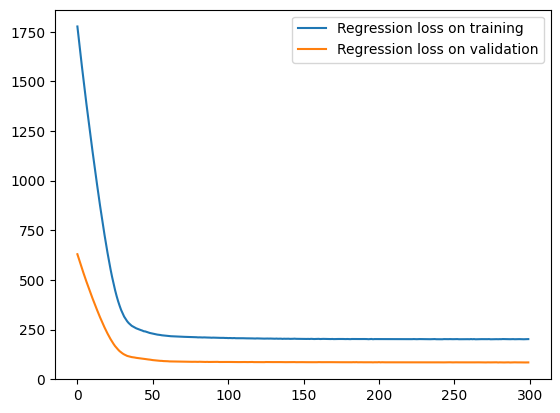

In [15]:
plt.plot(train_loss, label='Regression loss on training')
plt.plot(val_loss, label='Regression loss on validation')
plt.legend()
plt.show()

In [186]:
print(np.mean(pehe_total))

nan


In [187]:
pehe_total

[0.32149946689605713,
 0.31149980425834656,
 0.33012479543685913,
 0.3283536434173584,
 0.3182544410228729,
 0.3404625654220581,
 0.3272532820701599,
 0.29819491505622864,
 0.30554065108299255,
 0.3159219026565552,
 nan,
 0.31198298931121826,
 0.3216995298862457,
 0.3395161032676697,
 0.3155890703201294,
 0.3060864210128784,
 0.34267354011535645,
 0.32114407420158386,
 0.30718937516212463,
 0.3327989876270294]

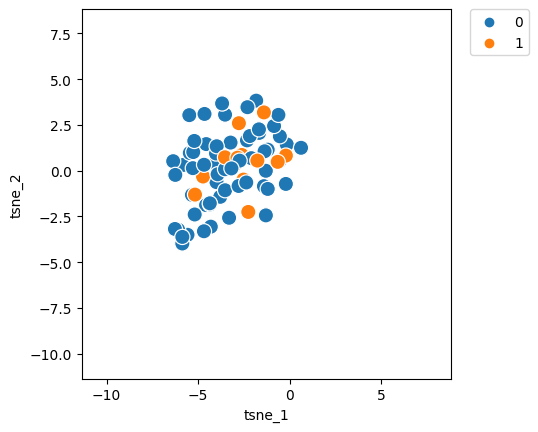

In [150]:
#concate_pred,d_out,phi=model()

data_orig=data.iloc[:,5:30]
labels=data.iloc[:,0]

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(data_orig) #combined_features combined_transformed
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

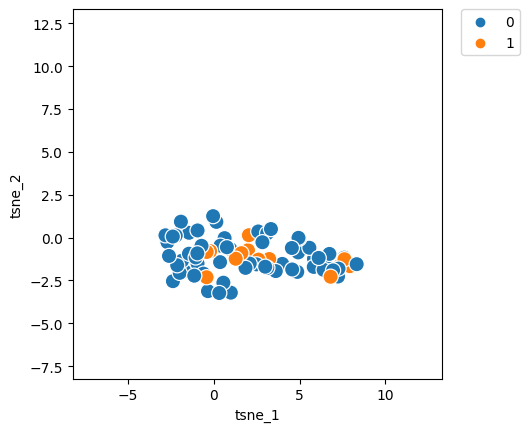

In [151]:
data_for_trans=data.iloc[:,5:30]
labels_for_trans=data.iloc[:,0]

data_tensor=torch.from_numpy(data_for_trans.to_numpy().astype(np.float32))
concate_pred,d_out,phi=model(data_tensor,0.5)

#data=data[:,5:30]
#labels=data[:,0]

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(phi.detach().cpu().numpy()) #combined_features combined_transformed
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels_for_trans})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

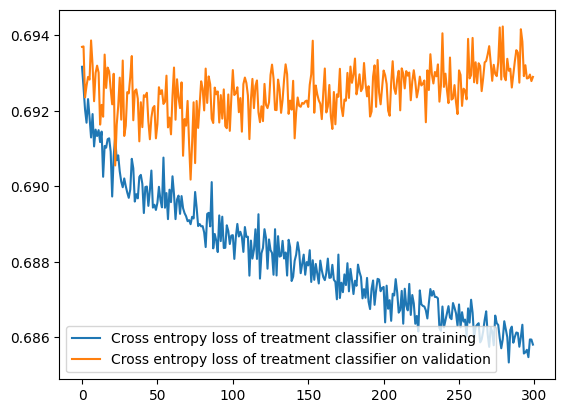

In [156]:
plt.plot(train_tloss,label='Cross entropy loss of treatment classifier on training')
plt.plot(val_tloss,label='Cross entropy loss of treatment classifier on validation')
plt.legend()
plt.show()

In [141]:
'''
full network origional with optuna

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], params['CL22']), #
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,d_out

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None




def objective(trial,i):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 512),
          'RL21': trial.suggest_int('RL21', 16, 512),
          'RL32': trial.suggest_int('RL32', 16, 512),
          'RG012':trial.suggest_int('RG012', 16, 512),
        'RG022':trial.suggest_int('RG022', 16, 512),
        'RG112':trial.suggest_int('RG112', 16, 512),
        'RG122':trial.suggest_int('RG122', 16, 512),
        'CL12':trial.suggest_int('CL12', 16, 512),
        'CL22':trial.suggest_int('CL22', 16, 512)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i)

    return pehe


'''

'\nfull network origional with optuna\n\nclass TarNet(nn.Module):\n    def __init__(self,params):\n        super(TarNet, self).__init__()\n        self.encoder1 = nn.Linear(25, params[\'RL11\'])\n        self.encoder2 = nn.Linear(params[\'RL11\'], params[\'RL21\'])\n        self.encoder3 = nn.Linear(params[\'RL21\'], params[\'RL32\'])\n        \n        self.dis1_d = nn.Sequential(\n            nn.Linear(params[\'RL32\'], params[\'CL12\']), #params[\'CL12\']\n            nn.ReLU(),\n            nn.Dropout(p=0.1)\n        )\n        self.dis2_d = nn.Sequential(\n            nn.Linear(params[\'CL12\'], params[\'CL22\']), #\n            nn.ReLU(),\n            nn.Dropout(p=.01)\n        )\n        \n        self.dis3_d = nn.Sequential(\n            nn.Linear(params[\'CL22\'], 2),\n            nn.ReLU(),\n            nn.Dropout(p=.01)\n        )\n       \n        \n        self.regressor1_y0 = nn.Sequential(\n            nn.Linear(params[\'RL32\'], params[\'RG012\']),\n            nn.ELU()

In [ ]:
'''
Library way: all networks have two layers 
1.38

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL21'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL21'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], 1),#params['RG022']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL21'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], 1), #params['RG122']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        #phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        #y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        #y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((out_y0, out_y1), 1)
        return concat,out_d2

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None

'''



In [ ]:
'''
Tutorial way: layers and neurons all changed

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], params['CL22']), #
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], 1), #params['RG022']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], 1), #params['RG122']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        #phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        #y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        #y1 = self.regressorO_y1(out_y1)

        concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        d_out = self.dis3_d(out_d2)

        concat = torch.cat((out_y0, out_y1), 1)
        return concat,d_out

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None




def objective(trial,i):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 32),
          'RL21': trial.suggest_int('RL21', 16, 32),
          'RL32': trial.suggest_int('RL32', 16, 32),
          'RG012':trial.suggest_int('RG012', 16, 32),
        'RG022':trial.suggest_int('RG022', 16, 32),
        'RG112':trial.suggest_int('RG112', 16, 32),
        'RG122':trial.suggest_int('RG122', 16, 32),
        'CL12':trial.suggest_int('CL12', 16, 32),
        'CL22':trial.suggest_int('CL22', 16, 32)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i)

    return pehe


'''

In [ ]:
'''
result 0.71 seed=42, result 0.79 seed=0, result 0.72 seed=1
one change: with 2 layers of classifier

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,out_d2

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None


'''